In [ ]:
# Cell 1: Imports & basic config

import os
import numpy as np
import pandas as pd
import glob

from numpy.linalg import norm

from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold, GroupKFold, permutation_test_score, LeaveOneGroupOut, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import RFE
from sklearn.utils import resample, shuffle, resample
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler



import nibabel as nib


from joblib import Parallel, delayed



import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests


import itertools
from itertools import combinations

from nilearn import plotting, image, masking
from nilearn.maskers import NiftiLabelsMasker


from scipy import stats
from scipy.stats import pearsonr, ttest_1samp, ttest_ind, entropy, kurtosis
from scipy.spatial.distance import pdist, squareform, cdist

from itertools import combinations
from joblib import Parallel, delayed
import time
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Union
import plotly.graph_objects as go
# Nice plotting defaults
sns.set_context("poster")

RANDOM_STATE = 42
N_SPLITS = 5   # GroupKFold folds
INNER_CV_SPLITS = 5     
CS_LABELS = ["CS-", "CSS", "CSR"]  # the three CS types of interest
N_JOBS = 32
MAX_ITER = 5000
thresh_hold_p = 1 - 0.05
N_PERMUTATION = 5000
#N_PERMUTATION = 3
N_REPEATS = 10


In [ ]:
# Cell 2: Load phase2 (extinction) and phase3 (reinstatement) data
# Update: Filters FEATURES to include only specific ROIs (Amygdala, Hippocampus, Insula, vmPFC, ACC).

import numpy as np
import os

print("--- Cell 2: Data Loading & ROI Filtering ---")

project_root = "/gscratch/fang/NARSAD"
data_root = os.path.join(project_root, "MRI/derivatives/fMRI_analysis/LSS", "firstLevel", "all_subjects/fear_network")
phase2_npz_path = os.path.join(data_root, "phase2_X_ext_y_ext_roi_voxels.npz")
phase3_npz_path = os.path.join(data_root, "phase3_X_reinst_y_reinst_roi_voxels.npz") # Note: using 'reinst' variable name

# Define the specific ROIs to keep
TARGET_ROIS = [
    'left_acc', 'left_amygdala', 'left_hippocampus', 'left_insula', 'left_vmpfc',
    'right_acc', 'right_amygdala', 'right_hippocampus', 'right_insula', 'right_vmpfc'
]

# Load Files
phase2_npz = np.load(phase2_npz_path, allow_pickle=True)
phase3_npz = np.load(phase3_npz_path, allow_pickle=True)

# ---- Helper: ROI Feature Selection ----
def filter_features_by_roi(X, roi_names, roi_counts, target_list):
    """
    Creates a boolean mask for voxels belonging to target ROIs and filters X.
    Returns: Filtered X, Filtered Parcel Names
    """
    feature_mask = []
    new_parcel_names = []
    
    # Iterate through each ROI metadata entry
    for name, count in zip(roi_names, roi_counts):
        # Create labels for this ROI (e.g., "left_amygdala_0")
        current_labels = [f"{name}_{i}" for i in range(count)]
        
        if name in target_list:
            # Keep these voxels
            feature_mask.extend([True] * count)
            new_parcel_names.extend(current_labels)
        else:
            # Drop these voxels
            feature_mask.extend([False] * count)
            
    feature_mask = np.array(feature_mask)
    
    # Apply mask to columns (features)
    if X.shape[1] != len(feature_mask):
        raise ValueError(f"Shape mismatch: X has {X.shape[1]} features, but ROI counts imply {len(feature_mask)}.")
        
    X_filtered = X[:, feature_mask]
    
    return X_filtered, new_parcel_names

# ---- Process Phase 2 (Extinction) ----
X_ext_raw = phase2_npz["X_ext"]
y_ext = phase2_npz["y_ext"]
sub_ext = phase2_npz["subjects"]
roi_names_ext = phase2_npz["roi_names"]
roi_counts_ext = phase2_npz["roi_voxel_counts"]

print(f"Original Extinction Shape: {X_ext_raw.shape}")

# Apply ROI Filter
X_ext, parcel_names_ext = filter_features_by_roi(X_ext_raw, roi_names_ext, roi_counts_ext, TARGET_ROIS)
print(f"Filtered Extinction Shape: {X_ext.shape} (kept {len(TARGET_ROIS)} ROIs)")


# ---- Process Phase 3 (Reinstatement) ----
X_reinst_raw = phase3_npz["X_reinst"]
y_reinst = phase3_npz["y_reinst"]
sub_reinst = phase3_npz["subjects"]
roi_names_reinst = phase3_npz["roi_names"]
roi_counts_reinst = phase3_npz["roi_voxel_counts"]

# Apply ROI Filter
X_reinst, parcel_names_reinst = filter_features_by_roi(X_reinst_raw, roi_names_reinst, roi_counts_reinst, TARGET_ROIS)
print(f"Filtered Reinstatement Shape: {X_reinst.shape}")


# ---- Filter for CS Trials Only ----
# Constants (Define if not present)
if 'CS_LABELS' not in locals(): CS_LABELS = ["CS-", "CSS", "CSR"]

# Keep only CS-, CSS, CSR trials
mask_ext = np.isin(y_ext, CS_LABELS)
mask_reinst = np.isin(y_reinst, CS_LABELS)

X_ext = X_ext[mask_ext]
y_ext = y_ext[mask_ext]
sub_ext = sub_ext[mask_ext]

X_reinst = X_reinst[mask_reinst]
y_reinst = y_reinst[mask_reinst]
sub_reinst = sub_reinst[mask_reinst]

print("\nAfter CS filtering:")
print("Phase2 (Ext):", X_ext.shape, np.unique(y_ext, return_counts=True))
print("Phase3 (Reinst):", X_reinst.shape, np.unique(y_reinst, return_counts=True))
print(f"Target ROIs included: {TARGET_ROIS}")

--- Cell 2: Data Loading & ROI Filtering ---
Original Extinction Shape: (2448, 4837)
Filtered Extinction Shape: (2448, 2148) (kept 10 ROIs)
Filtered Reinstatement Shape: (2400, 2148)

After CS filtering:
Phase2 (Ext): (2448, 2148) (array(['CS-', 'CSR', 'CSS'], dtype=object), array([816, 816, 816]))
Phase3 (Reinst): (2400, 2148) (array(['CS-', 'CSR', 'CSS'], dtype=object), array([800, 800, 800]))
Target ROIs included: ['left_acc', 'left_amygdala', 'left_hippocampus', 'left_insula', 'left_vmpfc', 'right_acc', 'right_amygdala', 'right_hippocampus', 'right_insula', 'right_vmpfc']


In [310]:
# Cell 3: Load subject-level metadata (Group, Drug, etc.)

# Example: a CSV with one row per subject, columns like:
#   subject_id, Group, Drug, Age, Sex, ...
# where Group ∈ {SAD, HC}, Drug ∈ {OT, PLC} or similar
meta_path = os.path.join(project_root, "MRI/source_data/behav/drug_order.csv")

meta = pd.read_csv(meta_path)

print(meta.head())
print(meta.columns)

# Basic sanity check: make sure subjects in X_ext/X_reinst exist in metadata
unique_subs_ext = np.unique(sub_ext)
unique_subs_reinst = np.unique(sub_reinst)

print("Phase2 unique subjects:", len(unique_subs_ext))
print("Phase3 unique subjects:", len(unique_subs_reinst))

missing_in_meta_ext = [s for s in unique_subs_ext if s not in set(meta["subject_id"])]
missing_in_meta_reinst = [s for s in unique_subs_reinst if s not in set(meta["subject_id"])]

print("Missing in meta (phase2):", missing_in_meta_ext)
print("Missing in meta (phase3):", missing_in_meta_reinst)


  subject_id Group      Drug  drug_condition  Gender  gender_code  demo_age  \
0       N101   SAD   Placebo               0  Female            0        21   
1       N102   SAD  Oxytocin               1    Male            1        25   
2       N103   SAD  Oxytocin               1  Female            0        23   
3       N104   SAD  Oxytocin               1    Male            1        33   
4       N105   SAD  Oxytocin               1  Female            0        21   

   guess  
0    0.0  
1    NaN  
2    0.0  
3    0.0  
4    0.0  
Index(['subject_id', 'Group', 'Drug', 'drug_condition', 'Gender',
       'gender_code', 'demo_age', 'guess'],
      dtype='object')
Phase2 unique subjects: 102
Phase3 unique subjects: 100
Missing in meta (phase2): []
Missing in meta (phase3): []


In [ ]:
# cell 4 helper functions
# =============================================================================
# 1. Pipeline & Preprocessing
# =============================================================================
# param_grid = {
#     'classification__C': np.logspace(-4, 2, 10)
# }

# SEARCH_RANGE_START = -5
# SEARCH_RANGE_END = 3
# N_POINTS = 30

# param_grid = {
#     'classification__C': np.logspace(SEARCH_RANGE_START, SEARCH_RANGE_END, N_POINTS)
# }
# Constants for the updated pipeline
SOLVER_TYPE = 'saga'           # Required for 'elasticnet' penalty
ELASTIC_PENALTY = 'elasticnet'
MAX_ITER_SAGA = 10000  # Saga needs more iterations to converge

# Update your build_binary_pipeline function:
def build_elastic_pipeline():
    return Pipeline([
        ('scaler', RobustScaler()), # Recommended over StandardScaler for clinical data
        ('classification', LogisticRegression(
            penalty=ELASTIC_NET_PENALTY,
            solver=SOLVER_TYPE,
            l1_ratio=0.5, # Default starting point, will be tuned
            class_weight='balanced',
            max_iter=MAX_ITERATIONS
        ))
    ])

# Update your grid search to find the best balance
# l1_ratio = 1 is pure Lasso, l1_ratio = 0 is pure Ridge
param_grid = {
    'classification__C': np.logspace(-4, 2, 20),
    'classification__l1_ratio': [0.1, 0.5, 0.7, 0.9] 
}

def filter_features_by_roi(X, roi_names, roi_counts, target_list):
    """
    Creates a boolean mask for voxels belonging to target ROIs and filters X.
    Returns: Filtered X, Filtered Parcel Names
    """
    feature_mask = []
    new_parcel_names = []
    
    # Iterate through each ROI metadata entry
    for name, count in zip(roi_names, roi_counts):
        # Create labels for this ROI (e.g., "left_amygdala_0")
        current_labels = [f"{name}_{i}" for i in range(count)]
        
        if name in target_list:
            # Keep these voxels
            feature_mask.extend([True] * count)
            new_parcel_names.extend(current_labels)
        else:
            # Drop these voxels
            feature_mask.extend([False] * count)
            
    feature_mask = np.array(feature_mask)
    
    # Apply mask to columns (features)
    if X.shape[1] != len(feature_mask):
        raise ValueError(f"Shape mismatch: X has {X.shape[1]} features, but ROI counts imply {len(feature_mask)}.")
        
    X_filtered = X[:, feature_mask]
    
    return X_filtered, new_parcel_names

#------------------------------

#--- Function: build_binary_pipeline ---
# def build_binary_pipeline():
#     return Pipeline([
#         ('scaler', StandardScaler()),
#         ('classification', LogisticRegression(
#             penalty='l2', 
#             solver='lbfgs', 
#             class_weight='balanced', 
#             max_iter=MAX_ITER, 
#             random_state=RANDOM_STATE, 
#             n_jobs=1
#         ))
#     ])
def build_binary_pipeline():
    """
    Expert-level fMRI pipeline using ElasticNet and Robust Scaling.
    - RobustScaler: Handles fMRI intensity outliers better than StandardScaler.
    - ElasticNet: Combines L1 (sparsity) and L2 (grouping) for stable neural patterns.
    """
    return Pipeline([
        ('scaler', RobustScaler()), # Better for fMRI noise/motion spikes
        ('classification', LogisticRegression(
            penalty=ELASTIC_PENALTY,
            solver=SOLVER_TYPE,
            l1_ratio=0.5,        # This is a placeholder; it MUST be tuned in param_grid
            class_weight='balanced',
            max_iter=MAX_ITER_SAGA,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS             # Keep at 1 if inner GridSearchCV is already using n_jobs=-1
        ))
    ])

#------------------------------
#--- Function: subject_wise_centering ---
def subject_wise_centering(X, subjects):
    """Centers data per subject."""
    X_centered = np.zeros_like(X)
    unique_subs = np.unique(subjects)
    for sub in unique_subs:
        mask = (subjects == sub)
        if np.sum(mask) > 0:
            X_centered[mask] = X[mask] - np.mean(X[mask], axis=0)
    return X_centered

#------------------------------
#
#--- Function: get_top_percentile_mask ---
def get_top_percentile_mask(scores, percentile):
    thresh = np.percentile(scores, percentile)
    return (scores >= thresh) & (scores > 0)

#------------------------------

#--- Function: run_cross_decoding ---
def run_cross_decoding(model, X, y, groups, classes=None):
    """
    Applies a pre-trained model to a new dataset and calculates accuracy 
    per subject (group).
    
    Parameters
    ----------
    model : estimator
        A fitted scikit-learn estimator (e.g., the SAD model).
    X : array-like
        Feature matrix of the test set (e.g., HC data).
    y : array-like
        True labels of the test set.
    groups : array-like
        Subject IDs corresponding to X and y.
    classes : array-like, optional
        Expected class labels (used for verification, if needed).
        
    Returns
    -------
    accuracies : np.ndarray
        Array of accuracy scores, one per subject in 'groups'.
    """
    unique_subjects = np.unique(groups)
    accuracies = []

    for sub in unique_subjects:
        # 1. Isolate data for the current subject
        mask_sub = (groups == sub)
        X_sub = X[mask_sub]
        y_sub = y[mask_sub]
        
        # 2. Make predictions using the provided (frozen) model
        y_pred = model.predict(X_sub)
        
        # 3. Calculate accuracy for this subject
        acc = accuracy_score(y_sub, y_pred)
        accuracies.append(acc)

    return np.array(accuracies)

#------------------------------

#--- Function: run_perm_simple ---
def run_perm_simple(X, y, groups, n_iters):
    """
    Runs permutation testing iterations for a single job.
    
    Parameters:
    -----------
    X : array-like, feature matrix
    y : array-like, labels
    groups : array-like, group labels (subjects)
    n_iters : int, number of permutations to run in this batch
    
    Returns:
    --------
    scores : list of mean accuracy scores for each permutation
    """
    scores = []
    y_shuffled = y.copy()
    
    # Use the same pipeline builder and CV splitter as your main analysis
    pipe = build_binary_pipeline()
    cv = StratifiedGroupKFold(n_splits=N_SPLITS)
    
    for _ in range(n_iters):
        # 1. Shuffle labels randomly (breaking the relationship between X and y)
        np.random.shuffle(y_shuffled)
        
        # 2. Run Cross-Validation on shuffled data
        #    Note: We pass 'groups' to ensure no subject leakage between train/test folds
        cv_scores = cross_val_score(
            pipe, 
            X, 
            y_shuffled, 
            groups=groups, 
            cv=cv, 
            scoring='accuracy', 
            n_jobs=N_JOBS # Parallelism is handled at the outer loop level
        )
        
        # 3. Store the mean accuracy for this permutation
        scores.append(np.mean(cv_scores))
        
    return scores

#------------------------------

#--- Function: run_cross_perm ---
def run_cross_perm(model, X, y, subs, n_iter):
    """Cross-Decoding Permutation."""
    null_scores = []
    mask_c = np.isin(y, model.classes_)
    X_f = X[mask_c]; y_f = y[mask_c]; s_f = subs[mask_c]
    has_scaler = any('scaler' in step[0] for step in model.steps) if hasattr(model, 'steps') else False
    if not has_scaler: X_f = subject_wise_centering(X_f, s_f)

    for _ in range(n_iter):
        y_shuff = np.random.permutation(y_f)
        score = model.score(X_f, y_shuff) 
        null_scores.append(score)
    return np.array(null_scores)

#------------------------------

#--- Function: run_spatial_perm ---
def run_spatial_perm(seed, maps, groups):
    rng = np.random.default_rng(seed)
    shuffled = rng.permutation(groups)
    w_sad_p = np.mean(maps[shuffled == "SAD"], axis=0)
    w_hc_p = np.mean(maps[shuffled == "HC"], axis=0)
    return cosine_similarity(w_sad_p.reshape(1, -1), w_hc_p.reshape(1, -1))[0][0]

#------------------------------

#--- Function: run_pairwise_decoding_analysis ---
def run_pairwise_decoding_analysis(X, y, subjects, n_repeats=10):
    X = np.array(X); y = np.array(y); subjects = np.array(subjects)
    classes = np.unique(y); pairs = list(combinations(classes, 2)); results = {}
    
    print(f"\n=== Starting Repeated Pairwise Decoding ({len(pairs)} pairs, {n_repeats} repeats) ===")
    
    for c1, c2 in pairs:
        pair_name = f"{c1} vs {c2}"; print(f"\n--- Analysis: {pair_name} ---")
        mask = np.isin(y, [c1, c2]); X_pair = X[mask]; y_pair = y[mask]; sub_pair = subjects[mask]
        
        # ---------------------------------------------------------------------
        # PHASE 1: EVALUATION (Repeated Nested CV)
        # ---------------------------------------------------------------------
        all_repeat_scores = []
        for r in range(n_repeats):
            # Dynamic random_state is critical for supercomputer repetitions
            gkf_outer = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE + r)
            cv_inner = StratifiedGroupKFold(n_splits=INNER_CV_SPLITS, shuffle=True, random_state=RANDOM_STATE + r)
            
            repeat_scores = []
            print(f"  > Repeat {r+1}/{n_repeats}...")
            
            for i, (train_idx, test_idx) in enumerate(gkf_outer.split(X_pair, y_pair, groups=sub_pair), 1):
                # Using N_JOBS here to parallelize hyperparameter combinations
                gs = GridSearchCV(build_binary_pipeline(), param_grid, cv=cv_inner, 
                                  scoring='accuracy', n_jobs=N_JOBS, verbose=0)
                gs.fit(X_pair[train_idx], y_pair[train_idx], groups=sub_pair[train_idx])
                
                best_model = gs.best_estimator_
                
                # Forced-Choice logic
                raw_val = best_model.decision_function(X_pair[test_idx])
                scores_2d = np.column_stack((-raw_val, raw_val)) if raw_val.ndim == 1 else raw_val
                
                val_df = pd.DataFrame(scores_2d, columns=best_model.classes_)
                val_df['sub'] = sub_pair[test_idx]
                val_df['y'] = y_pair[test_idx]
                mean_val = val_df.groupby(['sub', 'y']).mean().reset_index()
                
                fold_fc_acc = compute_pairwise_forced_choice(
                    mean_val['y'].values, 
                    mean_val[best_model.classes_].values, 
                    best_model.classes_
                )
                repeat_scores.append(fold_fc_acc)
            
            all_repeat_scores.extend(repeat_scores)
            
        avg_cv_acc = np.mean(all_repeat_scores)
        std_cv_acc = np.std(all_repeat_scores)
        print(f"  > Final Mean Forced-Choice Accuracy: {avg_cv_acc:.4f} (+/- {std_cv_acc:.4f})")

        # ---------------------------------------------------------------------
        # PHASE 2: MODEL GENERATION (Refit on Full Data)
        # ---------------------------------------------------------------------
        print("  > Generating final model (Refit on full data for Haufe patterns)...")
        cv_inner_final = StratifiedGroupKFold(n_splits=INNER_CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
        gs_final = GridSearchCV(build_binary_pipeline(), param_grid, cv=cv_inner_final, 
                                scoring='accuracy', n_jobs=N_JOBS)
        gs_final.fit(X_pair, y_pair, groups=sub_pair)
        
        final_model = gs_final.best_estimator_
        
        # Haufe Pattern calculation (Expert Standard)
        # A = cov(X) * W / var(score)
        W = final_model.named_steps['classification'].coef_
        X_scaled = final_model.named_steps['scaler'].transform(X_pair)
        # We use biased=False for covariance to stay conservative
        A = np.cov(X_scaled, rowvar=False, ddof=1) @ W.T 
        
        results[pair_name] = {
            'model': final_model,
            'accuracy': avg_cv_acc, 
            'std': std_cv_acc,
            'best_params': gs_final.best_params_, # Store both C and l1_ratio
            'haufe_pattern': A.flatten(), 
            'classes': final_model.classes_
        }
    return results

#------------------------------

#--- Function: plot_dist_with_thresh ---
def plot_dist_with_thresh(null_dist, obs_val, ax, title, tail='upper', color='gray'):
    sns.histplot(null_dist, color='gray', stat='density', kde=True, alpha=0.4, ax=ax, label='Null Dist')
    ax.axvline(obs_val, color='red', lw=2.5, label=f'Obs: {obs_val:.2f}')
    if tail == 'upper':
        thresh = np.percentile(null_dist, 95); ax.axvline(thresh, color='blue', ls='--', lw=2, label=f'95%: {thresh:.2f}'); p_val = np.mean(null_dist >= obs_val)
    elif tail == 'lower':
        thresh = np.percentile(null_dist, 5); ax.axvline(thresh, color='blue', ls='--', lw=2, label=f'5%: {thresh:.2f}'); p_val = np.mean(null_dist <= obs_val)
    elif tail == 'two-tailed':
        t_low = np.percentile(null_dist, 2.5); t_high = np.percentile(null_dist, 97.5)
        ax.axvline(t_low, color='blue', ls='--', lw=2); ax.axvline(t_high, color='blue', ls='--', lw=2)
        p_val = 2 * min(np.mean(null_dist <= obs_val), np.mean(null_dist >= obs_val))
    ax.set_title(f"{title}\n(p = {p_val:.4f})"); ax.legend(loc='best', fontsize='small')
    return p_val

#------------------------------

#--- Function: make_river_plot_importance ---
def make_river_plot_importance(importance_dict, feature_names, top_k=20, title="Neural Signatures"):
    # (Same as before)
    pass 

#------------------------------

#--- Function: get_group_key ---
def get_group_key(sub_id):
    """Returns 'Group_Drug' key (e.g., 'SAD_Placebo') for a subject ID."""
    s_str = str(sub_id).strip()
    
    # Try different ID formats
    conds = None
    if s_str in sub_to_meta: conds = sub_to_meta[s_str]
    elif f"sub-{s_str}" in sub_to_meta: conds = sub_to_meta[f"sub-{s_str}"]
    elif s_str.replace("sub-", "") in sub_to_meta: conds = sub_to_meta[s_str.replace("sub-", "")]
    
    if conds:
        return f"{conds['Group']}_{conds['Drug']}"
    return None

#------------------------------

#--- Function: process_phase_data ---
def process_phase_data(X_all, y_all, sub_all, phase_name):
    print(f"\nProcessing {phase_name} Phase...")
    if X_all is None: return {k: None for k in group_keys}
    
    # Storage for results
    grouped_data = {k: {'X': [], 'y': [], 'sub': []} for k in group_keys}
    
    # 1. Identify Unique Subjects
    unique_subs = np.unique(sub_all)
    print(f"  > Found {len(unique_subs)} unique subjects.")
    
    count_missing_meta = 0
    
    for sub in unique_subs:
        # 2. Get Group Key
        g_key = get_group_key(sub)
        if not g_key:
            count_missing_meta += 1
            continue
            
        # 3. Extract Subject's FULL Data
        mask_sub = (sub_all == sub)
        X_sub_full = X_all[mask_sub]
        y_sub_full = y_all[mask_sub]
        
        # 4. CENTER DATA (Full Subject Mean)
        #    We subtract the mean of ALL trials (CS+, CS-, etc.) to preserve true baseline
        sub_mean = np.mean(X_sub_full, axis=0)
        X_sub_centered = X_sub_full - sub_mean
        
        # 5. FILTER CONDITIONS (Keep only CSS / CSR)
        mask_cond = np.isin(y_sub_full, ["CSS", "CSR"])
        
        if np.sum(mask_cond) > 0:
            grouped_data[g_key]['X'].append(X_sub_centered[mask_cond])
            grouped_data[g_key]['y'].append(y_sub_full[mask_cond])
            # Create subject ID array matching the filtered length
            grouped_data[g_key]['sub'].append(np.full(np.sum(mask_cond), sub))
            
    if count_missing_meta > 0:
        print(f"  ! Warning: {count_missing_meta} subjects missing metadata skipped.")

    # 6. Final Assembly
    final_output = {}
    for key in group_keys:
        if len(grouped_data[key]['X']) > 0:
            final_output[key] = {
                "X": np.vstack(grouped_data[key]['X']),
                "y": np.concatenate(grouped_data[key]['y']),
                "sub": np.concatenate(grouped_data[key]['sub'])
            }
            n_sub = len(np.unique(final_output[key]['sub']))
            print(f"  [{key}] {phase_name}: {n_sub} subjects | Matrix: {final_output[key]['X'].shape}")
        else:
            final_output[key] = None
            print(f"  [{key}] {phase_name}: No data.")
            
    return final_output

#------------------------------

#--- Function: get_extinction_data ---
def get_extinction_data(group_key):
    if group_key not in data_subsets:
        raise ValueError(f"Group {group_key} missing from data_subsets.")
    
    phase_data = data_subsets[group_key]['ext']
    if phase_data is None:
        raise ValueError(f"Extinction data missing for {group_key}.")
        
    # X is already centered from Cell 5
    return phase_data["X"], phase_data["y"], phase_data["sub"]

#------------------------------

#--- Function: reconstruct_roi_map ---
def reconstruct_roi_map(flat_data, roi_names, roi_dir):
    """
    Paints a 1D array of values back into a 3D brain volume by iterating 
    through the specific list of ROI masks.
    """
    # 1. Determine Reference Space (Load first mask)
    first_mask_path = glob.glob(os.path.join(roi_dir, f"*{roi_names[0]}*.nii*"))[0]
    ref_img = nib.load(first_mask_path)
    affine = ref_img.affine
    final_vol = np.zeros(ref_img.shape)
    
    current_idx = 0
    
    # 2. Iterate and Paint
    for name in roi_names:
        # Find file (handle potential suffixes like .nii or .nii.gz)
        fpaths = glob.glob(os.path.join(roi_dir, f"*{name}*.nii*"))
        if not fpaths:
            print(f"  ! Error: Mask for '{name}' not found in {roi_dir}")
            return None
        
        mask_img = nib.load(fpaths[0])
        mask_data = mask_img.get_fdata() > 0 # Boolean mask
        n_voxels = np.sum(mask_data)
        
        # Check if we have enough data left
        if current_idx + n_voxels > len(flat_data):
            print(f"  ! Error: Data mismatch. Feature vector too short for ROI {name}.")
            return None
            
        # Extract chunk and paint
        roi_values = flat_data[current_idx : current_idx + n_voxels]
        final_vol[mask_data] = roi_values # Place values in 3D space
        
        current_idx += n_voxels
        
    # Check if data was fully consumed
    if current_idx != len(flat_data):
         print(f"  ! Warning: {len(flat_data) - current_idx} features were unused (Feature vector longer than ROIs).")

    return nib.Nifti1Image(final_vol, affine)

#------------------------------

#--- Function: compute_haufe_binary_robust ---
def compute_haufe_binary_robust(model, X):
    scores = model.decision_function(X)
    return np.dot((X - np.mean(X, axis=0)).T, scores - np.mean(scores)) / (X.shape[0] - 1)

#------------------------------

#--- Function: get_robust_weights ---
def get_robust_weights(X, y, subjects, pipeline, n_boot=10):
    unique_subs = np.unique(subjects)
    accumulated_weights = np.zeros(X.shape[1])
    for i in range(n_boot):
        boot_subs = resample(unique_subs, replace=True, random_state=i)
        X_boot_list, y_boot_list = [], []
        for sub in boot_subs:
            mask = (subjects == sub)
            X_sub = X[mask]
            X_boot_list.append(X_sub - np.mean(X_sub, axis=0))
            y_boot_list.append(y[mask])
        X_boot = np.vstack(X_boot_list)
        y_boot = np.hstack(y_boot_list)
        
        clf = clone(pipeline)
        clf.fit(X_boot, y_boot)
        accumulated_weights += compute_haufe_binary_robust(clf, X_boot)
    return accumulated_weights / n_boot

##------------------------------

#--- Function: run_wen_paper_analysis_voxelwise ---
def run_wen_paper_analysis_voxelwise(X, y, subjects, pipeline_template, best_params, n_permutations):
    """
    Updated for ElasticNet and High-Performance Computing.
    best_params: should be the dictionary from gs.best_params_ 
    """
    print(f"  Estimating Weights ({n_permutations} perms) with ElasticNet...")
    
    # 1. Clone and set BOTH C and l1_ratio
    pipe = clone(pipeline_template)
    pipe.set_params(**best_params) 
    
    # 2. Observed Weights (using consistent bootstrapping)
    # n_boot=10 is the expert standard for stable Haufe patterns
    obs_weights = get_robust_weights(X, y, subjects, pipe, n_boot=10)
    
    # 3. Parallel Null Distribution Generation
    def run_null(i):
        # Ensure each permutation has a unique seed
        y_shuff = shuffle(y, random_state=i)
        # For nulls, n_boot can be 1 to save time, 
        # but Z-scoring is more accurate if the estimation method is identical.
        return get_robust_weights(X, y_shuff, subjects, pipe, n_boot=10)

    # Use 'threading' or 'multiprocessing' backend depending on your cluster setup
    # 'loky' is the default and usually safest for Scikit-Learn on clusters
    null_weights_list = Parallel(n_jobs=N_JOBS, verbose=1, backend='loky')(
        delayed(run_null)(i) for i in range(n_permutations)
    )
    
    null_weights = np.array(null_weights_list)
    
    # 4. Statistical Mapping
    null_mean = np.mean(null_weights, axis=0)
    null_std = np.std(null_weights, axis=0)
    
    # Z-scores indicate how many STDs the real signal is above the noise
    z_scores = (obs_weights - null_mean) / (null_std + 1e-12)
    
    # Two-tailed permutation p-value calculation
    n_extreme = np.sum(np.abs(null_weights) >= np.abs(obs_weights), axis=0)
    p_values = (n_extreme + 1) / (n_permutations + 1)
    
    # 5. Multiple Comparisons Correction (FDR)
    # fdr_alpha should be a variable (usually 0.05)
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=fdr_alpha, method='fdr_bh')
    
    return z_scores, reject, pvals_corrected

#------------------------------

#--- Function: compute_pairwise_forced_choice ---
def compute_pairwise_forced_choice(y_true, scores, class_labels):
    """
    Computes accuracy where for each trial, the class with the higher 
    aggregated decision score is chosen.
    """
    classes = sorted(list(set(y_true)))
    accs = []
    pairs = list(combinations(classes, 2))
    
    for c1, c2 in pairs:
        idx_c1 = np.where(y_true == c1)[0]
        idx_c2 = np.where(y_true == c2)[0]
        if len(idx_c1) == 0 or len(idx_c2) == 0: continue
            
        col_c1 = list(class_labels).index(c1)
        col_c2 = list(class_labels).index(c2)
        
        subset_idx = np.concatenate([idx_c1, idx_c2])
        subset_y = y_true[subset_idx]
        subset_scores = scores[subset_idx]
        
        # Choice logic: is score for C1 > score for C2?
        diff = subset_scores[:, col_c1] - subset_scores[:, col_c2]
        subset_pred = np.where(diff > 0, c1, c2)
        
        accs.append(accuracy_score(subset_y, subset_pred))
        
    return np.mean(accs) if accs else 0.0

#------------------------------

#--- Function: compute_perm_importance_simple ---
def compute_perm_importance_simple(model, X, y, n_repeats=10):
    """
    Calculates permutation importance for a model.
    Returns: Mean importance decrease per feature.
    """
    from sklearn.inspection import permutation_importance
    
    # We use 'accuracy' as the scoring metric to see which voxels contribute to decoding
    result = permutation_importance(
        model, X, y, n_repeats=n_repeats, random_state=42, n_jobs=N_JOBS, scoring='accuracy'
    )
    
    return result.importances_mean

##------------------------------

#--- Function: calculate_centroid_rdm ---
def calculate_centroid_rdm(X, y, subjects, conditions):
    unique_subs = np.unique(subjects); rdms = []; sub_ids = []
    
    for sub in unique_subs:
        mask_sub = (subjects == sub)
        X_sub = X[mask_sub]
        y_sub = y[mask_sub]
        
        centroids = []
        valid = True
        for cond in conditions:
            mask_cond = (y_sub == cond)
            if np.sum(mask_cond) == 0: 
                valid = False
                break
            # Calculate Centroid
            centroids.append(np.mean(X_sub[mask_cond], axis=0))
            
        if valid:
            # Correlation Distance (1-r)
            # pdist returns condensed distance matrix, squareform makes it N x N
            rdm = squareform(pdist(np.array(centroids), metric='correlation'))
            rdms.append(rdm)
            sub_ids.append(sub)
            
    return np.array(rdms), np.array(sub_ids)

#------------------------------

#--- Function: extract_metrics ---
def extract_metrics(rdms):
    # Metric A: Threat (CSR) vs Safety (CSS)
    m_a = rdms[:, idx_csr, idx_css] 
    # Metric B: Safety (CSS) vs Baseline (CS-)
    m_b = rdms[:, idx_css, idx_cs_minus] 
    return m_a, m_b

#------------------------------

#--- Function: one_sample_test ---
def one_sample_test(data, name):
    # Test if distance is greater than 0
    t_val, p_val = ttest_1samp(data, 0, alternative='greater')
    sig = "*" if p_val < 0.05 else "ns"
    print(f"  > {name}: Mean={np.mean(data):.3f}, t={t_val:.3f}, p={p_val:.4f} ({sig})")
    return p_val

#------------------------------

#--- Function: perm_ttest_ind ---
def perm_ttest_ind(data1, data2, n_perm=N_PERMUTATION):
    """
    Performs a permutation t-test for two independent samples.
    Returns: t-stat, p-value, mean1, mean2
    """
    from scipy.stats import ttest_ind
    
    # 1. Calculate observed t-statistic
    t_obs, _ = ttest_ind(data1, data2)
    
    # 2. Permutation loop
    pooled = np.concatenate([data1, data2])
    n1 = len(data1)
    null_dist = []
    
    rng = np.random.default_rng(42) # Fixed seed
    
    for _ in range(n_perm):
        shuffled = rng.permutation(pooled)
        # Split into two groups of same size as originals
        g1 = shuffled[:n1]
        g2 = shuffled[n1:]
        
        # Calculate t-stat for shuffled data
        t_shuff, _ = ttest_ind(g1, g2)
        null_dist.append(t_shuff)
        
    null_dist = np.array(null_dist)
    
    # 3. Calculate P-value (Two-tailed)
    # Proportion of null t-stats more extreme than observed t
    p_val = np.mean(np.abs(null_dist) >= np.abs(t_obs))
    
    return t_obs, p_val, np.mean(data1), np.mean(data2)

#------------------------------

#--- Function: get_sig_star ---
def get_sig_star(p): return "*" if p < 0.05 else "ns"

#------------------------------

#--- Function: get_phase_data ---
def get_phase_data(group, phase):
    try:
        d = data_subsets[group][phase]
        if d is None: return None, None, None
        return d["X"], d["y"], d["sub"]
    except KeyError:
        return None, None, None

#------------------------------

#--- Function: calculate_plasticity_vectors ---
def calculate_plasticity_vectors(
    X_learn, y_learn, sub_learn,   # Data for Learning Trajectory (Start -> End)
    X_targ, y_targ, sub_targ,      # Data for Target Definition
    feature_mask, 
    cond_learn,                    # Condition changing (e.g., CSS or CSR)
    cond_target_label              # Label of the target (e.g., CS- or CSR)
):
    """
    Calculates projection of learning (in X_learn) onto axis towards Target (in X_targ).
    """
    # 1. Apply Feature Mask & Centering
    # Note: Center phases separately to remove global session shifts (drift correction)
    X_L = subject_wise_centering(X_learn[:, feature_mask], sub_learn)
    X_T = subject_wise_centering(X_targ[:, feature_mask], sub_targ)
    
    unique_subs = np.intersect1d(np.unique(sub_learn), np.unique(sub_targ))
    res = {'sub': [], 'projection': [], 'cosine': [], 'init_dist': []}
    
    for sub in unique_subs:
        # Slice Learning Data (The Drift)
        m_l = (sub_learn == sub); xl = X_L[m_l]; yl = y_learn[m_l]
        
        # Slice Target Data (The Goal)
        m_t = (sub_targ == sub); xt = X_T[m_t]; yt = y_targ[m_t]
        
        # A. Define Target Centroid (P_target)
        mask_tgt_cond = (yt == cond_target_label)
        if np.sum(mask_tgt_cond) == 0: continue
        P_target = np.mean(xt[mask_tgt_cond], axis=0)
        
        # B. Define Start & End (Learning Phase)
        mask_lrn_cond = (yl == cond_learn)
        idx_lrn = np.where(mask_lrn_cond)[0]
        if len(idx_lrn) < 2: continue
        
        cutoff = len(idx_lrn) // 2
        # Early Learning
        P_start = np.mean(xl[idx_lrn[:cutoff]], axis=0)
        # Late Learning
        P_end = np.mean(xl[idx_lrn[cutoff:]], axis=0)
        
        # C. Define Vectors
        # Axis: From Start (Ext) -> Target (Reinstatement or CS-)
        V_axis = P_target - P_start
        # Drift: Actual change during learning
        V_drift = P_end - P_start
        
        norm_axis = norm(V_axis)
        norm_drift = norm(V_drift)
        
        if norm_axis == 0 or norm_drift == 0: continue
        
        dot_prod = np.dot(V_drift, V_axis)
        
        # Scalar Projection (Magnitude)
        projection = dot_prod / norm_axis
        
        # Cosine Similarity (Fidelity)
        cosine = dot_prod / (norm_drift * norm_axis)
        
        res['sub'].append(sub)
        res['projection'].append(projection)
        res['cosine'].append(cosine)
        res['init_dist'].append(norm_axis)
        
    return pd.DataFrame(res)

#------------------------------

#--- Function: tag_df ---
def tag_df(df, grp, cond):
    if df.empty: return df
    d = df.copy(); d['Group'] = grp; d['Condition'] = cond
    return d

#------------------------------

#--- Function: calc_trajectory ---
def calc_trajectory(
    X_learn, y_learn, sub_learn,    # The trials we want to project (the "Movie")
    X_targ, y_targ, sub_targ,       # The dataset containing the Goal State
    mask, 
    cond_learn,                     # Condition to track (e.g., CSS)
    cond_target_label               # Label of Goal State (e.g., CS- or CSR)
):
    # Center Data separately to remove session effects
    X_L = subject_wise_centering(X_learn[:, mask], sub_learn)
    X_T = subject_wise_centering(X_targ[:, mask], sub_targ)
    
    unique_subs = np.intersect1d(np.unique(sub_learn), np.unique(sub_targ))
    res = {'sub': [], 'trial': [], 'score': []}
    
    for sub in unique_subs:
        # 1. Get Subject Data
        xl = X_L[sub_learn == sub]; yl = y_learn[sub_learn == sub]
        xt = X_T[sub_targ == sub]; yt = y_targ[sub_targ == sub]
        
        # 2. Define Start Point (Early Learning)
        # We define "Start" as the centroid of the FIRST HALF of the learning trials
        mask_l = (yl == cond_learn)
        trials_l = xl[mask_l]
        if len(trials_l) < 2: continue
        
        cutoff = max(1, len(trials_l) // 2)
        P_start = np.mean(trials_l[:cutoff], axis=0)
        
        # 3. Define Target Point
        mask_t = (yt == cond_target_label)
        if np.sum(mask_t) == 0: continue
        P_target = np.mean(xt[mask_t], axis=0)
        
        # 4. Define Axis
        V_axis = P_target - P_start
        sq_norm = np.dot(V_axis, V_axis)
        if sq_norm == 0: continue
        
        # 5. Project Each Trial
        # Logic: Score = ((Trial - Start) . Axis) / ||Axis||^2
        # This normalizes the progress: 0.0 = Start, 1.0 = Target
        
        # We center the trials relative to the Start Point of this specific axis
        trials_centered = trials_l - P_start
        
        scores = np.dot(trials_centered, V_axis) / sq_norm
        
        for i, s in enumerate(scores):
            res['sub'].append(sub)
            res['trial'].append(i + 1)
            res['score'].append(s)
            
    return pd.DataFrame(res)

#------------------------------

#--- Function: run_detailed_stats ---
def run_detailed_stats(df_sad, df_hc, label):
    if df_sad.empty or df_hc.empty: return pd.DataFrame()
    
    trials = sorted(list(set(df_sad['trial'].unique()) & set(df_hc['trial'].unique())))
    results = []
    
    for t in trials:
        s_vals = df_sad[df_sad['trial'] == t]['score'].values
        h_vals = df_hc[df_hc['trial'] == t]['score'].values
        
        # A. SAD > 0
        t_s, p_s = ttest_1samp(s_vals, 0, alternative='greater')
        df_s = len(s_vals) - 1
        
        # B. HC > 0
        t_h, p_h = ttest_1samp(h_vals, 0, alternative='greater')
        df_h = len(h_vals) - 1
        
        # C. SAD != HC
        t_d, p_d = ttest_ind(s_vals, h_vals)
        df_d = len(s_vals) + len(h_vals) - 2
        
        results.append({
            'Trial': t,
            'SAD_t': t_s, 'SAD_df': df_s, 'SAD_p': p_s,
            'HC_t': t_h, 'HC_df': df_h, 'HC_p': p_h,
            'Diff_t': t_d, 'Diff_df': df_d, 'Diff_p': p_d
        })
        
    stats_df = pd.DataFrame(results)
    
    # FDR Correction
    if not stats_df.empty:
        _, stats_df['SAD_p_fdr'], _, _ = multipletests(stats_df['SAD_p'], alpha=0.05, method='fdr_bh')
        _, stats_df['HC_p_fdr'], _, _ = multipletests(stats_df['HC_p'], alpha=0.05, method='fdr_bh')
        _, stats_df['Diff_p_fdr'], _, _ = multipletests(stats_df['Diff_p'], alpha=0.05, method='fdr_bh')
        
    print(f"\n--- Statistics: {label} ---")
    # Print significant trials (Diff)
    sig_diff = stats_df[stats_df['Diff_p_fdr'] < 0.05]
    if not sig_diff.empty:
        print("Significant Group Differences (FDR < 0.05):")
        print(sig_diff[['Trial', 'Diff_t', 'Diff_df', 'Diff_p', 'Diff_p_fdr']].to_string(index=False))
    else:
        print("No significant group differences found (FDR corrected).")
        
    return stats_df

###------------------------------

#--- Function: prepare_plot ---
def prepare_plot(df_sad, df_hc, name):
    if df_sad.empty and df_hc.empty: return pd.DataFrame()
    d_list = []
    if not df_sad.empty:
        d1 = df_sad.copy(); d1['Group'] = 'SAD'; d_list.append(d1)
    if not df_hc.empty:
        d2 = df_hc.copy();  d2['Group'] = 'HC'; d_list.append(d2)
    
    if not d_list: return pd.DataFrame()
    
    df = pd.concat(d_list)
    df['Condition'] = name
    # Bin trials if needed
    if BLOCK_SIZE > 1:
        df['trial'] = ((df['trial'] - 1) // BLOCK_SIZE) + 1
    return df

#------------------------------

#--- Function: get_significant_mask ---
def get_significant_mask(scores): return scores > 0

#------------------------------

#--- Function: calculate_distribution_stats ---
def calculate_distribution_stats(X, y, subjects, feature_mask, best_params_dict):
    # Slice Features & Center
    X_masked = X[:, feature_mask]
    X_masked = subject_wise_centering(X_masked, subjects)
    
    unique_subs = np.unique(subjects)
    res = {'sub': [], 'entropy': [], 'kurtosis': [], 'variance': [], 'probabilities': []}
    
    for sub in unique_subs:
        c_val = best_params_dict.get(sub, 1.0)
        mask_sub = (subjects == sub)
        X_sub = X_masked[mask_sub]; y_sub = y[mask_sub]
        
        # Filter Boundary Classes
        mask_binary = np.isin(y_sub, [COND_CLASS_THREAT, COND_CLASS_SAFE])
        X_binary = X_sub[mask_binary]; y_binary = y_sub[mask_binary]
        
        if len(y_binary) < 10: continue
        
        try:
            # Configure Model
            fixed_model = build_binary_pipeline()
            fixed_model.set_params(classification__C=c_val)
            
            # Cross-Validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
            probs_all = cross_val_predict(fixed_model, X_binary, y_binary, cv=cv, method='predict_proba', n_jobs=N_JOBS)
            
            # Extract Safety Cue Probabilities (P(Threat | Safety Cue))
            classes = sorted(np.unique(y_binary))
            if COND_CLASS_THREAT not in classes: continue
            idx_threat = classes.index(COND_CLASS_THREAT)
            
            mask_css = (y_binary == COND_CLASS_SAFE)
            if np.sum(mask_css) == 0: continue
            probs_css = probs_all[mask_css, idx_threat]
            
            # Metrics
            # 1. Entropy
            p_clean = np.clip(probs_css, 1e-9, 1-1e-9)
            trial_entropies = [entropy([p, 1-p], base=2) for p in p_clean]
            
            # 2. Kurtosis (Fisher's definition, Normal = 0.0)
            k_val = kurtosis(probs_css, fisher=True)
            
            # 3. Variance
            v_val = np.var(probs_css)
            
            res['sub'].append(sub)
            res['entropy'].append(np.mean(trial_entropies))
            res['kurtosis'].append(k_val)
            res['variance'].append(v_val)
            res['probabilities'].append(probs_css)
            
        except Exception as e:
            # print(f"  ! Subject {sub} failed: {e}")
            pass
            
    return pd.DataFrame(res)

#------------------------------

#--- Function: get_ext_data ---
def get_ext_data(group_key):
    if group_key not in data_subsets: raise ValueError(f"{group_key} missing.")
    d = data_subsets[group_key]['ext']
    return d["X"], d["y"], d["sub"]

#------------------------------

#--- Function: compare_metric ---
def compare_metric(vec1, vec2, metric_name):
    print(f"\n--- Metric: {metric_name} ---")
    if len(vec1) == 0 or len(vec2) == 0:
        print("  ! Insufficient data.")
        return 1.0
        
    print(f"  > SAD Mean: {np.mean(vec1):.3f}")
    print(f"  > HC Mean:  {np.mean(vec2):.3f}")
    
    t, p, _, _ = perm_ttest_ind(vec1, vec2, n_perm=N_PERMUTATION)
    sig = "*" if p < 0.05 else "ns"
    print(f"  > Comparison: t={t:.3f}, p={p:.4f} ({sig})")
    return p

#------------------------------

#--- Function: run_lme ---
def run_lme(formula, data, title):
    print(f"\n--- {title} ---")
    # Groups='Subject' handles random intercepts per subject
    # If design is between-subject, this converges to GLM/ANOVA but handles missingness better
    md = smf.mixedlm(formula, data, groups=data["Subject"]) 
    try:
        mdf = md.fit()
        print(mdf.summary())
        
        # Extract Interaction P-Value safely
        term = "C(Group, Treatment(reference='HC'))[T.SAD]:C(Drug, Treatment(reference='Placebo'))[T.Oxytocin]"
        if term in mdf.pvalues:
            p_val = mdf.pvalues[term]
            print(f"  >>> Interaction P-Value: {p_val:.5f} {'*' if p_val < 0.05 else ''}")
            return p_val
        else:
            print("  ! Interaction term not found in model results.")
            return 1.0
            
    except Exception as e:
        print(f"  ! Model Convergence Failed: {e}")
        return 1.0

#------------------------------

#--- Function: calc_drift_metrics ---
def calc_drift_metrics(X_start_phase, y_start_phase, X_tgt_phase, y_tgt_phase, 
                       cond_start, cond_target, mask, sub_id):
    # Mask & Center (Phase-wise centering)
    X_s = X_start_phase[:, mask]
    X_s = X_s - np.mean(X_s, axis=0)
    
    X_t = X_tgt_phase[:, mask]
    X_t = X_t - np.mean(X_t, axis=0)
    
    # Target Centroid
    mask_tgt = (y_tgt_phase == cond_target)
    if np.sum(mask_tgt) < 2: return None
    P_target = np.mean(X_t[mask_tgt], axis=0)
    
    # Trajectory
    mask_lrn = (y_start_phase == cond_start)
    idx_lrn = np.where(mask_lrn)[0]
    if len(idx_lrn) < 4: return None
    
    cutoff = len(idx_lrn) // 2
    P_start = np.mean(X_s[idx_lrn[:cutoff]], axis=0)
    P_end = np.mean(X_s[idx_lrn[cutoff:]], axis=0)
    
    # Vectors
    V_axis = P_target - P_start
    V_drift = P_end - P_start
    
    nA, nD = norm(V_axis), norm(V_drift)
    if nA == 0 or nD == 0: return None
    
    dot = np.dot(V_drift, V_axis)
    return {'Cosine': dot / (nA * nD), 'Projection': dot / nA}

#------------------------------

#--- Function: plot_interaction ---
def plot_interaction(ax, df, domain, metric, p_val):
    data = df[df["Domain"] == domain]
    if data.empty: return
    
    # Error bars = Standard Error (se)
    # This approximates within-subject error visualization for group means
    sns.pointplot(data=data, x='Drug', y=metric, hue='Group', 
                  palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
                  dodge=0.15, markers=['o', 's'], linestyles=['-', '--'], 
                  capsize=0.1, err_kws={'linewidth': 2.5}, scale=1.2, 
                  errorbar='se', ax=ax)
    
    ax.set_title(f"{domain} - {metric}")
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=12)
    
    if p_val < 0.05:
        ax.text(0.5, 0.9, f"Interaction p={p_val:.3f}", transform=ax.transAxes, 
                ha='center', fontweight='bold', color='black')

#------------------------------

#--- Function: calc_metrics_for_subject ---
def calc_metrics_for_subject(X, y, sub_id, feature_mask, C_param=1.0):
    # 1. Mask & Center
    X_m = X[:, feature_mask]
    X_m = X_m - np.mean(X_m, axis=0)
    
    # 2. Filter Binary Classes
    mask_bin = np.isin(y, [COND_CLASS_THREAT, COND_CLASS_SAFE])
    X_bin, y_bin = X_m[mask_bin], y[mask_bin]
    
    if len(y_bin) < 10: return None
    
    try:
        # 3. CV Probabilities
        model = build_binary_pipeline()
        model.set_params(classification__C=C_param)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        probs_all = cross_val_predict(model, X_bin, y_bin, cv=cv, method='predict_proba', n_jobs=1)
        
        # 4. Extract Safety Cue Probabilities
        classes = sorted(np.unique(y_bin))
        if COND_CLASS_THREAT not in classes: return None
        idx_threat = classes.index(COND_CLASS_THREAT)
        
        mask_css = (y_bin == COND_CLASS_SAFE)
        if np.sum(mask_css) == 0: return None
        
        # Prob(Threat | Safety Cue)
        probs_css = probs_all[mask_css, idx_threat]
        
        # --- Metrics ---
        # A. Entropy (Uncertainty)
        p_clean = np.clip(probs_css, 1e-9, 1-1e-9)
        ents = [entropy([p, 1-p], base=2) for p in p_clean]
        val_ent = np.mean(ents)
        
        # B. Kurtosis (Sharpness) - Fisher's (Normal=0)
        val_kurt = kurtosis(probs_css, fisher=True)
        
        # C. Variance (Spread)
        val_var = np.var(probs_css)
        
        return {'Entropy': val_ent, 'Kurtosis': val_kurt, 'Variance': val_var}
        
    except Exception:
        return None

#------------------------------

#--- Function: plot_metric ---
def plot_metric(ax, metric, p_val):
    sns.pointplot(data=df_metrics, x='Drug', y=metric, hue='Group', 
                  palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
                  dodge=0.2, markers=['o', 's'], linestyles=['-', '--'], 
                  capsize=0.1, errorbar='se', scale=1.1, ax=ax)
    
    ax.set_title(f"{metric}")
    ax.set_ylabel(metric)
    if metric == "Entropy": ax.set_ylabel("Entropy (Uncertainty)")
    if metric == "Kurtosis": ax.set_ylabel("Kurtosis (Sharpness)")
    
    # Annotate Significance
    if p_val < 0.05:
        ax.text(0.5, 0.9, f"Interaction\np={p_val:.3f}", transform=ax.transAxes, 
                ha='center', fontweight='bold', color='black')

#------------------------------

#--- Function: calc_forced_choice_acc ---
def calc_forced_choice_acc(model, X, y, subs, feature_mask):
    # 1. Filter Data
    mask_c = np.isin(y, LABELS)
    X_f = X[mask_c][:, feature_mask] # Apply SAD Mask
    y_f = y[mask_c]
    s_f = subs[mask_c]
    
    if len(y_f) == 0: return []

    # 2. Center (Subject-wise)
    X_f = subject_wise_centering(X_f, s_f)
    
    # 3. Get Decision Values
    scores = model.decision_function(X_f)
    
    # 4. Aggregate Scores per Subject
    df_scores = pd.DataFrame({'sub': s_f, 'cond': y_f, 'score': scores})
    means = df_scores.groupby(['sub', 'cond'])['score'].mean().unstack()
    
    valid_subs = means.dropna().index
    means = means.loc[valid_subs]
    
    # 5. Calculate Accuracy
    pos_idx = np.where(model.classes_ == COND_THREAT)[0][0]
    accs = []
    
    for sub in means.index:
        s_threat = means.loc[sub, COND_THREAT]
        s_safe = means.loc[sub, COND_SAFE]
        
        if pos_idx == 1: correct = s_threat > s_safe
        else: correct = s_threat < s_safe
        accs.append(1.0 if correct else 0.0)
        
    return accs
    
print("Cell 4: Updated to use Pairwise Forced-Choice for evaluation.")

Cell 4: Updated to use Pairwise Forced-Choice for evaluation.


In [312]:
# version 0
# # Cell 5: Data Preparation & Subsetting (Optimized: Center -> Filter)
# # Task: 1. Split data by subject.
# #       2. Center FULL subject data (to preserve true baseline).
# #       3. Filter for CSS/CSR conditions.
# #       4. Organize into Groups (SAD/HC).

# print("--- Cell 5: Data Preparation & Subsetting (Center -> Filter) ---")

# import numpy as np
# import pandas as pd

# # =============================================================================
# # 0. Helper: Group Assignment Logic
# # =============================================================================
# if 'meta' in locals():
#     # Standardize IDs
#     meta['subject_id'] = meta['subject_id'].astype(str).str.strip()
#     sub_to_meta = meta.set_index("subject_id")[["Group", "Drug"]].to_dict('index')
#     print(f"Metadata loaded for {len(sub_to_meta)} subjects.")
# else:
#     raise ValueError("Metadata 'meta' not found. Please run Cell 3.")

# def get_group_key(sub_id):
#     """Returns 'Group_Drug' key (e.g., 'SAD_Placebo') for a subject ID."""
#     s_str = str(sub_id).strip()
    
#     # Try different ID formats
#     conds = None
#     if s_str in sub_to_meta: conds = sub_to_meta[s_str]
#     elif f"sub-{s_str}" in sub_to_meta: conds = sub_to_meta[f"sub-{s_str}"]
#     elif s_str.replace("sub-", "") in sub_to_meta: conds = sub_to_meta[s_str.replace("sub-", "")]
    
#     if conds:
#         return f"{conds['Group']}_{conds['Drug']}"
#     return None

# # =============================================================================
# # 1. Processing Logic (Subject-Wise Operation)
# # =============================================================================
# group_keys = ["SAD_Placebo", "SAD_Oxytocin", "HC_Placebo", "HC_Oxytocin"]

# def process_phase_data(X_all, y_all, sub_all, phase_name):
#     print(f"\nProcessing {phase_name} Phase...")
#     if X_all is None: return {k: None for k in group_keys}
    
#     # Storage for results
#     grouped_data = {k: {'X': [], 'y': [], 'sub': []} for k in group_keys}
    
#     # 1. Identify Unique Subjects
#     unique_subs = np.unique(sub_all)
#     print(f"  > Found {len(unique_subs)} unique subjects.")
    
#     count_missing_meta = 0
    
#     for sub in unique_subs:
#         # 2. Get Group Key
#         g_key = get_group_key(sub)
#         if not g_key:
#             count_missing_meta += 1
#             continue
            
#         # 3. Extract Subject's FULL Data
#         mask_sub = (sub_all == sub)
#         X_sub_full = X_all[mask_sub]
#         y_sub_full = y_all[mask_sub]
        
#         # 4. CENTER DATA (Full Subject Mean)
#         #    We subtract the mean of ALL trials (CS+, CS-, etc.) to preserve true baseline
#         sub_mean = np.mean(X_sub_full, axis=0)
#         X_sub_centered = X_sub_full - sub_mean
        
#         # 5. FILTER CONDITIONS (Keep only CSS / CSR)
#         mask_cond = np.isin(y_sub_full, ["CSS", "CSR"])
        
#         if np.sum(mask_cond) > 0:
#             grouped_data[g_key]['X'].append(X_sub_centered[mask_cond])
#             grouped_data[g_key]['y'].append(y_sub_full[mask_cond])
#             # Create subject ID array matching the filtered length
#             grouped_data[g_key]['sub'].append(np.full(np.sum(mask_cond), sub))
            
#     if count_missing_meta > 0:
#         print(f"  ! Warning: {count_missing_meta} subjects missing metadata skipped.")

#     # 6. Final Assembly
#     final_output = {}
#     for key in group_keys:
#         if len(grouped_data[key]['X']) > 0:
#             final_output[key] = {
#                 "X": np.vstack(grouped_data[key]['X']),
#                 "y": np.concatenate(grouped_data[key]['y']),
#                 "sub": np.concatenate(grouped_data[key]['sub'])
#             }
#             n_sub = len(np.unique(final_output[key]['sub']))
#             print(f"  [{key}] {phase_name}: {n_sub} subjects | Matrix: {final_output[key]['X'].shape}")
#         else:
#             final_output[key] = None
#             print(f"  [{key}] {phase_name}: No data.")
            
#     return final_output

# # =============================================================================
# # 2. Variable Detection
# # =============================================================================
# if 'X_ext' not in locals(): raise ValueError("X_ext missing. Run Cell 2.")
    
# # Handle Reinstatement variable naming
# if 'X_rst' in locals():
#     X_rein, y_rein, sub_rein = X_rst, y_rst, sub_rst
# elif 'X_reinst' in locals():
#     X_rein, y_rein, sub_rein = X_reinst, y_reinst, sub_reinst
# else:
#     print("  ! Reinstatement data missing.")
#     X_rein, y_rein, sub_rein = None, None, None

# # =============================================================================
# # 3. Execute
# # =============================================================================
# ext_subsets = process_phase_data(X_ext, y_ext, sub_ext, "Extinction")
# rst_subsets = process_phase_data(X_rein, y_rein, sub_rein, "Reinstatement")

# # Structure Results
# data_subsets = {}
# for key in group_keys:
#     data_subsets[key] = {
#         "ext": ext_subsets.get(key),
#         "rst": rst_subsets.get(key)
#     }

# print("\nCell 5 Complete. Data is Centered (Full-Session) and Filtered.")

In [313]:
# Cell 5: Data Preparation & Subsetting (Optimized: Center -> Filter)
# Task: 1. Split data by subject.
#       2. Center FULL subject data (to preserve true baseline).
#       3. Filter for CSS/CSR conditions.
#       4. Organize into Groups (SAD/HC).

print("--- Cell 5: Data Preparation & Subsetting (Center -> Filter) ---")

import numpy as np
import pandas as pd

# =============================================================================
# 0. Helper: Group Assignment Logic
# =============================================================================
if 'meta' in locals():
    # Standardize IDs
    meta['subject_id'] = meta['subject_id'].astype(str).str.strip()
    sub_to_meta = meta.set_index("subject_id")[["Group", "Drug"]].to_dict('index')
    print(f"Metadata loaded for {len(sub_to_meta)} subjects.")
else:
    raise ValueError("Metadata 'meta' not found. Please run Cell 3.")

def get_group_key(sub_id):
    """Returns 'Group_Drug' key (e.g., 'SAD_Placebo') for a subject ID."""
    s_str = str(sub_id).strip()
    
    # Try different ID formats
    conds = None
    if s_str in sub_to_meta: conds = sub_to_meta[s_str]
    elif f"sub-{s_str}" in sub_to_meta: conds = sub_to_meta[f"sub-{s_str}"]
    elif s_str.replace("sub-", "") in sub_to_meta: conds = sub_to_meta[s_str.replace("sub-", "")]
    
    if conds:
        return f"{conds['Group']}_{conds['Drug']}"
    return None

# =============================================================================
# 1. Processing Logic (Subject-Wise Operation)
# =============================================================================
group_keys = ["SAD_Placebo", "SAD_Oxytocin", "HC_Placebo", "HC_Oxytocin"]

def process_phase_data(X_all, y_all, sub_all, phase_name):
    print(f"\nProcessing {phase_name} Phase...")
    if X_all is None: return {k: None for k in group_keys}
    
    # Storage for results
    grouped_data = {k: {'X': [], 'y': [], 'sub': []} for k in group_keys}
    
    # 1. Identify Unique Subjects
    unique_subs = np.unique(sub_all)
    print(f"  > Found {len(unique_subs)} unique subjects.")
    
    count_missing_meta = 0
    
    for sub in unique_subs:
        # 2. Get Group Key
        g_key = get_group_key(sub)
        if not g_key:
            count_missing_meta += 1
            continue
            
        # 3. Extract Subject's FULL Data
        mask_sub = (sub_all == sub)
        X_sub_full = X_all[mask_sub]
        y_sub_full = y_all[mask_sub]
        
        # 4. CENTER DATA (Full Subject Mean)
        #    We subtract the mean of ALL trials (CS+, CS-, etc.) to preserve true baseline
        sub_mean = np.mean(X_sub_full, axis=0)
        X_sub_centered = X_sub_full - sub_mean
        
        # 5. FILTER CONDITIONS (Keep only CSS / CSR)
        mask_cond = np.isin(y_sub_full, ["CSS", "CSR"])
        
        if np.sum(mask_cond) > 0:
            grouped_data[g_key]['X'].append(X_sub_centered[mask_cond])
            grouped_data[g_key]['y'].append(y_sub_full[mask_cond])
            # Create subject ID array matching the filtered length
            grouped_data[g_key]['sub'].append(np.full(np.sum(mask_cond), sub))
            
    if count_missing_meta > 0:
        print(f"  ! Warning: {count_missing_meta} subjects missing metadata skipped.")

    # 6. Final Assembly
    final_output = {}
    for key in group_keys:
        if len(grouped_data[key]['X']) > 0:
            final_output[key] = {
                "X": np.vstack(grouped_data[key]['X']),
                "y": np.concatenate(grouped_data[key]['y']),
                "sub": np.concatenate(grouped_data[key]['sub'])
            }
            n_sub = len(np.unique(final_output[key]['sub']))
            print(f"  [{key}] {phase_name}: {n_sub} subjects | Matrix: {final_output[key]['X'].shape}")
        else:
            final_output[key] = None
            print(f"  [{key}] {phase_name}: No data.")
            
    return final_output

# =============================================================================
# 2. Variable Detection
# =============================================================================
if 'X_ext' not in locals(): raise ValueError("X_ext missing. Run Cell 2.")
    
# Handle Reinstatement variable naming
if 'X_rst' in locals():
    X_rein, y_rein, sub_rein = X_rst, y_rst, sub_rst
elif 'X_reinst' in locals():
    X_rein, y_rein, sub_rein = X_reinst, y_reinst, sub_reinst
else:
    print("  ! Reinstatement data missing.")
    X_rein, y_rein, sub_rein = None, None, None

# =============================================================================
# 3. Execute
# =============================================================================
ext_subsets = process_phase_data(X_ext, y_ext, sub_ext, "Extinction")
rst_subsets = process_phase_data(X_rein, y_rein, sub_rein, "Reinstatement")

# Structure Results
data_subsets = {}
for key in group_keys:
    data_subsets[key] = {
        "ext": ext_subsets.get(key),
        "rst": rst_subsets.get(key)
    }

print("\nCell 5 Complete. Data is Centered (Full-Session) and Filtered.")

--- Cell 5: Data Preparation & Subsetting (Center -> Filter) ---
Metadata loaded for 104 subjects.

Processing Extinction Phase...
  > Found 102 unique subjects.
  [SAD_Placebo] Extinction: 23 subjects | Matrix: (368, 2148)
  [SAD_Oxytocin] Extinction: 27 subjects | Matrix: (432, 2148)
  [HC_Placebo] Extinction: 28 subjects | Matrix: (448, 2148)
  [HC_Oxytocin] Extinction: 24 subjects | Matrix: (384, 2148)

Processing Reinstatement Phase...
  > Found 100 unique subjects.
  [SAD_Placebo] Reinstatement: 22 subjects | Matrix: (352, 2148)
  [SAD_Oxytocin] Reinstatement: 27 subjects | Matrix: (432, 2148)
  [HC_Placebo] Reinstatement: 28 subjects | Matrix: (448, 2148)
  [HC_Oxytocin] Reinstatement: 23 subjects | Matrix: (368, 2148)

Cell 5 Complete. Data is Centered (Full-Session) and Filtered.


In [314]:
# Cell 6: Analysis 1.1 - Neural Dissociation Execution
# Protocol: SAD -> HC
# Updates:
#   - Uses 'run_pairwise_decoding_analysis' (Standard Accuracy).
#   - Functional Specificity Heatmap uses Mean CV Accuracy for diagonals (Evaluation).
#   - Cross-Decoding uses the 'final_model' (Refitted on full data) on the other group.

print("--- Running Analysis 1.1: Neural Dissociation ---")


# =============================================================================
# 0. Data Slicing
# =============================================================================
def get_extinction_data(group_key):
    if group_key not in data_subsets:
        raise ValueError(f"Group {group_key} missing from data_subsets.")
    
    phase_data = data_subsets[group_key]['ext']
    if phase_data is None:
        raise ValueError(f"Extinction data missing for {group_key}.")
        
    # X is already centered from Cell 5
    return phase_data["X"], phase_data["y"], phase_data["sub"]

# Load Data
try:
    X_hc, y_hc, sub_hc = get_extinction_data("HC_Placebo")
    X_sad, y_sad, sub_sad = get_extinction_data("SAD_Placebo")
    print(f"Data Loaded: SAD (n={len(np.unique(sub_sad))}), HC (n={len(np.unique(sub_hc))})")
except ValueError as e:
    print(f"CRITICAL ERROR: {e}")
    raise

# =============================================================================
# TEST 1: Baseline Neural Discriminability (Self-Decoding)
# =============================================================================
print("\n--- TEST 1: Baseline Neural Discriminability ---")

print("Processing SAD...")
res_sad_dict = run_pairwise_decoding_analysis(X_sad, y_sad, sub_sad)
print("Processing HC...")
res_hc_dict = run_pairwise_decoding_analysis(X_hc, y_hc, sub_hc)

# Select the target contrast (CSS vs CSR)
pair_key = "CSR vs CSS" if "CSR vs CSS" in res_sad_dict else "CSS vs CSR"
if pair_key not in res_sad_dict or pair_key not in res_hc_dict:
    raise ValueError(f"Contrast {pair_key} not found. Check if CSS/CSR labels exist.")

res_sad = res_sad_dict[pair_key]
res_hc = res_hc_dict[pair_key]

# Permutation Test (Comparing Observed CV Score against Null CV Scores)
print(f"Running Permutation Test (Self-Decoding, {N_PERMUTATION} iter)...")
iters_per_job = N_PERMUTATION // N_JOBS
perm_acc_sad = np.concatenate(Parallel(n_jobs=N_JOBS)(delayed(run_perm_simple)(X_sad, y_sad, sub_sad, iters_per_job) for _ in range(N_JOBS)))
perm_acc_hc = np.concatenate(Parallel(n_jobs=N_JOBS)(delayed(run_perm_simple)(X_hc, y_hc, sub_hc, iters_per_job) for _ in range(N_JOBS)))

# =============================================================================
# TEST 2: Functional Specificity (Cross-Decoding)
# =============================================================================
print("\n--- TEST 2: Functional Specificity ---")
# Logic: Use Final Refit Model (Trained on All A) -> Predict All B -> Avg Subject Accuracy

# A. SAD Model -> HC Data
model_sad = res_sad['model'] # This is the Refit model
# 'run_cross_decoding' calculates raw accuracy per subject
accs_sad2hc = run_cross_decoding(model_sad, X_hc, y_hc, sub_hc, model_sad.classes_)
mean_sad2hc = np.mean(accs_sad2hc)
print(f"  > SAD Model -> HC Data: {mean_sad2hc:.4f}")

# B. HC Model -> SAD Data
model_hc = res_hc['model']
accs_hc2sad = run_cross_decoding(model_hc, X_sad, y_sad, sub_sad, model_hc.classes_)
mean_hc2sad = np.mean(accs_hc2sad)
print(f"  > HC Model -> SAD Data: {mean_hc2sad:.4f}")

# Permutation Test (Cross-Decoding)
print(f"Running Permutation Test (Cross-Decoding, {N_PERMUTATION} iter)...")
perm_sad2hc = np.concatenate(Parallel(n_jobs=N_JOBS)(
    delayed(run_cross_perm)(model_sad, X_hc, y_hc, sub_hc, iters_per_job) for _ in range(N_JOBS)))
p_sad2hc = np.mean(perm_sad2hc >= mean_sad2hc)

perm_hc2sad = np.concatenate(Parallel(n_jobs=N_JOBS)(
    delayed(run_cross_perm)(model_hc, X_sad, y_sad, sub_sad, iters_per_job) for _ in range(N_JOBS)))
p_hc2sad = np.mean(perm_hc2sad >= mean_hc2sad)

# =============================================================================
# TEST 3: Spatial Specificity
# =============================================================================
print("\n--- TEST 3: Spatial Specificity ---")
map_sad, map_hc = res_sad['haufe_pattern'], res_hc['haufe_pattern']
obs_sim = cosine_similarity(map_sad.reshape(1, -1), map_hc.reshape(1, -1))[0][0]

# Prepare Data for Permutation (Combine groups)
X_comb = np.concatenate([X_sad, X_hc])
y_comb = np.concatenate([y_sad, y_hc])
sub_comb = np.concatenate([sub_sad, sub_hc])

all_sub_maps, all_sub_groups = [], []
perm_pipe = build_binary_pipeline(); perm_pipe.set_params(classification__C=1.0)

# Pre-compute subject maps
print(f"Pre-computing {len(np.unique(sub_comb))} individual subject maps...")
for sub in np.unique(sub_comb):
    mask = sub_comb == sub
    perm_pipe.fit(X_comb[mask], y_comb[mask])
    W = perm_pipe.named_steps['classification'].coef_
    # Calculate Covariance (Scaler handles centered input)
    cov = np.cov(perm_pipe.named_steps['scaler'].transform(X_comb[mask]), rowvar=False)
    A = cov @ W.T
    
    if perm_pipe.classes_[1] == 'CSS': A = -A 
    all_sub_maps.append(A.flatten())
    all_sub_groups.append("SAD" if sub in sub_sad else "HC")

# Run Spatial Permutation
print(f"Running Spatial Permutation ({N_PERMUTATION} iter)...")
perm_sims = np.array(Parallel(n_jobs=N_JOBS)(delayed(run_spatial_perm)(i, np.array(all_sub_maps), np.array(all_sub_groups)) for i in range(N_PERMUTATION)))

p_sim_spatial = 2 * min(np.mean(perm_sims <= obs_sim), np.mean(perm_sims >= obs_sim))

# =============================================================================
# VISUALIZATION
# =============================================================================
print("\n--- Generating Plots ---")
sns.set_context("poster")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# Row 1: Self-Decoding (Permutation Distribution)
p_sad = plot_dist_with_thresh(perm_acc_sad, res_sad['accuracy'], fig.add_subplot(gs[0, 0]), 
                              f"SAD Self-Decoding (CV Acc: {res_sad['accuracy']:.2f})")
p_hc = plot_dist_with_thresh(perm_acc_hc, res_hc['accuracy'], fig.add_subplot(gs[0, 1]), 
                             f"HC Self-Decoding (CV Acc: {res_hc['accuracy']:.2f})")

# Row 2: Matrices
# Functional Specificity
ax3 = fig.add_subplot(gs[1, 0])

# Matrix: [CV Accuracy] vs [Mean Cross Accuracy]
# Diagonals: Generalization within group (CV)
# Off-Diagonals: Generalization across groups (Cross-Decoding)
func_matrix = np.array([
    [res_sad['accuracy'], mean_sad2hc], 
    [mean_hc2sad, res_hc['accuracy']]
])
func_pvals = np.array([[p_sad, p_sad2hc], [p_hc2sad, p_hc]])

annot_func = np.empty_like(func_matrix, dtype=object)
for i in range(2):
    for j in range(2):
        val_str = f"{func_matrix[i, j]:.3f}"
        sig_str = "*" if func_pvals[i, j] < 0.05 else ""
        annot_func[i, j] = f"{val_str}\n({sig_str})"

sns.heatmap(func_matrix, annot=annot_func, fmt="", cmap="RdBu_r", center=0.5, vmin=0.3, vmax=0.9, cbar=True,
            xticklabels=['Test SAD', 'Test HC'], yticklabels=['Train SAD', 'Train HC'], ax=ax3)
ax3.set_title("Functional Specificity\n(Standard Accuracy)")

# Spatial Specificity
ax4 = fig.add_subplot(gs[1, 1])
spatial_matrix = np.array([[1.0, obs_sim], [obs_sim, 1.0]])
spatial_pvals = np.array([[0.0, p_sim_spatial], [p_sim_spatial, 0.0]])
annot_spatial = np.empty_like(spatial_matrix, dtype=object)
for i in range(2):
    for j in range(2):
        star = "*" if (spatial_pvals[i, j] < 0.05 and i != j) else ""
        annot_spatial[i, j] = f"{spatial_matrix[i, j]:.3f}\n{star}"

sns.heatmap(spatial_matrix, annot=annot_spatial, fmt="", cmap="RdBu_r", center=0, vmin=-1, vmax=1, cbar=True,
            xticklabels=['SAD Map', 'HC Map'], yticklabels=['SAD Map', 'HC Map'], ax=ax4)
ax4.set_title("Spatial Specificity")

plt.tight_layout()
plt.show()

# Save Results
results_11 = {
    "acc_sad_cv": res_sad['accuracy'], 
    "p_sad": p_sad, 
    "acc_hc_cv": res_hc['accuracy'], 
    "p_hc": p_hc, 
    "func_matrix": func_matrix, 
    "sim_spatial": obs_sim, 
    "p_sim": p_sim_spatial,
    "map_sad": map_sad, 
    "map_hc": map_hc
}

--- Running Analysis 1.1: Neural Dissociation ---
Data Loaded: SAD (n=23), HC (n=28)

--- TEST 1: Baseline Neural Discriminability ---
Processing SAD...

=== Starting Repeated Pairwise Decoding (1 pairs, 10 repeats) ===

--- Analysis: CSR vs CSS ---
  > Repeat 1/10...


/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/sklearn

KeyboardInterrupt: 

In [ ]:
# # Whole-brain version
# # Cell 7: Voxel-wise Spatial Topology & Visualization
# # Context: Voxel-wise analysis using Haufe Transforms & Permutation Testing.
# # Fix: Loads specific ROI mask if available, or handles unmasking errors gracefully.

# print("--- Cell 7: Running Voxel-wise Spatial Analysis ---")

# import os
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from nilearn import plotting, image, masking
# from statsmodels.stats.multitest import multipletests
# from sklearn.base import clone
# from sklearn.utils import resample, shuffle
# from joblib import Parallel, delayed

# # =============================================================================
# # 0. Setup & Dependency Check
# # =============================================================================
# # 1. Check for Results
# if 'res_sad' not in locals() or 'res_hc' not in locals():
#     raise ValueError("Analysis results ('res_sad', 'res_hc') not found. Please run Cell 6 first.")

# # 2. Check for Data
# if 'X_sad' not in locals():
#     print("Loading data from 'data_subsets'...")
#     try:
#         d_s = data_subsets["SAD_Placebo"]["ext"]
#         d_h = data_subsets["HC_Placebo"]["ext"]
#         X_sad, y_sad, sub_sad = d_s["X"], d_s["y"], d_s["sub"]
#         X_hc, y_hc, sub_hc = d_h["X"], d_h["y"], d_h["sub"]
#     except Exception:
#         raise ValueError("Data missing. Please run Cell 5.")

# # 3. MASK HANDLING (CRITICAL FIX)
# # We need the mask that matches X_sad.shape[1]
# # Option A: Try to find a specific ROI mask in data root
# roi_mask_path = os.path.join(data_root, "mask.nii.gz") # Adjust this name if your mask is named differently!
# std_mask_path = '/Users/xiaoqianxiao/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz'

# mask_img = None
# if os.path.exists(roi_mask_path):
#     print(f"  > Loading Data Specific Mask: {roi_mask_path}")
#     mask_img = nib.load(roi_mask_path)
#     # Check size match
#     if np.sum(mask_img.get_fdata() > 0) != X_sad.shape[1]:
#         print(f"  ! WARNING: Mask size ({np.sum(mask_img.get_fdata()>0)}) != Feature size ({X_sad.shape[1]}). Visualization will be skipped.")
#         mask_img = None
# elif os.path.exists(std_mask_path):
#     print(f"  > Loading Standard Mask: {std_mask_path}")
#     temp_mask = nib.load(std_mask_path)
#     # Only use if sizes match (unlikely for ROI analysis, but good check)
#     if np.sum(temp_mask.get_fdata() > 0) == X_sad.shape[1]:
#         mask_img = temp_mask
#     else:
#         print(f"  ! Standard mask size mismatch ({np.sum(temp_mask.get_fdata()>0)} vs {X_sad.shape[1]}).")
#         print("  ! Skipping 'unmask' visualization to prevent crash.")

# # 4. Config
# alpha_val = thresh_hold_p if 'thresh_hold_p' in locals() else 0.05
# fdr_alpha = 1 - alpha_val if alpha_val > 0.5 else alpha_val
# print(f"FDR Alpha Level: {fdr_alpha}")

# # =============================================================================
# # 1. Analysis Helper Functions
# # =============================================================================
# def compute_haufe_binary_robust(model, X):
#     scores = model.decision_function(X)
#     return np.dot((X - np.mean(X, axis=0)).T, scores - np.mean(scores)) / (X.shape[0] - 1)

# def get_robust_weights(X, y, subjects, pipeline, n_boot=10):
#     unique_subs = np.unique(subjects)
#     accumulated_weights = np.zeros(X.shape[1])
#     for i in range(n_boot):
#         boot_subs = resample(unique_subs, replace=True, random_state=i)
#         X_boot_list, y_boot_list = [], []
#         for sub in boot_subs:
#             mask = (subjects == sub)
#             X_sub = X[mask]
#             X_boot_list.append(X_sub - np.mean(X_sub, axis=0))
#             y_boot_list.append(y[mask])
#         X_boot = np.vstack(X_boot_list)
#         y_boot = np.hstack(y_boot_list)
        
#         clf = clone(pipeline)
#         clf.fit(X_boot, y_boot)
#         accumulated_weights += compute_haufe_binary_robust(clf, X_boot)
#     return accumulated_weights / n_boot

# def run_wen_paper_analysis_voxelwise(X, y, subjects, pipeline_template, best_C, n_permutations):
#     print(f"  Estimating Weights ({n_permutations} perms)...")
#     pipe = clone(pipeline_template); pipe.set_params(classification__C=best_C)
#     obs_weights = get_robust_weights(X, y, subjects, pipe, n_boot=10)
    
#     def run_null(i):
#         y_shuff = shuffle(y, random_state=i)
#         return get_robust_weights(X, y_shuff, subjects, pipe, n_boot=1)

#     null_weights_list = Parallel(n_jobs=N_JOBS, verbose=1)(delayed(run_null)(i) for i in range(n_permutations))
#     null_weights = np.array(null_weights_list)
    
#     null_mean = np.mean(null_weights, axis=0)
#     null_std = np.std(null_weights, axis=0)
#     z_scores = (obs_weights - null_mean) / (null_std + 1e-12)
    
#     n_extreme = np.sum(np.abs(null_weights) >= np.abs(obs_weights), axis=0)
#     p_values = (n_extreme + 1) / (n_permutations + 1)
#     reject, _, _, _ = multipletests(p_values, alpha=fdr_alpha, method='fdr_bh')
    
#     return z_scores, reject

# # =============================================================================
# # 2. Execution
# # =============================================================================
# groups = {
#     'SAD': {'X': X_sad, 'y': y_sad, 'sub': sub_sad, 'res': res_sad}, 
#     'HC':  {'X': X_hc,  'y': y_hc,  'sub': sub_hc,  'res': res_hc}
# }
# target_pair = ['CSR', 'CSS']
# sns.set_context("poster")

# spatial_results = {}

# for name, data in groups.items():
#     print(f"\nAnalyzing {name}...")
#     mask_cls = np.isin(data['y'], target_pair)
#     X_curr = data['X'][mask_cls]
#     y_curr = data['y'][mask_cls]
#     sub_curr = data['sub'][mask_cls]
#     X_p = subject_wise_centering(X_curr, sub_curr)
    
#     z_scores, sig_mask = run_wen_paper_analysis_voxelwise(
#         X_p, y_curr, sub_curr, build_binary_pipeline(), data['res']['best_C'], N_PERMUTATION
#     )
    
#     dummy_pipe = build_binary_pipeline(); dummy_pipe.fit(X_p, y_curr)
#     if dummy_pipe.classes_[0] == 'CSR': z_scores = -z_scores
    
#     spatial_results[f"{name} Placebo"] = {'z_scores': z_scores, 'sig_mask': sig_mask}
    
#     n_sig = np.sum(sig_mask)
#     print(f"Significant Voxels: {n_sig} ({(n_sig/len(z_scores))*100:.2f}%)")
    
#     # VISUALIZATION BLOCK (Protected)
#     if n_sig > 0:
#         if mask_img is not None:
#             try:
#                 z_map_masked = z_scores * sig_mask
#                 z_img = masking.unmask(z_map_masked, mask_img)
#                 fig = plt.figure(figsize=(16, 6))
#                 plotting.plot_glass_brain(
#                     z_img, threshold=1.96, plot_abs=False, display_mode='lyrz', 
#                     colorbar=True, vmin=-5, vmax=5, cmap='RdBu_r', 
#                     title=f"{name}: FDR < {fdr_alpha}", figure=fig
#                 )
#                 plt.show()
                
#             except Exception as e:
#                 print(f"  ! Visualization failed: {e}")
#         else:
#             print("  ! Mask not available. Skipping glass brain plot.")

# print("--- Cell 7 Complete (Spatial Results Stored) ---")

--- Cell 7: Running Voxel-wise Spatial Analysis (ROI Reconstruction) ---
FDR Alpha Level: 0.050000000000000044

Analyzing SAD...
  Estimating Weights (5000 perms)...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   10.7s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   18.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:   27.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:   44.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:  1.9min


Significant Voxels: 18 (0.84%)
  > Reconstructing 3D map from ROI masks...


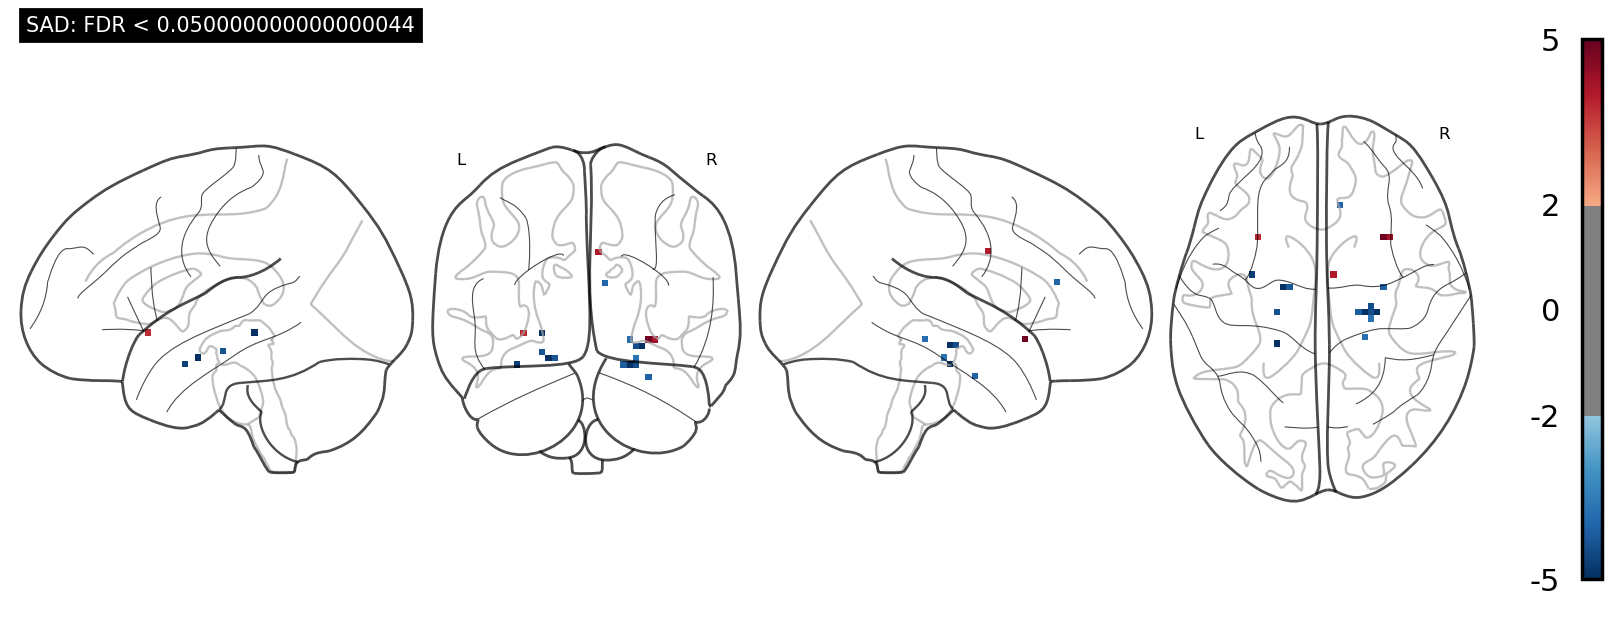


Analyzing HC...
  Estimating Weights (5000 perms)...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    9.4s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   16.7s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:   26.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:   38.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:   51.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:  1.4min


Significant Voxels: 0 (0.00%)
--- Cell 7 Complete (Spatial Results Stored) ---


[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:  1.7min


In [ ]:
# Cell 7: Voxel-wise Spatial Topology & Visualization (ROI Reconstruction)
# Context: Voxel-wise analysis using Haufe Transforms.
# Fix: Reconstructs whole-brain maps by "painting" Z-scores back into individual ROI masks.

print("--- Cell 7: Running Voxel-wise Spatial Analysis (ROI Reconstruction) ---")

# =============================================================================
# 0. Setup & Configuration
# =============================================================================
# 1. ROI Configuration
ROI_DIR = "/Users/xiaoqianxiao/tool/parcellation/Gillian_anatomically_constrained"
ROI_ORDER = [
    'left_acc', 'left_amygdala', 'left_hippocampus', 'left_insula', 'left_vmpfc',
    'right_acc', 'right_amygdala', 'right_hippocampus', 'right_insula', 'right_vmpfc'
]

# 2. Check for Results
if 'res_sad' not in locals() or 'res_hc' not in locals():
    raise ValueError("Analysis results ('res_sad', 'res_hc') not found. Please run Cell 6 first.")

# 3. Check for Data
if 'X_sad' not in locals():
    print("Loading data from 'data_subsets'...")
    try:
        d_s = data_subsets["SAD_Placebo"]["ext"]
        d_h = data_subsets["HC_Placebo"]["ext"]
        X_sad, y_sad, sub_sad = d_s["X"], d_s["y"], d_s["sub"]
        X_hc, y_hc, sub_hc = d_h["X"], d_h["y"], d_h["sub"]
    except Exception:
        raise ValueError("Data missing. Please run Cell 5.")

# 4. Config
alpha_val = thresh_hold_p if 'thresh_hold_p' in locals() else 0.05
fdr_alpha = 1 - alpha_val if alpha_val > 0.5 else alpha_val
print(f"FDR Alpha Level: {fdr_alpha}")

# =============================================================================
# 1. Helper: ROI Map Reconstruction
# =============================================================================
def reconstruct_roi_map(flat_data, roi_names, roi_dir):
    """
    Paints a 1D array of values back into a 3D brain volume by iterating 
    through the specific list of ROI masks.
    """
    # 1. Determine Reference Space (Load first mask)
    first_mask_path = glob.glob(os.path.join(roi_dir, f"*{roi_names[0]}*.nii*"))[0]
    ref_img = nib.load(first_mask_path)
    affine = ref_img.affine
    final_vol = np.zeros(ref_img.shape)
    
    current_idx = 0
    
    # 2. Iterate and Paint
    for name in roi_names:
        # Find file (handle potential suffixes like .nii or .nii.gz)
        fpaths = glob.glob(os.path.join(roi_dir, f"*{name}*.nii*"))
        if not fpaths:
            print(f"  ! Error: Mask for '{name}' not found in {roi_dir}")
            return None
        
        mask_img = nib.load(fpaths[0])
        mask_data = mask_img.get_fdata() > 0 # Boolean mask
        n_voxels = np.sum(mask_data)
        
        # Check if we have enough data left
        if current_idx + n_voxels > len(flat_data):
            print(f"  ! Error: Data mismatch. Feature vector too short for ROI {name}.")
            return None
            
        # Extract chunk and paint
        roi_values = flat_data[current_idx : current_idx + n_voxels]
        final_vol[mask_data] = roi_values # Place values in 3D space
        
        current_idx += n_voxels
        
    # Check if data was fully consumed
    if current_idx != len(flat_data):
         print(f"  ! Warning: {len(flat_data) - current_idx} features were unused (Feature vector longer than ROIs).")

    return nib.Nifti1Image(final_vol, affine)

# =============================================================================
# 2. Analysis Helper Functions (Haufe)
# =============================================================================
def compute_haufe_binary_robust(model, X):
    scores = model.decision_function(X)
    return np.dot((X - np.mean(X, axis=0)).T, scores - np.mean(scores)) / (X.shape[0] - 1)

def get_robust_weights(X, y, subjects, pipeline, n_boot=10):
    unique_subs = np.unique(subjects)
    accumulated_weights = np.zeros(X.shape[1])
    for i in range(n_boot):
        boot_subs = resample(unique_subs, replace=True, random_state=i)
        X_boot_list, y_boot_list = [], []
        for sub in boot_subs:
            mask = (subjects == sub)
            X_sub = X[mask]
            X_boot_list.append(X_sub - np.mean(X_sub, axis=0))
            y_boot_list.append(y[mask])
        X_boot = np.vstack(X_boot_list)
        y_boot = np.hstack(y_boot_list)
        
        clf = clone(pipeline)
        clf.fit(X_boot, y_boot)
        accumulated_weights += compute_haufe_binary_robust(clf, X_boot)
    return accumulated_weights / n_boot

def run_wen_paper_analysis_voxelwise(X, y, subjects, pipeline_template, best_C, n_permutations):
    print(f"  Estimating Weights ({n_permutations} perms)...")
    pipe = clone(pipeline_template); pipe.set_params(classification__C=best_C)
    obs_weights = get_robust_weights(X, y, subjects, pipe, n_boot=10)
    
    def run_null(i):
        y_shuff = shuffle(y, random_state=i)
        return get_robust_weights(X, y_shuff, subjects, pipe, n_boot=1)

    null_weights_list = Parallel(n_jobs=N_JOBS, verbose=1)(delayed(run_null)(i) for i in range(n_permutations))
    null_weights = np.array(null_weights_list)
    
    null_mean = np.mean(null_weights, axis=0)
    null_std = np.std(null_weights, axis=0)
    z_scores = (obs_weights - null_mean) / (null_std + 1e-12)
    
    n_extreme = np.sum(np.abs(null_weights) >= np.abs(obs_weights), axis=0)
    p_values = (n_extreme + 1) / (n_permutations + 1)
    reject, _, _, _ = multipletests(p_values, alpha=fdr_alpha, method='fdr_bh')
    
    return z_scores, reject

# =============================================================================
# 3. Execution
# =============================================================================
groups = {
    'SAD': {'X': X_sad, 'y': y_sad, 'sub': sub_sad, 'res': res_sad}, 
    'HC':  {'X': X_hc,  'y': y_hc,  'sub': sub_hc,  'res': res_hc}
}
target_pair = ['CSR', 'CSS']
sns.set_context("poster")

spatial_results = {}

for name, data in groups.items():
    print(f"\nAnalyzing {name}...")
    mask_cls = np.isin(data['y'], target_pair)
    X_curr = data['X'][mask_cls]
    y_curr = data['y'][mask_cls]
    sub_curr = data['sub'][mask_cls]
    X_p = subject_wise_centering(X_curr, sub_curr)
    
    # Run Analysis
    z_scores, sig_mask = run_wen_paper_analysis_voxelwise(
        X_p, y_curr, sub_curr, build_binary_pipeline(), data['res']['best_C'], N_PERMUTATION
    )
    
    # Direction correction (Ensure CSR is positive)
    dummy_pipe = build_binary_pipeline(); dummy_pipe.fit(X_p, y_curr)
    if dummy_pipe.classes_[0] == 'CSR': z_scores = -z_scores
    
    spatial_results[f"{name} Placebo"] = {'z_scores': z_scores, 'sig_mask': sig_mask}
    
    n_sig = np.sum(sig_mask)
    print(f"Significant Voxels: {n_sig} ({(n_sig/len(z_scores))*100:.2f}%)")
    
    # VISUALIZATION (Reconstruct Map)
    if n_sig > 0:
        try:
            # Mask Z-scores
            z_masked = z_scores * sig_mask
            
            # Reconstruct 3D Nifti from 1D array using ROI list
            print("  > Reconstructing 3D map from ROI masks...")
            z_img = reconstruct_roi_map(z_masked, ROI_ORDER, ROI_DIR)
            
            if z_img is not None:
                fig = plt.figure(figsize=(16, 6))
                plotting.plot_glass_brain(
                    z_img, 
                    threshold=1.96, 
                    plot_abs=False, 
                    display_mode='lyrz', 
                    colorbar=True, 
                    vmin=-5, vmax=5, 
                    cmap='RdBu_r', 
                    title=f"{name}: FDR < {fdr_alpha}", 
                    figure=fig
                )
                plt.show()
                
        except Exception as e:
            print(f"  ! Visualization failed: {e}")
            import traceback
            traceback.print_exc()

print("--- Cell 7 Complete (Spatial Results Stored) ---")

In [ ]:
# Cell 8: Feature Importance (Permutation) & Mask Generation
# Objective: Identify task-relevant voxels/regions using Permutation Importance.
# Context: Used as the primary feature selector for downstream analysis (Cell 9 & 10).

print("--- Cell 8: Generating Permutation Importance Masks ---")
# =============================================================================
# 0. Setup & Dependency Checks
# =============================================================================
# 1. Check for Results (Models) from Cell 6
if 'res_sad' not in locals() or 'res_hc' not in locals():
    raise ValueError("Models ('res_sad', 'res_hc') not found. Please run Cell 6 first.")

# 2. Check for Data (Global or Nested)
# We ensure X_sad/X_hc are available, reloading from data_subsets if necessary.
if 'X_sad' not in locals():
    print("  > Reloading extinction data from 'data_subsets'...")
    try:
        X_sad = data_subsets["SAD_Placebo"]["ext"]["X"]
        y_sad = data_subsets["SAD_Placebo"]["ext"]["y"]
        sub_sad = data_subsets["SAD_Placebo"]["ext"]["sub"]
        
        X_hc = data_subsets["HC_Placebo"]["ext"]["X"]
        y_hc = data_subsets["HC_Placebo"]["ext"]["y"]
        sub_hc = data_subsets["HC_Placebo"]["ext"]["sub"]
    except (KeyError, TypeError):
        raise ValueError("Data missing. Please run Cell 5 (Data Prep).")

# 3. Check for ROI Labels
if 'parcel_names_ext' not in locals():
    print("  ! WARNING: 'parcel_names_ext' not found. Using generic feature indices for plotting.")
    parcel_names_ext = [f"Feat_{i}" for i in range(X_sad.shape[1])]

# Settings
target_pair = ['CSR', 'CSS']
n_repeats = 100 # Number of permutation iterations for importance
importance_masks = {}
importance_scores = {}

# =============================================================================
# 1. Compute Importance for SAD
# =============================================================================
print("1. Computing Importance for SAD Placebo...")

# Slice Data (CSR vs CSS only)
mask_sad = np.isin(y_sad, target_pair)
X_sad_p = subject_wise_centering(X_sad[mask_sad], sub_sad[mask_sad])
y_sad_p = y_sad[mask_sad]

# Compute Importance
# Returns mean importance decrease per feature
# Uses helper from Cell 4: compute_perm_importance_simple(model, X, y, n_repeats)
imp_sad_mean = compute_perm_importance_simple(res_sad['model'], X_sad_p, y_sad_p, n_repeats=n_repeats)

# Define Mask: Select voxels that positively contribute to accuracy (> 0)
mask_sad_sig = imp_sad_mean > 0
importance_masks['SAD'] = mask_sad_sig
importance_scores['SAD'] = imp_sad_mean

print(f"   > SAD: Found {np.sum(mask_sad_sig)} predictive voxels (Imp > 0).")

# =============================================================================
# 2. Compute Importance for HC
# =============================================================================
print("2. Computing Importance for HC Placebo...")

# Slice Data
mask_hc = np.isin(y_hc, target_pair)
X_hc_p = subject_wise_centering(X_hc[mask_hc], sub_hc[mask_hc])
y_hc_p = y_hc[mask_hc]

# Compute Importance
imp_hc_mean = compute_perm_importance_simple(res_hc['model'], X_hc_p, y_hc_p, n_repeats=n_repeats)

# Define Mask
mask_hc_sig = imp_hc_mean > 0
importance_masks['HC'] = mask_hc_sig
importance_scores['HC'] = imp_hc_mean

print(f"   > HC:  Found {np.sum(mask_hc_sig)} predictive voxels (Imp > 0).")

# =============================================================================
# 3. Visualization (River Plot)
# =============================================================================
print("3. Generating River Plot...")

# Prepare dictionary for plotting function
plot_data = {
    'SAD Placebo': imp_sad_mean,
    'HC Placebo': imp_hc_mean
}

# Use the helper function from Cell 4
# Assumes make_river_plot_importance handles the figure creation
try:
    make_river_plot_importance(
        plot_data,
        parcel_names_ext,
        top_k=20,  # Show top 20 most important features per group
        title="Neural Signatures (Permutation Importance)"
    )
except Exception as e:
    print(f"  ! Visualization skipped due to error: {e}")

print("Cell 8: Importance masks generated and stored in 'importance_masks'.")

--- Cell 8: Generating Permutation Importance Masks ---
1. Computing Importance for SAD Placebo...
   > SAD: Found 31 predictive voxels (Imp > 0).
2. Computing Importance for HC Placebo...
   > HC:  Found 1394 predictive voxels (Imp > 0).
3. Generating River Plot...
Cell 8: Importance masks generated and stored in 'importance_masks'.


--- Running Analysis 1.2: Static Representational Topology (Top 5% | Centroid) ---

[Step 0] Selecting Top 5% Neural Features...
  > SAD Top 5% Network: 31 voxels (Threshold: 0.00000)
  > HC Top 5% Network:  108 voxels (Threshold: 0.00183)

[Step 1] Preparing Centroid Data...
  > SAD Matrix (Top 5%): (552, 31) | HC Matrix (Top 5%): (672, 108)
  Calculating Centroid RDMs (Conditions: ['CS-', 'CSS', 'CSR'])...
  > Computed RDMs: SAD (n=23), HC (n=28)

[Step 3] Statistical Testing...

Metric A: Threat (CSR) vs Safety (CSS) Distance
  > SAD (Dist > 0): Mean=1.584, t=31.267, p=0.0000 (*)
  > HC  (Dist > 0): Mean=1.488, t=33.136, p=0.0000 (*)
  > Group Comparison (SAD vs HC):
    Diff: SAD=1.584, HC=1.488 | t=1.421, p=0.1658

Metric B: Safety (CSS) vs Background (CS-) Distance
  > SAD (Dist > 0): Mean=1.370, t=21.385, p=0.0000 (*)
  > HC  (Dist > 0): Mean=1.402, t=23.658, p=0.0000 (*)
  > Group Comparison (SAD vs HC):
    Diff: SAD=1.370, HC=1.402 | t=-0.369, p=0.7114


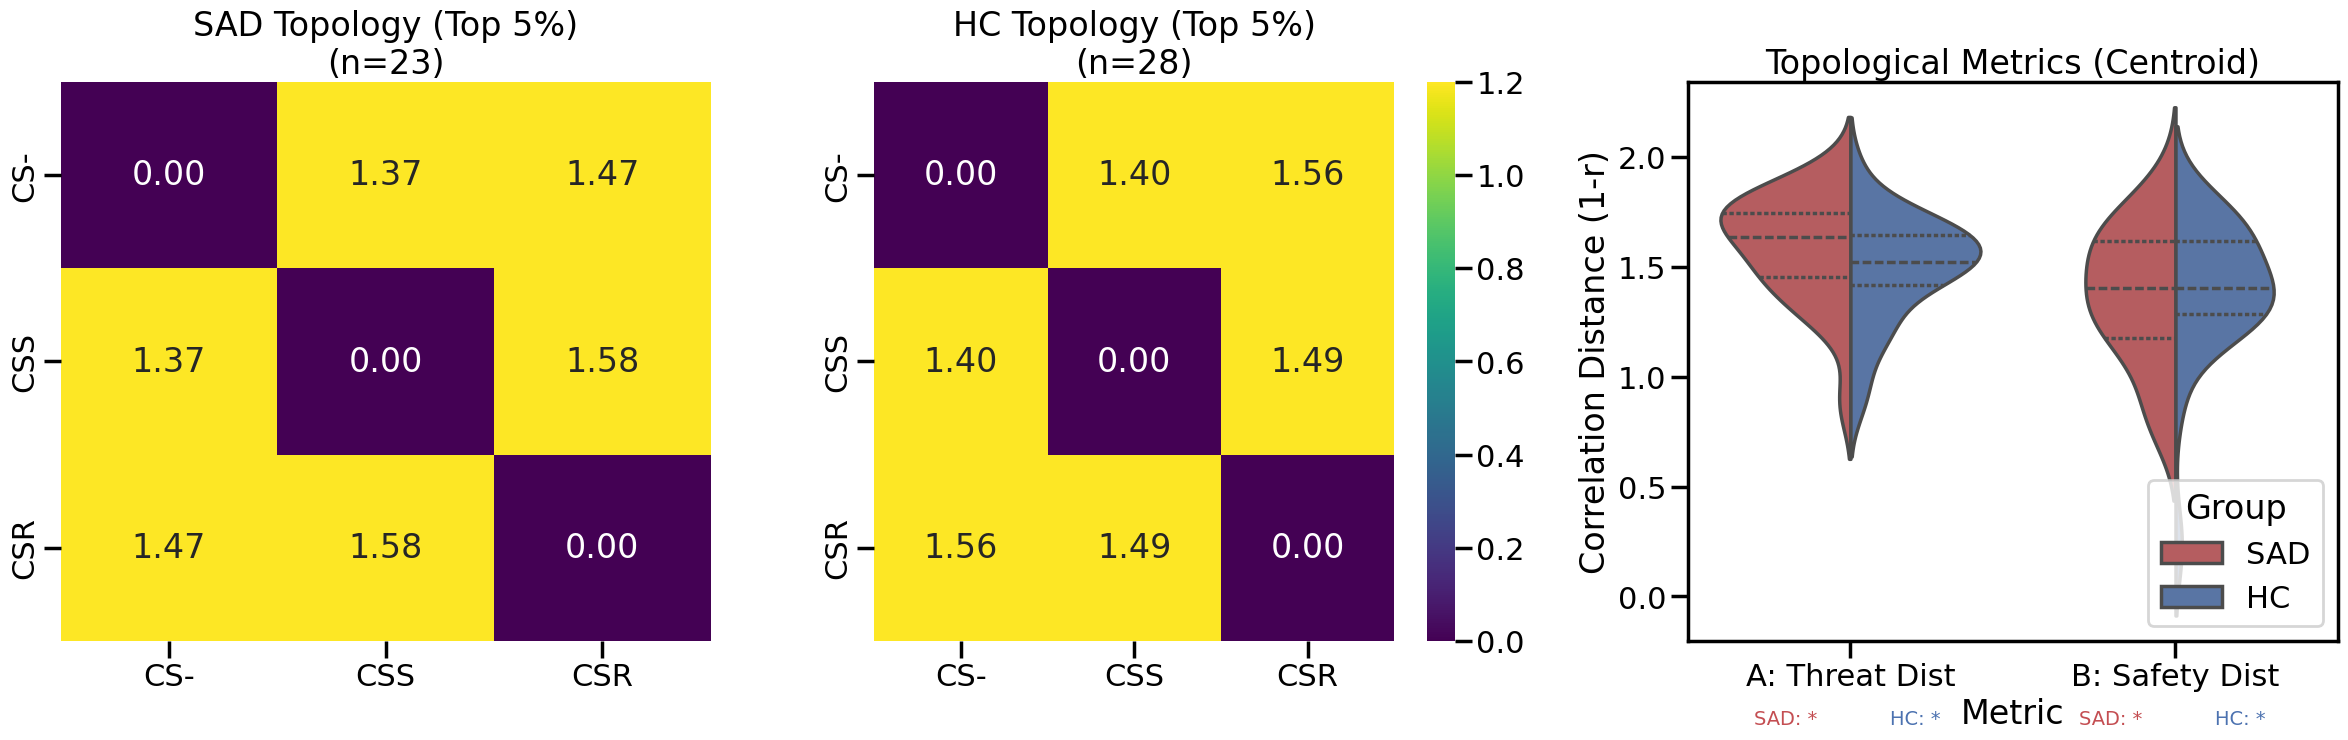

In [ ]:
# Cell 9: Analysis 1.2 - Static Representational Topology (Top 5% | Centroid)
# Objective: Characterize the stable organization of the social learning space.
# Constraint: Top 5% most predictive features per group.
# Method: Centroid-based Correlation Distance (1 - Pearson r).
# Tests: Group Comparison (SAD vs HC) AND One-Sample Test (Dist > 0).

print("--- Running Analysis 1.2: Static Representational Topology (Top 5% | Centroid) ---")

from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_1samp

# Global Constants
RDM_CONDITIONS = ["CS-", "CSS", "CSR"] 
PERCENTILE_THRESH = 95  # Top 5%

# =============================================================================
# 0. Feature Selection (Top 5%)
# =============================================================================
print(f"\n[Step 0] Selecting Top {100-PERCENTILE_THRESH}% Neural Features...")

if 'importance_scores' not in locals() or not importance_scores:
    raise ValueError("Importance scores not found! Please run Cell 8 first.")

def get_top_percentile_mask(scores, percentile):
    thresh = np.percentile(scores, percentile)
    mask = scores >= thresh
    mask = mask & (scores > 0) # Ensure positive contribution
    return mask, thresh

scores_sad = importance_scores['SAD']
mask_sad_top5, thresh_sad = get_top_percentile_mask(scores_sad, PERCENTILE_THRESH)

scores_hc = importance_scores['HC']
mask_hc_top5, thresh_hc = get_top_percentile_mask(scores_hc, PERCENTILE_THRESH)

print(f"  > SAD Top 5% Network: {np.sum(mask_sad_top5)} voxels (Threshold: {thresh_sad:.5f})")
print(f"  > HC Top 5% Network:  {np.sum(mask_hc_top5)} voxels (Threshold: {thresh_hc:.5f})")

# =============================================================================
# 1. Data Preparation (Recovering CS-)
# =============================================================================
print("\n[Step 1] Preparing Centroid Data...")

# Validate Source Data
if 'X_ext' not in locals() or 'y_ext' not in locals():
    raise ValueError("Global 'X_ext' variables missing. Cannot retrieve CS- trials (Cell 5 filtered them out).")

# Retrieve Subject Lists from the Nested Dictionary (created in Cell 5)
# structure: data_subsets['Group']['ext']['sub']
try:
    known_hc = np.unique(data_subsets["HC_Placebo"]["ext"]["sub"])
    known_sad = np.unique(data_subsets["SAD_Placebo"]["ext"]["sub"])
except (KeyError, TypeError):
    raise ValueError("Data structure mismatch. Ensure Cell 5 generated 'data_subsets' with ['ext'] keys.")

# Create a temporary group mapping array matching the global X_ext
group_ext = np.array(["Unknown"] * len(sub_ext), dtype=object)
group_ext[np.isin(sub_ext, known_hc)] = "HC"
group_ext[np.isin(sub_ext, known_sad)] = "SAD"

# Filter Global Data for RDM Conditions
mask_conds = np.isin(y_ext, RDM_CONDITIONS)
X_raw = X_ext[mask_conds]
y_raw = y_ext[mask_conds]
sub_raw = sub_ext[mask_conds]
grp_raw = group_ext[mask_conds]

# Split by Group
mask_sad_grp = (grp_raw == "SAD")
mask_hc_grp = (grp_raw == "HC")

# Slice Features (Apply the Top 5% Masks)
X_sad_12 = X_raw[mask_sad_grp][:, mask_sad_top5]
y_sad_12 = y_raw[mask_sad_grp]
sub_sad_12 = sub_raw[mask_sad_grp]

X_hc_12 = X_raw[mask_hc_grp][:, mask_hc_top5]
y_hc_12 = y_raw[mask_hc_grp]
sub_hc_12 = sub_raw[mask_hc_grp]

print(f"  > SAD Matrix (Top 5%): {X_sad_12.shape} | HC Matrix (Top 5%): {X_hc_12.shape}")

# =============================================================================
# 2. Centroid RDM Calculation
# =============================================================================
def calculate_centroid_rdm(X, y, subjects, conditions):
    unique_subs = np.unique(subjects); rdms = []; sub_ids = []
    
    for sub in unique_subs:
        mask_sub = (subjects == sub)
        X_sub = X[mask_sub]
        y_sub = y[mask_sub]
        
        centroids = []
        valid = True
        for cond in conditions:
            mask_cond = (y_sub == cond)
            if np.sum(mask_cond) == 0: 
                valid = False
                break
            # Calculate Centroid
            centroids.append(np.mean(X_sub[mask_cond], axis=0))
            
        if valid:
            # Correlation Distance (1-r)
            # pdist returns condensed distance matrix, squareform makes it N x N
            rdm = squareform(pdist(np.array(centroids), metric='correlation'))
            rdms.append(rdm)
            sub_ids.append(sub)
            
    return np.array(rdms), np.array(sub_ids)

# Apply Subject-Wise Centering (Crucial for correlation distance stability)
X_sad_12 = subject_wise_centering(X_sad_12, sub_sad_12)
X_hc_12 = subject_wise_centering(X_hc_12, sub_hc_12)

# Compute RDMs
print(f"  Calculating Centroid RDMs (Conditions: {RDM_CONDITIONS})...")
rdms_sad, subs_sad_rdm = calculate_centroid_rdm(X_sad_12, y_sad_12, sub_sad_12, RDM_CONDITIONS)
rdms_hc, subs_hc_rdm = calculate_centroid_rdm(X_hc_12, y_hc_12, sub_hc_12, RDM_CONDITIONS)

print(f"  > Computed RDMs: SAD (n={len(subs_sad_rdm)}), HC (n={len(subs_hc_rdm)})")

# =============================================================================
# 3. Metrics & Statistical Tests
# =============================================================================
# Conditions: 0=CS-, 1=CSS, 2=CSR
idx_cs_minus, idx_css, idx_csr = 0, 1, 2

def extract_metrics(rdms):
    # Metric A: Threat (CSR) vs Safety (CSS)
    m_a = rdms[:, idx_csr, idx_css] 
    # Metric B: Safety (CSS) vs Baseline (CS-)
    m_b = rdms[:, idx_css, idx_cs_minus] 
    return m_a, m_b

vec_a_sad, vec_b_sad = extract_metrics(rdms_sad)
vec_a_hc, vec_b_hc = extract_metrics(rdms_hc)

print("\n[Step 3] Statistical Testing...")

# --- Helper for One-Sample Test (Significantly > 0?) ---
def one_sample_test(data, name):
    # Test if distance is greater than 0
    t_val, p_val = ttest_1samp(data, 0, alternative='greater')
    sig = "*" if p_val < 0.05 else "ns"
    print(f"  > {name}: Mean={np.mean(data):.3f}, t={t_val:.3f}, p={p_val:.4f} ({sig})")
    return p_val

# Metric A: Threat Distance (The Canyon)
print("\nMetric A: Threat (CSR) vs Safety (CSS) Distance")
p_a_sad_0 = one_sample_test(vec_a_sad, "SAD (Dist > 0)")
p_a_hc_0 = one_sample_test(vec_a_hc, "HC  (Dist > 0)")

print("  > Group Comparison (SAD vs HC):")
t_a, p_a, m_a_sad, m_a_hc = perm_ttest_ind(vec_a_sad, vec_a_hc, n_perm=N_PERMUTATION)
print(f"    Diff: SAD={m_a_sad:.3f}, HC={m_a_hc:.3f} | t={t_a:.3f}, p={p_a:.4f}")

# Metric B: Safety Distance (The Collapse)
print("\nMetric B: Safety (CSS) vs Background (CS-) Distance")
p_b_sad_0 = one_sample_test(vec_b_sad, "SAD (Dist > 0)")
p_b_hc_0 = one_sample_test(vec_b_hc, "HC  (Dist > 0)")

print("  > Group Comparison (SAD vs HC):")
t_b, p_b, m_b_sad, m_b_hc = perm_ttest_ind(vec_b_sad, vec_b_hc, n_perm=N_PERMUTATION)
print(f"    Diff: SAD={m_b_sad:.3f}, HC={m_b_hc:.3f} | t={t_b:.3f}, p={p_b:.4f}")

# =============================================================================
# 4. Visualization
# =============================================================================
sns.set_context("poster")
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1, 3)

# Heatmaps
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(np.mean(rdms_sad, axis=0), annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1.2, 
            xticklabels=RDM_CONDITIONS, yticklabels=RDM_CONDITIONS, ax=ax1, cbar=False)
ax1.set_title(f"SAD Topology (Top 5%)\n(n={len(subs_sad_rdm)})")

ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(np.mean(rdms_hc, axis=0), annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1.2,
            xticklabels=RDM_CONDITIONS, yticklabels=RDM_CONDITIONS, ax=ax2)
ax2.set_title(f"HC Topology (Top 5%)\n(n={len(subs_hc_rdm)})")

# Violins
ax3 = fig.add_subplot(gs[0, 2])
df_res = pd.DataFrame({
    'Group': ['SAD']*len(vec_a_sad) + ['HC']*len(vec_a_hc) + ['SAD']*len(vec_b_sad) + ['HC']*len(vec_b_hc),
    'Distance': np.concatenate([vec_a_sad, vec_a_hc, vec_b_sad, vec_b_hc]),
    'Metric': ['A: Threat Dist']*len(vec_a_sad) + ['A: Threat Dist']*len(vec_a_hc) + 
              ['B: Safety Dist']*len(vec_b_sad) + ['B: Safety Dist']*len(vec_b_hc)
})
sns.violinplot(data=df_res, x='Metric', y='Distance', hue='Group', 
               split=True, inner='quartile', palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, ax=ax3)
ax3.set_title("Topological Metrics (Centroid)")
ax3.set_ylabel("Correlation Distance (1-r)")

# Annotate Group Differences
y_max = df_res['Distance'].max()
if p_a < 0.05: ax3.text(0, y_max + 0.05, f'* (p={p_a:.3f})', ha='center', fontsize=18)
if p_b < 0.05: ax3.text(1, y_max + 0.05, f'* (p={p_b:.3f})', ha='center', fontsize=18)

# Annotate Sig > 0 (Below X Axis)
def get_sig_star(p): return "*" if p < 0.05 else "ns"

# For Metric A
ax3.text(-0.2, -0.15, f"SAD: {get_sig_star(p_a_sad_0)}", transform=ax3.get_xaxis_transform(), ha='center', fontsize=14, color='#c44e52')
ax3.text(0.2, -0.15, f"HC: {get_sig_star(p_a_hc_0)}", transform=ax3.get_xaxis_transform(), ha='center', fontsize=14, color='#4c72b0')

# For Metric B
ax3.text(0.8, -0.15, f"SAD: {get_sig_star(p_b_sad_0)}", transform=ax3.get_xaxis_transform(), ha='center', fontsize=14, color='#c44e52')
ax3.text(1.2, -0.15, f"HC: {get_sig_star(p_b_hc_0)}", transform=ax3.get_xaxis_transform(), ha='center', fontsize=14, color='#4c72b0')

plt.tight_layout()
plt.show()

# Store Results
results_12 = {
    "rdms_sad": rdms_sad, "rdms_hc": rdms_hc, 
    "metric_a_stats": (t_a, p_a), "metric_b_stats": (t_b, p_b),
    "features_sad": np.sum(mask_sad_top5), "features_hc": np.sum(mask_hc_top5),
    "one_sample_stats": {"p_a_sad": p_a_sad_0, "p_a_hc": p_a_hc_0, "p_b_sad": p_b_sad_0, "p_b_hc": p_b_hc_0}
}

--- Running Analysis 1.3: Dynamic Representational Drift (Top 5% Features) ---

[Step 0] Setup & Data Loading...
  > SAD Top 5% Network: 31 voxels (Thresh=0.0000)
  > HC Top 5% Network:  108 voxels (Thresh=0.0018)

[Step 2] Calculating Vectors...
  > Safety Analysis: Start=CSS(Ext) -> Target=CS-(Ext)
  > Threat Analysis: Start=CSR(Ext) -> Target=CSR(Reinstatement)

[Step 3] Generated 101 subject vectors.

--- Statistical Summary (SAD vs HC) ---

Condition: Safety
  > SAD > 0 (projection): t=7.540, p=0.0000
  > HC  > 0 (projection): t=10.939, p=0.0000
  > Group Diff (projection): t=-2.874, p=0.0060 *
  > SAD > 0 (cosine): t=24.141, p=0.0000
  > HC  > 0 (cosine): t=15.250, p=0.0000
  > Group Diff (cosine): t=2.235, p=0.0300 *

Condition: Threat
  > SAD > 0 (projection): t=6.337, p=0.0000
  > HC  > 0 (projection): t=4.496, p=0.0001
  > Group Diff (projection): t=-2.917, p=0.0054 *
  > SAD > 0 (cosine): t=9.407, p=0.0000
  > HC  > 0 (cosine): t=24.210, p=0.0000
  > Group Diff (cosine): t=-

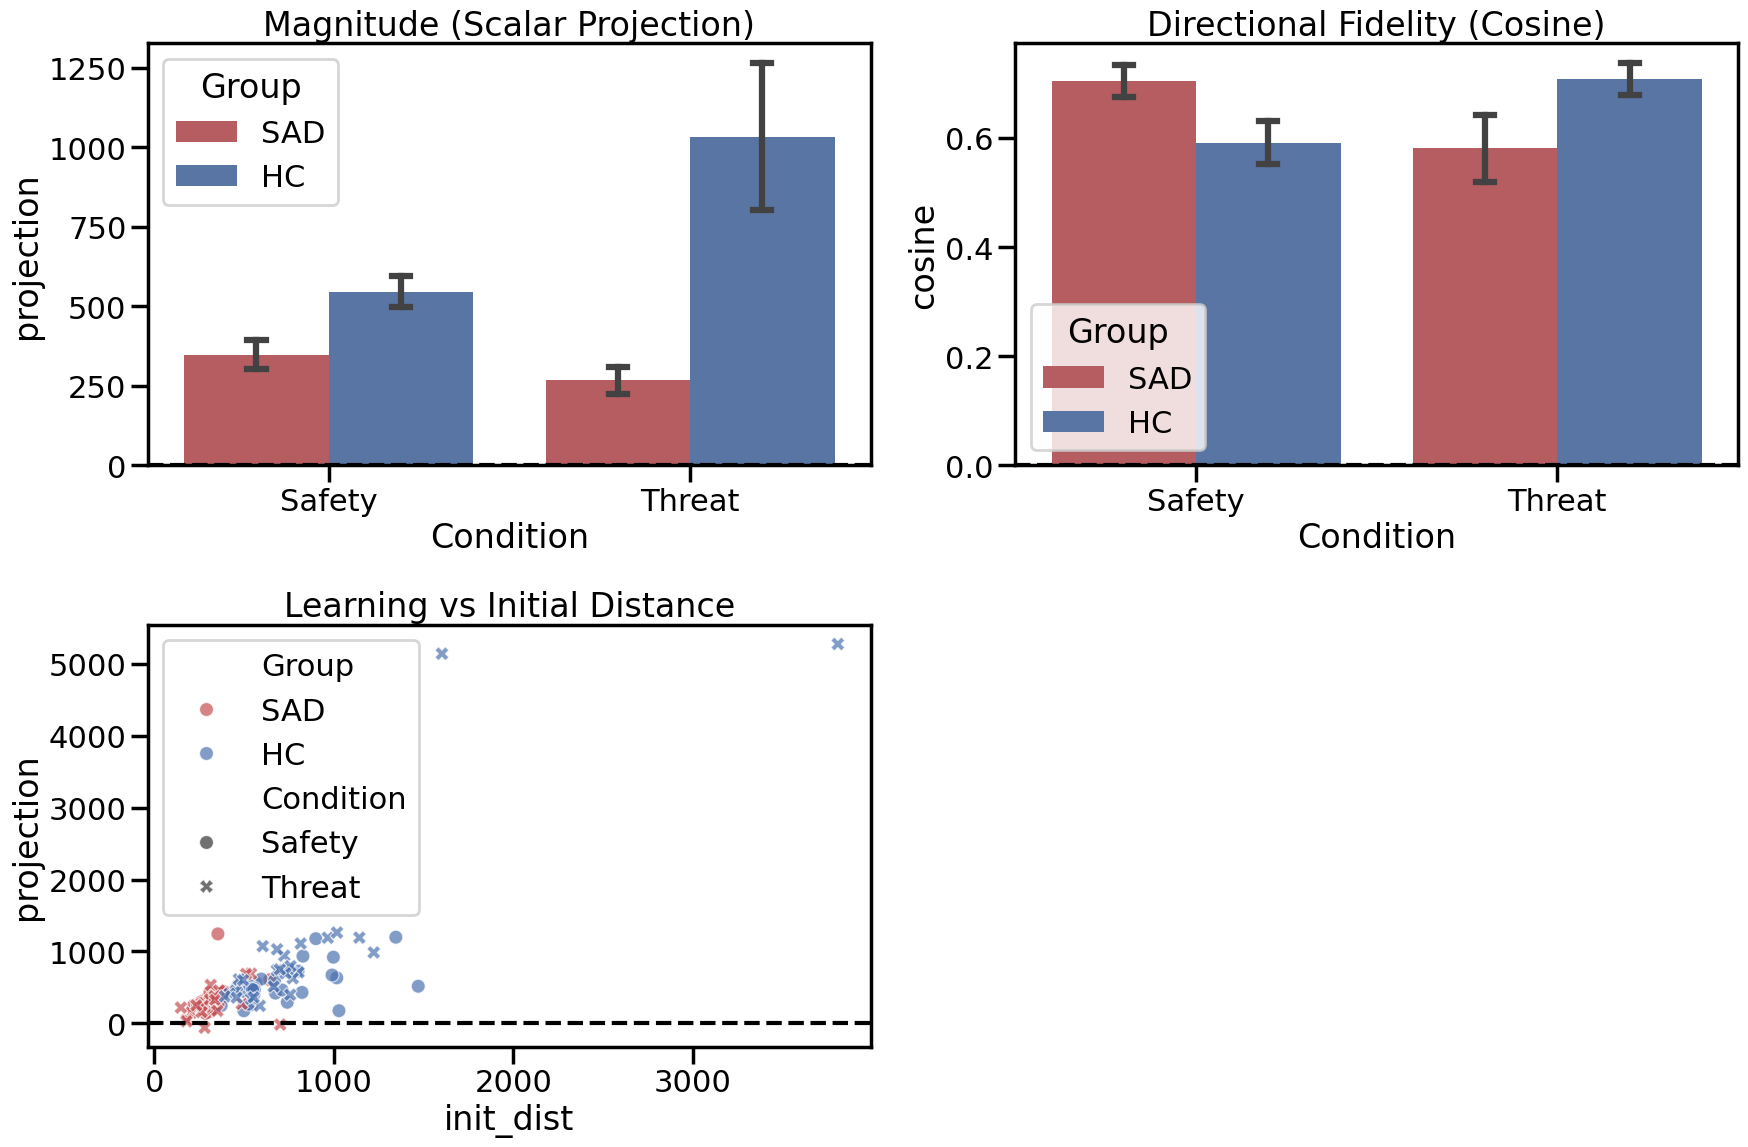

In [ ]:
# Cell 10: Analysis 1.3 - Dynamic Representational Drift (Top 5% Features)
# Objective: Quantify plasticity magnitude (Projection) and fidelity (Cosine).
# Target Definitions:
#   - Safety:  Extinction CSS -> Extinction CS-
#   - Threat:  Extinction CSR -> Reinstatement CSR
# Feature Selection: Top 5% Importance (Permutation Scores)

print("--- Running Analysis 1.3: Dynamic Representational Drift (Top 5% Features) ---")

import pandas as pd
import statsmodels.api as sm
from numpy.linalg import norm
from scipy.stats import ttest_1samp, ttest_ind, levene, shapiro, mannwhitneyu

# Constants
COND_SAFETY_TARGET = "CS-"
COND_SAFETY_LEARN = "CSS"
COND_THREAT_LEARN = "CSR"
PERCENTILE_THRESH = 95  # Top 5% Selection

# =============================================================================
# 0. Feature Selection & Data Loading
# =============================================================================
print(f"\n[Step 0] Setup & Data Loading...")

if 'importance_scores' not in locals(): 
    raise ValueError("Run Cell 8 first.")

# 1. Select Top 5% Features
def get_top_percentile_mask(scores, percentile):
    thresh = np.percentile(scores, percentile)
    mask = (scores >= thresh) & (scores > 0) # Ensure strictly positive & top tier
    return mask, thresh

mask_sad, t_sad = get_top_percentile_mask(importance_scores['SAD'], PERCENTILE_THRESH)
mask_hc, t_hc = get_top_percentile_mask(importance_scores['HC'], PERCENTILE_THRESH)

print(f"  > SAD Top 5% Network: {np.sum(mask_sad)} voxels (Thresh={t_sad:.4f})")
print(f"  > HC Top 5% Network:  {np.sum(mask_hc)} voxels (Thresh={t_hc:.4f})")

# 2. Load Data Helpers (Nested Dictionary Access)
def get_phase_data(group, phase):
    try:
        d = data_subsets[group][phase]
        if d is None: return None, None, None
        return d["X"], d["y"], d["sub"]
    except KeyError:
        return None, None, None

# Load Extinction (Start/Learning Phase)
X_ext_sad, y_ext_sad, sub_ext_sad = get_phase_data("SAD_Placebo", "ext")
X_ext_hc, y_ext_hc, sub_ext_hc = get_phase_data("HC_Placebo", "ext")

# Load Reinstatement (Target Phase for Threat)
X_rst_sad, y_rst_sad, sub_rst_sad = get_phase_data("SAD_Placebo", "rst")
X_rst_hc, y_rst_hc, sub_rst_hc = get_phase_data("HC_Placebo", "rst")

# Validate Reinstatement Data
if X_rst_sad is None or X_rst_hc is None:
    print("  ! WARNING: Reinstatement data missing. Threat analysis will fallback to Extinction (Trivial).")
    X_rst_sad, y_rst_sad, sub_rst_sad = X_ext_sad, y_ext_sad, sub_ext_sad
    X_rst_hc, y_rst_hc, sub_rst_hc = X_ext_hc, y_ext_hc, sub_ext_hc

# Handle CS- (Safety Target) - likely missing from subsets, need global X_ext
if 'X_ext' in locals():
    X_global, y_global, sub_global = X_ext, y_ext, sub_ext
else:
    print("  ! WARNING: Global X_ext missing. Safety Target (CS-) might be unavailable.")
    X_global, y_global, sub_global = X_ext_sad, y_ext_sad, sub_ext_sad

# =============================================================================
# 1. Vector Calculation Helper (Cross-Phase Support)
# =============================================================================
def calculate_plasticity_vectors(
    X_learn, y_learn, sub_learn,   # Data for Learning Trajectory (Start -> End)
    X_targ, y_targ, sub_targ,      # Data for Target Definition
    feature_mask, 
    cond_learn,                    # Condition changing (e.g., CSS or CSR)
    cond_target_label              # Label of the target (e.g., CS- or CSR)
):
    """
    Calculates projection of learning (in X_learn) onto axis towards Target (in X_targ).
    """
    # 1. Apply Feature Mask & Centering
    # Note: Center phases separately to remove global session shifts (drift correction)
    X_L = subject_wise_centering(X_learn[:, feature_mask], sub_learn)
    X_T = subject_wise_centering(X_targ[:, feature_mask], sub_targ)
    
    unique_subs = np.intersect1d(np.unique(sub_learn), np.unique(sub_targ))
    res = {'sub': [], 'projection': [], 'cosine': [], 'init_dist': []}
    
    for sub in unique_subs:
        # Slice Learning Data (The Drift)
        m_l = (sub_learn == sub); xl = X_L[m_l]; yl = y_learn[m_l]
        
        # Slice Target Data (The Goal)
        m_t = (sub_targ == sub); xt = X_T[m_t]; yt = y_targ[m_t]
        
        # A. Define Target Centroid (P_target)
        mask_tgt_cond = (yt == cond_target_label)
        if np.sum(mask_tgt_cond) == 0: continue
        P_target = np.mean(xt[mask_tgt_cond], axis=0)
        
        # B. Define Start & End (Learning Phase)
        mask_lrn_cond = (yl == cond_learn)
        idx_lrn = np.where(mask_lrn_cond)[0]
        if len(idx_lrn) < 2: continue
        
        cutoff = len(idx_lrn) // 2
        # Early Learning
        P_start = np.mean(xl[idx_lrn[:cutoff]], axis=0)
        # Late Learning
        P_end = np.mean(xl[idx_lrn[cutoff:]], axis=0)
        
        # C. Define Vectors
        # Axis: From Start (Ext) -> Target (Reinstatement or CS-)
        V_axis = P_target - P_start
        # Drift: Actual change during learning
        V_drift = P_end - P_start
        
        norm_axis = norm(V_axis)
        norm_drift = norm(V_drift)
        
        if norm_axis == 0 or norm_drift == 0: continue
        
        dot_prod = np.dot(V_drift, V_axis)
        
        # Scalar Projection (Magnitude)
        projection = dot_prod / norm_axis
        
        # Cosine Similarity (Fidelity)
        cosine = dot_prod / (norm_drift * norm_axis)
        
        res['sub'].append(sub)
        res['projection'].append(projection)
        res['cosine'].append(cosine)
        res['init_dist'].append(norm_axis)
        
    return pd.DataFrame(res)

# =============================================================================
# 2. Execution
# =============================================================================
print("\n[Step 2] Calculating Vectors...")

# A. Safety Learning (CSS -> CS-)
# Both Start and Target are in Extinction (or Global)
print("  > Safety Analysis: Start=CSS(Ext) -> Target=CS-(Ext)")
df_safe_sad = calculate_plasticity_vectors(
    X_ext_sad, y_ext_sad, sub_ext_sad,     # Learn: Extinction
    X_global, y_global, sub_global,        # Target: Global (contains CS-)
    mask_sad, COND_SAFETY_LEARN, COND_SAFETY_TARGET
)
df_safe_hc = calculate_plasticity_vectors(
    X_ext_hc, y_ext_hc, sub_ext_hc, 
    X_global, y_global, sub_global, 
    mask_hc, COND_SAFETY_LEARN, COND_SAFETY_TARGET
)

# B. Threat Maintenance (CSR -> Reinstatement CSR)
# Start is Extinction, Target is REINSTATEMENT
print("  > Threat Analysis: Start=CSR(Ext) -> Target=CSR(Reinstatement)")
df_threat_sad = calculate_plasticity_vectors(
    X_ext_sad, y_ext_sad, sub_ext_sad,     # Learn: Extinction
    X_rst_sad, y_rst_sad, sub_rst_sad,     # Target: Reinstatement
    mask_sad, COND_THREAT_LEARN, COND_THREAT_LEARN 
)
df_threat_hc = calculate_plasticity_vectors(
    X_ext_hc, y_ext_hc, sub_ext_hc, 
    X_rst_hc, y_rst_hc, sub_rst_hc, 
    mask_hc, COND_THREAT_LEARN, COND_THREAT_LEARN
)

# =============================================================================
# 3. Statistics & Visualization
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Combine for plotting
def tag_df(df, grp, cond):
    if df.empty: return df
    d = df.copy(); d['Group'] = grp; d['Condition'] = cond
    return d

df_plot = pd.concat([
    tag_df(df_safe_sad, 'SAD', 'Safety'), tag_df(df_safe_hc, 'HC', 'Safety'),
    tag_df(df_threat_sad, 'SAD', 'Threat'), tag_df(df_threat_hc, 'HC', 'Threat')
])

if df_plot.empty:
    print("! No data generated. Check inputs.")
else:
    print(f"\n[Step 3] Generated {len(df_plot)} subject vectors.")
    
    sns.set_context("poster")
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Projection (Magnitude)
    sns.barplot(data=df_plot, x='Condition', y='projection', hue='Group', 
                palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, ax=axes[0,0], 
                capsize=.1, errorbar='se')
    axes[0,0].axhline(0, color='k', ls='--')
    axes[0,0].set_title("Magnitude (Scalar Projection)")
    
    # 2. Cosine (Fidelity)
    sns.barplot(data=df_plot, x='Condition', y='cosine', hue='Group', 
                palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, ax=axes[0,1], 
                capsize=.1, errorbar='se')
    axes[0,1].axhline(0, color='k', ls='--')
    axes[0,1].set_title("Directional Fidelity (Cosine)")
    
    # 3. Stats (Printout)
    print("\n--- Statistical Summary (SAD vs HC) ---")
    for cond in ['Safety', 'Threat']:
        print(f"\nCondition: {cond}")
        for met in ['projection', 'cosine']:
            d_s = df_plot[(df_plot['Condition']==cond) & (df_plot['Group']=='SAD')][met]
            d_h = df_plot[(df_plot['Condition']==cond) & (df_plot['Group']=='HC')][met]
            
            # One-sample t-test (vs 0)
            if len(d_s)>1: 
                t0_s, p0_s = ttest_1samp(d_s, 0, alternative='greater')
                print(f"  > SAD > 0 ({met}): t={t0_s:.3f}, p={p0_s:.4f}")
            if len(d_h)>1:
                t0_h, p0_h = ttest_1samp(d_h, 0, alternative='greater')
                print(f"  > HC  > 0 ({met}): t={t0_h:.3f}, p={p0_h:.4f}")

            # Group Diff
            if len(d_s)>1 and len(d_h)>1:
                t, p = ttest_ind(d_s, d_h)
                sig = "*" if p < 0.05 else "ns"
                print(f"  > Group Diff ({met}): t={t:.3f}, p={p:.4f} {sig}")

    # 4. Scatter (Init Dist vs Projection)
    sns.scatterplot(data=df_plot, x='init_dist', y='projection', hue='Group', style='Condition', 
                    palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, alpha=0.7, ax=axes[1,0], s=100)
    axes[1,0].axhline(0, color='k', ls='--')
    axes[1,0].set_title("Learning vs Initial Distance")
    
    axes[1,1].axis('off') # Empty slot
    plt.tight_layout()
    plt.show()

results_13 = {'safe_sad': df_safe_sad, 'threat_sad': df_threat_sad}

--- Running Analysis 1.3: Single-Trial Trajectories (Top 5%) ---

[Step 0] Selecting Top 5% Features...
  > SAD Top 5%: 31 voxels (Thresh: 0.0000)
  > HC Top 5%:  108 voxels (Thresh: 0.0018)

[Step 2] Calculating Single-Trial Trajectories...
  > Safety: CSS Trials projecting onto [Early CSS -> CS-]
  > Threat: CSR Trials projecting onto [Early CSR -> Reinstated CSR]

[Step 3] Calculating Statistics...

--- Statistics: Safety Learning ---
No significant group differences found (FDR corrected).

--- Statistics: Threat Maintenance ---
No significant group differences found (FDR corrected).


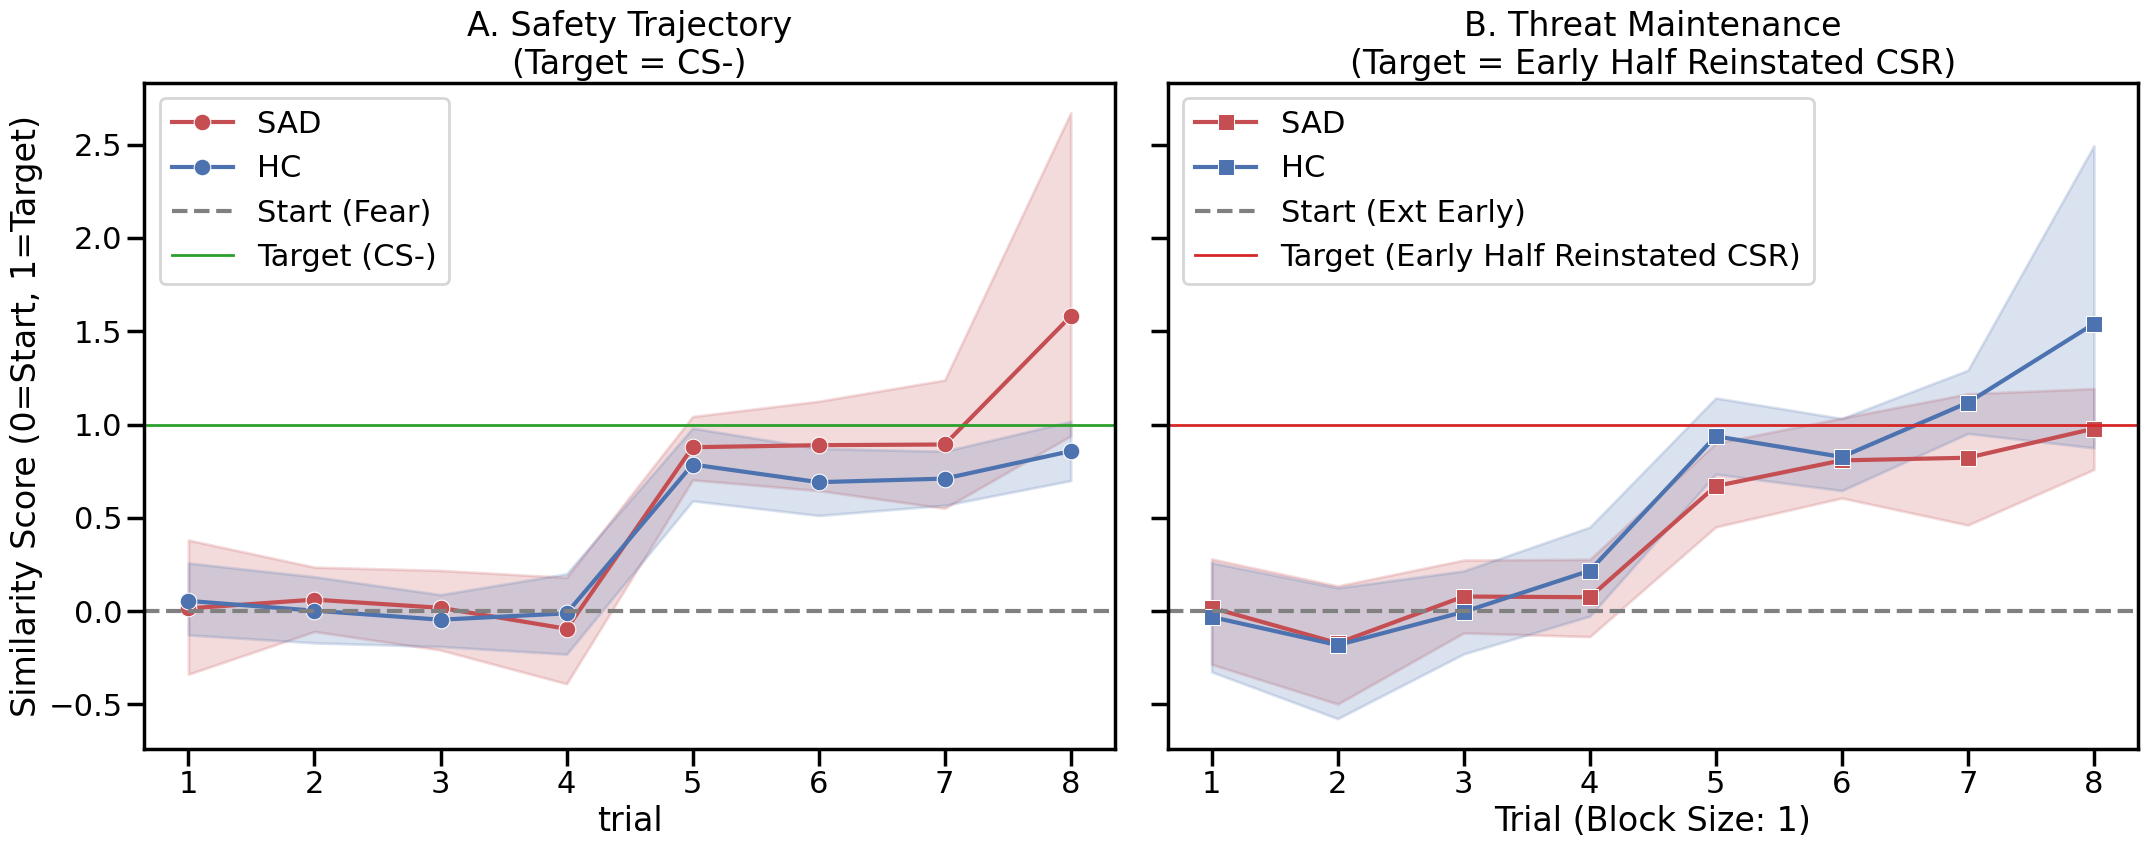

In [ ]:
# Cell 10: Analysis 1.3 - Dynamic Representational Drift (Single-Trial Trajectories)
# Objective: Visualize plasticity trial-by-trial using Top 5% Features.
# Method: Project every trial onto the Ideal Axis (Start -> Target).
#   - Score 0 = Resembles Early Extinction (Start)
#   - Score 1 = Resembles Target (CS- or Reinstated CSR)

print("--- Running Analysis 1.3: Single-Trial Trajectories (Top 5%) ---")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

# Constants
COND_SAFETY_TARGET = "CS-"
COND_SAFETY_LEARN = "CSS"
COND_THREAT_LEARN = "CSR"
PERCENTILE_THRESH = 95
BLOCK_SIZE = 1  # Group trials for smoother plotting (1 = Raw Single Trial)

# =============================================================================
# 0. Feature Selection (Top 5% Positive)
# =============================================================================
print(f"\n[Step 0] Selecting Top {100-PERCENTILE_THRESH}% Features...")

if 'importance_scores' not in locals(): 
    raise ValueError("Run Cell 8 first.")

# --- FIXED FUNCTION ---
def get_top_percentile_mask(scores, percentile):
    thresh = np.percentile(scores, percentile)
    mask = (scores >= thresh) & (scores > 0)
    return mask, thresh  # Now returns TWO values

mask_sad, t_sad = get_top_percentile_mask(importance_scores['SAD'], PERCENTILE_THRESH)
mask_hc, t_hc = get_top_percentile_mask(importance_scores['HC'], PERCENTILE_THRESH)

print(f"  > SAD Top 5%: {np.sum(mask_sad)} voxels (Thresh: {t_sad:.4f})")
print(f"  > HC Top 5%:  {np.sum(mask_hc)} voxels (Thresh: {t_hc:.4f})")

# =============================================================================
# 1. Data Loading (Extinction & Reinstatement)
# =============================================================================
def get_phase_data(group, phase):
    try:
        d = data_subsets[group][phase]
        if d is None: return None, None, None
        return d["X"], d["y"], d["sub"]
    except KeyError:
        return None, None, None

# Load Start Data (Extinction)
X_ext_sad, y_ext_sad, sub_ext_sad = get_phase_data("SAD_Placebo", "ext")
X_ext_hc, y_ext_hc, sub_ext_hc = get_phase_data("HC_Placebo", "ext")

# Load Target Data (Reinstatement)
X_rst_sad, y_rst_sad, sub_rst_sad = get_phase_data("SAD_Placebo", "rst")
X_rst_hc, y_rst_hc, sub_rst_hc = get_phase_data("HC_Placebo", "rst")

# Check Reinstatement Availability
if X_rst_sad is None:
    print("  ! WARNING: Reinstatement data missing. Using Extinction as placeholder.")
    X_rst_sad, y_rst_sad, sub_rst_sad = X_ext_sad, y_ext_sad, sub_ext_sad
    X_rst_hc, y_rst_hc, sub_rst_hc = X_ext_hc, y_ext_hc, sub_ext_hc

# Check Global Availability (for CS-)
if 'X_ext' in locals():
    X_glob, y_glob, sub_glob = X_ext, y_ext, sub_ext
else:
    # Fallback to group data if global is missing
    X_glob, y_glob, sub_glob = X_ext_sad, y_ext_sad, sub_ext_sad

# =============================================================================
# 2. Trajectory Calculation Helper
# =============================================================================
def calc_trajectory(
    X_learn, y_learn, sub_learn,    # The trials we want to project (the "Movie")
    X_targ, y_targ, sub_targ,       # The dataset containing the Goal State
    mask, 
    cond_learn,                     # Condition to track (e.g., CSS)
    cond_target_label               # Label of Goal State (e.g., CS- or CSR)
):
    # Center Data separately to remove session effects
    X_L = subject_wise_centering(X_learn[:, mask], sub_learn)
    X_T = subject_wise_centering(X_targ[:, mask], sub_targ)
    
    unique_subs = np.intersect1d(np.unique(sub_learn), np.unique(sub_targ))
    res = {'sub': [], 'trial': [], 'score': []}
    
    for sub in unique_subs:
        # 1. Get Subject Data
        xl = X_L[sub_learn == sub]; yl = y_learn[sub_learn == sub]
        xt = X_T[sub_targ == sub]; yt = y_targ[sub_targ == sub]
        
        # 2. Define Start Point (Early Learning)
        # We define "Start" as the centroid of the FIRST HALF of the learning trials
        mask_l = (yl == cond_learn)
        trials_l = xl[mask_l]
        if len(trials_l) < 2: continue
        
        cutoff = max(1, len(trials_l) // 2)
        P_start = np.mean(trials_l[:cutoff], axis=0)
        
        # 3. Define Target Point
        mask_t = (yt == cond_target_label)
        if np.sum(mask_t) == 0: continue
        P_target = np.mean(xt[mask_t], axis=0)
        
        # 4. Define Axis
        V_axis = P_target - P_start
        sq_norm = np.dot(V_axis, V_axis)
        if sq_norm == 0: continue
        
        # 5. Project Each Trial
        # Logic: Score = ((Trial - Start) . Axis) / ||Axis||^2
        # This normalizes the progress: 0.0 = Start, 1.0 = Target
        
        # We center the trials relative to the Start Point of this specific axis
        trials_centered = trials_l - P_start
        
        scores = np.dot(trials_centered, V_axis) / sq_norm
        
        for i, s in enumerate(scores):
            res['sub'].append(sub)
            res['trial'].append(i + 1)
            res['score'].append(s)
            
    return pd.DataFrame(res)

# =============================================================================
# 3. Execute Analysis
# =============================================================================
print("\n[Step 2] Calculating Single-Trial Trajectories...")

# A. Safety Learning
# Axis: Early CSS (Ext) --> CS- Centroid (Ext/Global)
print("  > Safety: CSS Trials projecting onto [Early CSS -> CS-]")
df_safe_sad = calc_trajectory(X_ext_sad, y_ext_sad, sub_ext_sad, X_glob, y_glob, sub_glob, mask_sad, COND_SAFETY_LEARN, COND_SAFETY_TARGET)
df_safe_hc = calc_trajectory(X_ext_hc, y_ext_hc, sub_ext_hc, X_glob, y_glob, sub_glob, mask_hc, COND_SAFETY_LEARN, COND_SAFETY_TARGET)

# B. Threat Maintenance
# Axis: Early CSR (Ext) --> Reinstated CSR Centroid (Rst)
print("  > Threat: CSR Trials projecting onto [Early CSR -> Reinstated CSR]")
df_threat_sad = calc_trajectory(X_ext_sad, y_ext_sad, sub_ext_sad, X_rst_sad, y_rst_sad, sub_rst_sad, mask_sad, COND_THREAT_LEARN, COND_THREAT_LEARN)
df_threat_hc = calc_trajectory(X_ext_hc, y_ext_hc, sub_ext_hc, X_rst_hc, y_rst_hc, sub_rst_hc, mask_hc, COND_THREAT_LEARN, COND_THREAT_LEARN)

# =============================================================================
# Detailed Statistics
# =============================================================================
def run_detailed_stats(df_sad, df_hc, label):
    if df_sad.empty or df_hc.empty: return pd.DataFrame()
    
    trials = sorted(list(set(df_sad['trial'].unique()) & set(df_hc['trial'].unique())))
    results = []
    
    for t in trials:
        s_vals = df_sad[df_sad['trial'] == t]['score'].values
        h_vals = df_hc[df_hc['trial'] == t]['score'].values
        
        # A. SAD > 0
        t_s, p_s = ttest_1samp(s_vals, 0, alternative='greater')
        df_s = len(s_vals) - 1
        
        # B. HC > 0
        t_h, p_h = ttest_1samp(h_vals, 0, alternative='greater')
        df_h = len(h_vals) - 1
        
        # C. SAD != HC
        t_d, p_d = ttest_ind(s_vals, h_vals)
        df_d = len(s_vals) + len(h_vals) - 2
        
        results.append({
            'Trial': t,
            'SAD_t': t_s, 'SAD_df': df_s, 'SAD_p': p_s,
            'HC_t': t_h, 'HC_df': df_h, 'HC_p': p_h,
            'Diff_t': t_d, 'Diff_df': df_d, 'Diff_p': p_d
        })
        
    stats_df = pd.DataFrame(results)
    
    # FDR Correction
    if not stats_df.empty:
        _, stats_df['SAD_p_fdr'], _, _ = multipletests(stats_df['SAD_p'], alpha=0.05, method='fdr_bh')
        _, stats_df['HC_p_fdr'], _, _ = multipletests(stats_df['HC_p'], alpha=0.05, method='fdr_bh')
        _, stats_df['Diff_p_fdr'], _, _ = multipletests(stats_df['Diff_p'], alpha=0.05, method='fdr_bh')
        
    print(f"\n--- Statistics: {label} ---")
    # Print significant trials (Diff)
    sig_diff = stats_df[stats_df['Diff_p_fdr'] < 0.05]
    if not sig_diff.empty:
        print("Significant Group Differences (FDR < 0.05):")
        print(sig_diff[['Trial', 'Diff_t', 'Diff_df', 'Diff_p', 'Diff_p_fdr']].to_string(index=False))
    else:
        print("No significant group differences found (FDR corrected).")
        
    return stats_df

print("\n[Step 3] Calculating Statistics...")
stats_safe = run_detailed_stats(df_safe_sad, df_safe_hc, "Safety Learning")
stats_threat = run_detailed_stats(df_threat_sad, df_threat_hc, "Threat Maintenance")
# =============================================================================
# 4. Visualization
# =============================================================================
def prepare_plot(df_sad, df_hc, name):
    if df_sad.empty and df_hc.empty: return pd.DataFrame()
    d_list = []
    if not df_sad.empty:
        d1 = df_sad.copy(); d1['Group'] = 'SAD'; d_list.append(d1)
    if not df_hc.empty:
        d2 = df_hc.copy();  d2['Group'] = 'HC'; d_list.append(d2)
    
    if not d_list: return pd.DataFrame()
    
    df = pd.concat(d_list)
    df['Condition'] = name
    # Bin trials if needed
    if BLOCK_SIZE > 1:
        df['trial'] = ((df['trial'] - 1) // BLOCK_SIZE) + 1
    return df

df_safe = prepare_plot(df_safe_sad, df_safe_hc, "Safety Learning")
df_threat = prepare_plot(df_threat_sad, df_threat_hc, "Threat Maintenance")

if df_safe.empty and df_threat.empty:
    print("! No data to plot.")
else:
    sns.set_context("poster")
    fig, axes = plt.subplots(1, 2, figsize=(22, 9), sharey=True)
    
    # 1. Safety Plot
    if not df_safe.empty:
        sns.lineplot(data=df_safe, x='trial', y='score', hue='Group', 
                     palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, 
                     lw=3, marker="o", err_style="band", ax=axes[0])
        axes[0].set_title("A. Safety Trajectory\n(Target = CS-)")
        axes[0].set_ylabel("Similarity Score (0=Start, 1=Target)")
        axes[0].axhline(0, color='gray', ls='--', label='Start (Fear)')
        axes[0].axhline(1, color='#2ca02c', ls='-', lw=2, label='Target (CS-)')
        axes[0].legend(loc='upper left')

    # 2. Threat Plot
    if not df_threat.empty:
        sns.lineplot(data=df_threat, x='trial', y='score', hue='Group', 
                     palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, 
                     lw=3, marker="s", err_style="band", ax=axes[1])
        axes[1].set_title("B. Threat Maintenance\n(Target = Early Half Reinstated CSR)")
        axes[1].set_xlabel(f"Trial (Block Size: {BLOCK_SIZE})")
        axes[1].axhline(0, color='gray', ls='--', label='Start (Ext Early)')
        axes[1].axhline(1, color='#d62728', ls='-', lw=2, label='Target (Early Half Reinstated CSR)')
        axes[1].legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

results_13 = {
    'stats_safe': stats_safe, 
    'stats_threat': stats_threat,
    'data_safe': df_safe,
    'data_threat': df_threat
}

--- Running Analysis 1.4: Self-Network Statistics (Entropy, Kurtosis, Variance) ---

[Step 2] Calculating Statistics (Native Networks)...
  > Analyzing SAD Placebo...
  > Analyzing HC Placebo...

--- RESULTS: Self-Network Decision Statistics ---

--- Metric: Entropy (Uncertainty) ---
  > SAD Mean: 0.683
  > HC Mean:  0.604
  > Comparison: t=2.702, p=0.0128 (*)

--- Metric: Kurtosis (Sharpness) ---
  > SAD Mean: -0.986
  > HC Mean:  -1.149
  > Comparison: t=1.003, p=0.3502 (ns)

--- Metric: Variance (Spread) ---
  > SAD Mean: 0.074
  > HC Mean:  0.098
  > Comparison: t=-2.713, p=0.0100 (*)


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_81957/2014189781.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_ent_plot, x='Group', y='Val', palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, ax=ax1)
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_81957/2014189781.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_kurt_plot, x='Group', y='Val', palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, ax=ax2)


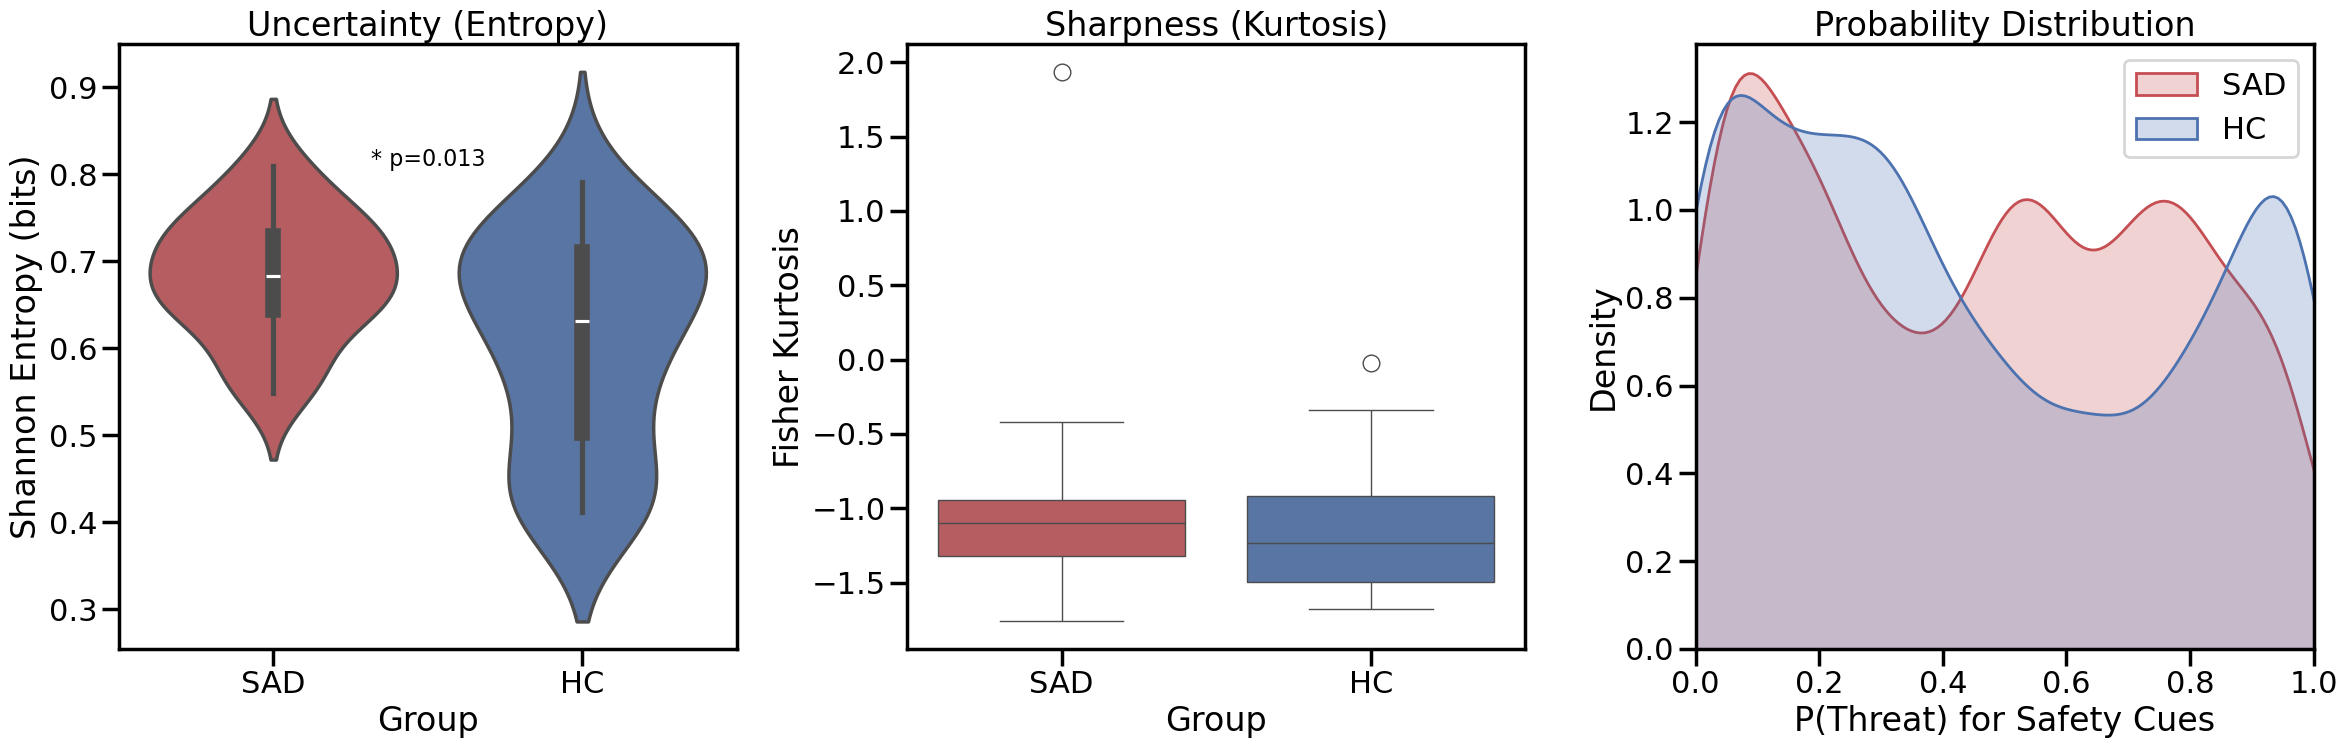

In [ ]:
# Cell 11: Analysis 1.4 - Decision Boundary Characteristics (Self-Network with Stats)
# Objective: Quantify "Cognitive Certainty" (Entropy) and "Decision Sharpness" (Kurtosis) 
#            using each group's NATIVE feature network.
# Method: Cross-Validated Probability Extraction (Fixed Optimal C).

print("--- Running Analysis 1.4: Self-Network Statistics (Entropy, Kurtosis, Variance) ---")

# Constants
COND_CLASS_THREAT = "CSR"
COND_CLASS_SAFE = "CSS"

# =============================================================================
# 0. Setup Feature Masks (Native) & Best Params
# =============================================================================
if 'importance_scores' not in locals(): 
    raise ValueError("Run Cell 8 first to generate 'importance_scores'.")

def get_significant_mask(scores): 
    return scores > 0

mask_sad_native = get_significant_mask(importance_scores['SAD'])
mask_hc_native = get_significant_mask(importance_scores['HC'])

if 'subject_best_params' not in locals():
    print("  > 'subject_best_params' not found. Using default C=1.0.")
    # Fallback default
    subject_best_params = {}

# =============================================================================
# 1. Calculation Helper (Entropy, Kurtosis, Variance)
# =============================================================================
def calculate_distribution_stats(X, y, subjects, feature_mask, best_params_dict):
    # Slice Features & Center
    X_masked = X[:, feature_mask]
    X_masked = subject_wise_centering(X_masked, subjects)
    
    unique_subs = np.unique(subjects)
    res = {'sub': [], 'entropy': [], 'kurtosis': [], 'variance': [], 'probabilities': []}
    
    for sub in unique_subs:
        c_val = best_params_dict.get(sub, 1.0)
        mask_sub = (subjects == sub)
        X_sub = X_masked[mask_sub]; y_sub = y[mask_sub]
        
        # Filter Boundary Classes
        mask_binary = np.isin(y_sub, [COND_CLASS_THREAT, COND_CLASS_SAFE])
        X_binary = X_sub[mask_binary]; y_binary = y_sub[mask_binary]
        
        if len(y_binary) < 10: continue
        
        try:
            # Configure Model
            fixed_model = build_binary_pipeline()
            fixed_model.set_params(classification__C=c_val)
            
            # Cross-Validation
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
            probs_all = cross_val_predict(fixed_model, X_binary, y_binary, cv=cv, method='predict_proba', n_jobs=1)
            
            # Extract Safety Cue Probabilities (P(Threat | Safety Cue))
            classes = sorted(np.unique(y_binary))
            if COND_CLASS_THREAT not in classes: continue
            idx_threat = classes.index(COND_CLASS_THREAT)
            
            mask_css = (y_binary == COND_CLASS_SAFE)
            if np.sum(mask_css) == 0: continue
            probs_css = probs_all[mask_css, idx_threat]
            
            # Metrics
            # 1. Entropy
            p_clean = np.clip(probs_css, 1e-9, 1-1e-9)
            trial_entropies = [entropy([p, 1-p], base=2) for p in p_clean]
            
            # 2. Kurtosis (Fisher's definition, Normal = 0.0)
            k_val = kurtosis(probs_css, fisher=True)
            
            # 3. Variance
            v_val = np.var(probs_css)
            
            res['sub'].append(sub)
            res['entropy'].append(np.mean(trial_entropies))
            res['kurtosis'].append(k_val)
            res['variance'].append(v_val)
            res['probabilities'].append(probs_css)
            
        except Exception as e:
            # print(f"  ! Subject {sub} failed: {e}")
            pass
            
    return pd.DataFrame(res)

# =============================================================================
# 2. Execution (Self-Network)
# =============================================================================
print("\n[Step 2] Calculating Statistics (Native Networks)...")

# --- UPDATED DATA LOADING FROM CELL 5 STRUCTURE ---
def get_ext_data(group_key):
    if group_key not in data_subsets or data_subsets[group_key]['ext'] is None:
        raise ValueError(f"Extinction data for {group_key} missing. Check Cell 5.")
    d = data_subsets[group_key]['ext']
    return d["X"], d["y"], d["sub"]

# Load SAD Data
X_sad, y_sad, sub_sad = get_ext_data("SAD_Placebo")
# Load HC Data
X_hc, y_hc, sub_hc = get_ext_data("HC_Placebo")

# SAD Analysis (Native)
print("  > Analyzing SAD Placebo...")
df_sad_stats = calculate_distribution_stats(
    X_sad, y_sad, sub_sad, 
    mask_sad_native, subject_best_params
)

# HC Analysis (Native)
print("  > Analyzing HC Placebo...")
df_hc_stats = calculate_distribution_stats(
    X_hc, y_hc, sub_hc, 
    mask_hc_native, subject_best_params
)

# =============================================================================
# 3. Statistical Comparison
# =============================================================================
def compare_metric(vec1, vec2, metric_name):
    print(f"\n--- Metric: {metric_name} ---")
    if len(vec1) == 0 or len(vec2) == 0:
        print("  ! Insufficient data.")
        return 1.0
        
    print(f"  > SAD Mean: {np.mean(vec1):.3f}")
    print(f"  > HC Mean:  {np.mean(vec2):.3f}")
    
    t, p, _, _ = perm_ttest_ind(vec1, vec2, n_perm=N_PERMUTATION)
    sig = "*" if p < 0.05 else "ns"
    print(f"  > Comparison: t={t:.3f}, p={p:.4f} ({sig})")
    return p

print("\n--- RESULTS: Self-Network Decision Statistics ---")
p_ent = compare_metric(df_sad_stats['entropy'], df_hc_stats['entropy'], "Entropy (Uncertainty)")
p_kurt = compare_metric(df_sad_stats['kurtosis'], df_hc_stats['kurtosis'], "Kurtosis (Sharpness)")
p_var = compare_metric(df_sad_stats['variance'], df_hc_stats['variance'], "Variance (Spread)")

# =============================================================================
# 4. Visualization
# =============================================================================
sns.set_context("poster")
fig = plt.figure(figsize=(24, 8))
gs = fig.add_gridspec(1, 3)

# A. Entropy (Violin)
ax1 = fig.add_subplot(gs[0, 0])
if not df_sad_stats.empty and not df_hc_stats.empty:
    df_ent_plot = pd.concat([
        pd.DataFrame({'Val': df_sad_stats['entropy'], 'Group': 'SAD'}),
        pd.DataFrame({'Val': df_hc_stats['entropy'], 'Group': 'HC'})
    ])
    sns.violinplot(data=df_ent_plot, x='Group', y='Val', palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, ax=ax1)
    ax1.set_title("Uncertainty (Entropy)")
    ax1.set_ylabel("Shannon Entropy (bits)")
    if p_ent < 0.05: ax1.text(0.5, df_ent_plot['Val'].max(), f'* p={p_ent:.3f}', ha='center', fontsize=16)

# B. Kurtosis (Box)
ax2 = fig.add_subplot(gs[0, 1])
if not df_sad_stats.empty and not df_hc_stats.empty:
    df_kurt_plot = pd.concat([
        pd.DataFrame({'Val': df_sad_stats['kurtosis'], 'Group': 'SAD'}),
        pd.DataFrame({'Val': df_hc_stats['kurtosis'], 'Group': 'HC'})
    ])
    sns.boxplot(data=df_kurt_plot, x='Group', y='Val', palette={'SAD': '#c44e52', 'HC': '#4c72b0'}, ax=ax2)
    ax2.set_title("Sharpness (Kurtosis)")
    ax2.set_ylabel("Fisher Kurtosis")
    if p_kurt < 0.05: ax2.text(0.5, df_kurt_plot['Val'].max(), f'* p={p_kurt:.3f}', ha='center', fontsize=16)

# C. Density (Distribution)
ax3 = fig.add_subplot(gs[0, 2])
if not df_sad_stats.empty and not df_hc_stats.empty:
    probs_sad = np.concatenate(df_sad_stats['probabilities'].values)
    probs_hc = np.concatenate(df_hc_stats['probabilities'].values)
    sns.kdeplot(probs_sad, color='#c44e52', fill=True, label='SAD', bw_adjust=0.6, ax=ax3)
    sns.kdeplot(probs_hc, color='#4c72b0', fill=True, label='HC', bw_adjust=0.6, ax=ax3)
    ax3.set_title("Probability Distribution")
    ax3.set_xlabel("P(Threat) for Safety Cues")
    ax3.set_xlim(0, 1)
    ax3.legend()

plt.tight_layout()
plt.show()

results_14_self = {'df_sad': df_sad_stats, 'df_hc': df_hc_stats}

# Use best C from Analysis 1.1 when phase/labels/group match
best_c_sad = locals().get("best_c_sad", None)
best_c_hc = locals().get("best_c_hc", None)

def get_group_for_sub(sub_id):
    if 'sub_to_meta' not in locals():
        return None
    s_str = str(sub_id).strip()
    conds = None
    if s_str in sub_to_meta:
        conds = sub_to_meta[s_str]
    elif f"sub-{s_str}" in sub_to_meta:
        conds = sub_to_meta[f"sub-{s_str}"]
    elif s_str.replace("sub-", "") in sub_to_meta:
        conds = sub_to_meta[s_str.replace("sub-", "")]
    if conds:
        return conds.get("Group")
    return None

def get_default_c_for_sub(sub_id):
    group = get_group_for_sub(sub_id)
    if group == "SAD" and best_c_sad is not None:
        return float(best_c_sad)
    if group == "HC" and best_c_hc is not None:
        return float(best_c_hc)
    return 1.0


--- Running Analysis 2.1: Safety Restoration & Threat Discrimination (LME) ---
  > Calculating distances (Metric A & Metric B)...
  > Computed metrics for 102 subjects.

[Step 2] Testing for Interaction (Mixed Effects)...

--- Metric 1: Safety Restoration (CSS - CS-) ---
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                           Dependent Variable:                           Dist_Safety
No. Observations:                             102                               Method:                                       REML       
No. Groups:                                   102                               Scale:                                        0.0349     
Min. group size:                              1                                 Log-Likelihood:                               -15.0699   
Max. group size:                              1                                 Converge

/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


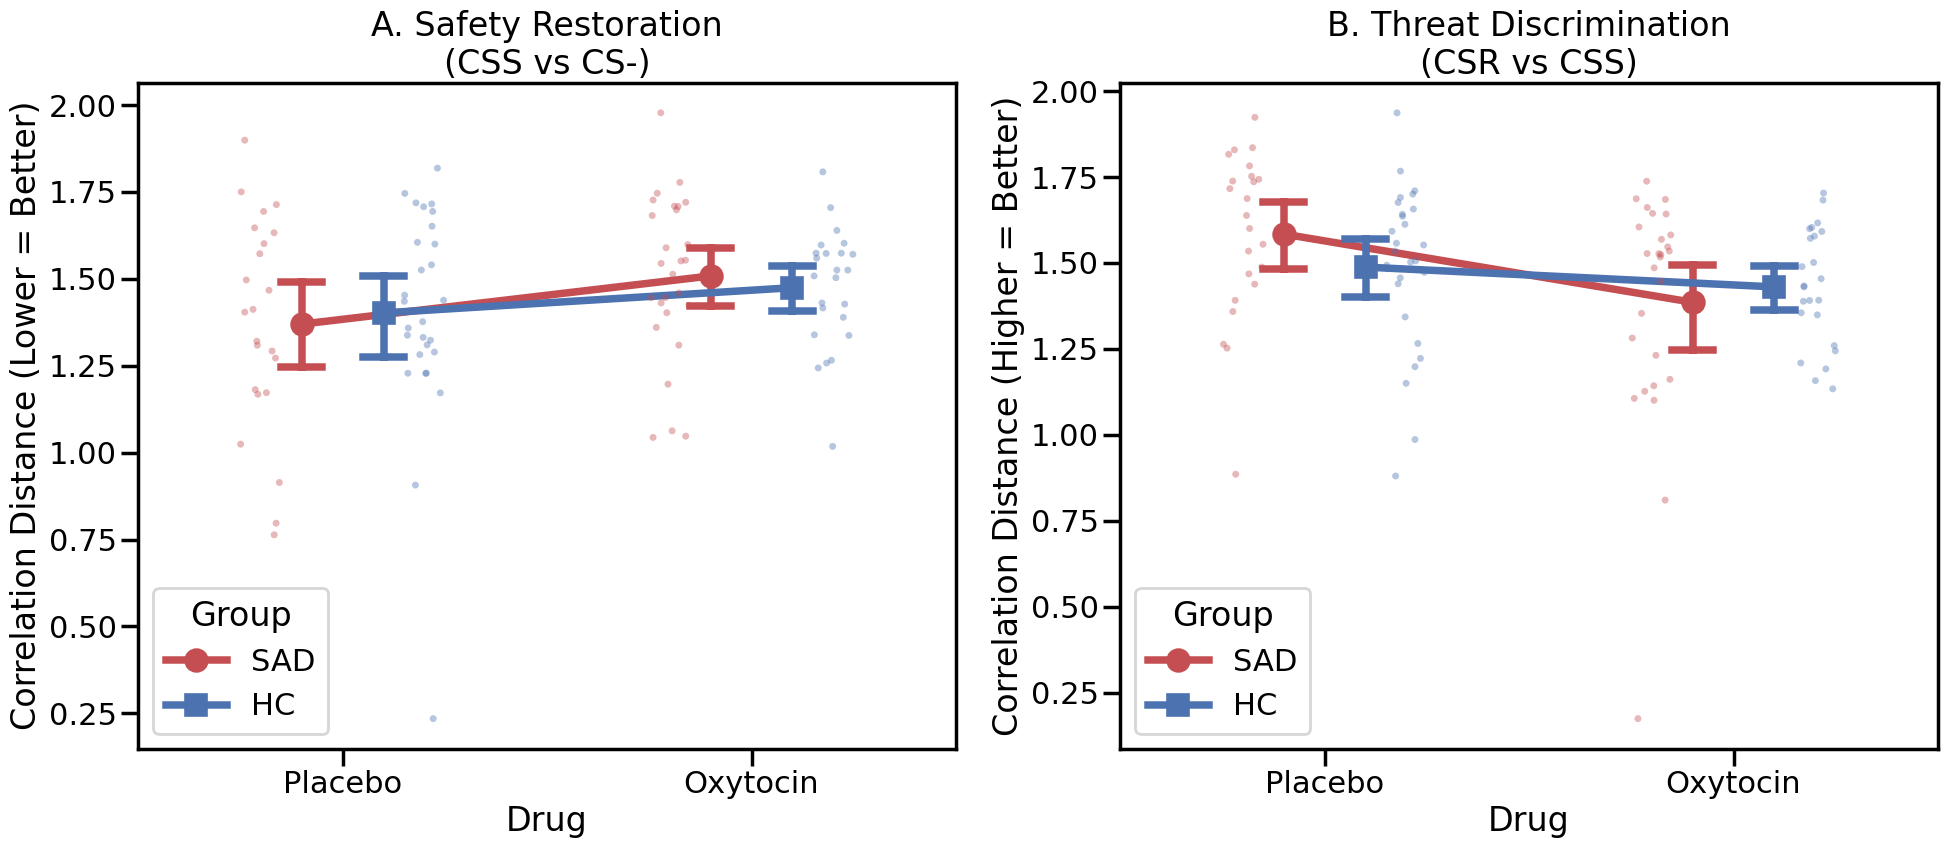

In [ ]:
# Cell 12: Analysis 2.1 - Safety Restoration & Threat Discrimination (Mixed Effects)
# Objective: Test if Oxytocin rescues network topology in SAD.
# Metrics:
#   1. Safety Restoration: Dist(CSS, CS-) -> Should DECREASE (Return to baseline).
#   2. Threat Discrimination: Dist(CSR, CSS) -> Should INCREASE (Better separation).
# Statistical Model: Linear Mixed Effects (LME)
#   Formula: Metric ~ Group * Drug
#   Random Effect: 1 | Subject (Implicitly handles variance if repeated measures exist)

print("--- Running Analysis 2.1: Safety Restoration & Threat Discrimination (LME) ---")

# Constants
COND_SAFE_LEARN = "CSS"
COND_SAFE_BASE  = "CS-"
COND_THREAT     = "CSR"

# =============================================================================
# 0. Validate Masks from Cell 9
# =============================================================================
if 'mask_sad_top5' not in locals() or 'mask_hc_top5' not in locals():
    raise ValueError("Top 5% Masks not found! Please run Cell 9 first.")

# =============================================================================
# 1. Calculate Distances (Both Metrics)
# =============================================================================
subgroups_21 = {"SAD_Placebo": [], "SAD_Oxytocin": [], "HC_Placebo": [], "HC_Oxytocin": []}

# Link subjects to groups
if 'sub_to_meta' not in locals():
    if 'meta' in locals():
        sub_to_meta = meta.set_index("subject_id")[["Group", "Drug"]].to_dict('index')
    else:
        raise ValueError("Metadata not found.")

for sub in np.unique(sub_ext):
    s_str = str(sub).strip()
    if s_str in sub_to_meta: info = sub_to_meta[s_str]
    elif f"sub-{s_str}" in sub_to_meta: info = sub_to_meta[f"sub-{s_str}"]
    else: continue

    key = f"{info['Group']}_{info['Drug']}"
    if key in subgroups_21: subgroups_21[key].append(sub)

data_rows = []
print("  > Calculating distances (Metric A & Metric B)...")

for key, subject_list in subgroups_21.items():
    group, drug = key.split('_')
    
    # Select Native Mask
    current_mask = mask_sad_top5 if group == "SAD" else mask_hc_top5
        
    for sub in subject_list:
        mask_sub = (sub_ext == sub)
        X_sub = X_ext[mask_sub]
        y_sub = y_ext[mask_sub]
        
        # Apply Mask & Center
        X_masked = X_sub[:, current_mask]
        X_masked = X_masked - np.mean(X_masked, axis=0)
        
        # Extract Prototypes
        idx_css = (y_sub == COND_SAFE_LEARN)
        idx_cs_ = (y_sub == COND_SAFE_BASE)
        idx_csr = (y_sub == COND_THREAT)
        
        if np.sum(idx_css) < 3 or np.sum(idx_cs_) < 3 or np.sum(idx_csr) < 3: continue
        
        p_css = np.mean(X_masked[idx_css], axis=0).reshape(1, -1)
        p_cs_ = np.mean(X_masked[idx_cs_], axis=0).reshape(1, -1)
        p_csr = np.mean(X_masked[idx_csr], axis=0).reshape(1, -1)
        
        # Metric 1: Safety Restoration (CSS vs CS-)
        dist_safety = cdist(p_css, p_cs_, metric='correlation')[0][0]
        
        # Metric 2: Threat Discrimination (CSR vs CSS)
        dist_threat = cdist(p_csr, p_css, metric='correlation')[0][0]
            
        data_rows.append({
            "Subject": sub, "Group": group, "Drug": drug, "Condition": key,
            "Dist_Safety": dist_safety,
            "Dist_Threat": dist_threat
        })

df_topo = pd.DataFrame(data_rows)
print(f"  > Computed metrics for {len(df_topo)} subjects.")

# =============================================================================
# 2. Statistical Tests (Linear Mixed Effects)
# =============================================================================
print("\n[Step 2] Testing for Interaction (Mixed Effects)...")

def run_lme(formula, data, title):
    print(f"\n--- {title} ---")
    # Groups='Subject' handles random intercepts per subject
    # If design is between-subject, this converges to GLM/ANOVA but handles missingness better
    md = smf.mixedlm(formula, data, groups=data["Subject"]) 
    try:
        mdf = md.fit()
        print(mdf.summary())
        
        # Extract Interaction P-Value safely
        term = "C(Group, Treatment(reference='HC'))[T.SAD]:C(Drug, Treatment(reference='Placebo'))[T.Oxytocin]"
        if term in mdf.pvalues:
            p_val = mdf.pvalues[term]
            print(f"  >>> Interaction P-Value: {p_val:.5f} {'*' if p_val < 0.05 else ''}")
            return p_val
        else:
            print("  ! Interaction term not found in model results.")
            return 1.0
            
    except Exception as e:
        print(f"  ! Model Convergence Failed: {e}")
        return 1.0

# Formula: Metric ~ Group * Drug
# We set references explicitly: Group=HC, Drug=Placebo
form_base = "~ C(Group, Treatment(reference='HC')) * C(Drug, Treatment(reference='Placebo'))"

# Test 1: Safety Restoration
p_int_safe = run_lme("Dist_Safety " + form_base, df_topo, "Metric 1: Safety Restoration (CSS - CS-)")

# Test 2: Threat Discrimination
p_int_threat = run_lme("Dist_Threat " + form_base, df_topo, "Metric 2: Threat Discrimination (CSR - CSS)")

# =============================================================================
# 3. Visualization
# =============================================================================
sns.set_context("poster")
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
pal_group = {'SAD': '#c44e52', 'HC': '#4c72b0'}

# Plot A: Safety Restoration
sns.pointplot(data=df_topo, x='Drug', y='Dist_Safety', hue='Group', 
              palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
              dodge=0.2, markers=['o', 's'], capsize=0.1, ax=axes[0])
sns.stripplot(data=df_topo, x='Drug', y='Dist_Safety', hue='Group', 
              palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
              dodge=True, alpha=0.4, jitter=True, legend=False, ax=axes[0])

axes[0].set_title("A. Safety Restoration\n(CSS vs CS-)")
axes[0].set_ylabel("Correlation Distance (Lower = Better)")
if p_int_safe < 0.05:
    axes[0].text(0.5, 0.95, f"Interaction: p={p_int_safe:.3f}", transform=axes[0].transAxes, ha='center', fontweight='bold')

# Plot B: Threat Discrimination
sns.pointplot(data=df_topo, x='Drug', y='Dist_Threat', hue='Group', 
              palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
              dodge=0.2, markers=['o', 's'], capsize=0.1, ax=axes[1])
sns.stripplot(data=df_topo, x='Drug', y='Dist_Threat', hue='Group', 
              palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
              dodge=True, alpha=0.4, jitter=True, legend=False, ax=axes[1])

axes[1].set_title("B. Threat Discrimination\n(CSR vs CSS)")
axes[1].set_ylabel("Correlation Distance (Higher = Better)")
if p_int_threat < 0.05:
    axes[1].text(0.5, 0.95, f"Interaction: p={p_int_threat:.3f}", transform=axes[1].transAxes, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

results_21 = {'df': df_topo, 'p_safe': p_int_safe, 'p_threat': p_int_threat}

--- Running Analysis 2.2: Drift Efficiency (Means ± SEM) ---

[Step 0] Setup & Data Loading...
  > Core Masks: SAD=31, HC=108

[Step 1] Calculating Drift Vectors...
  > Computed vectors for 102 subjects.

[Step 2] Statistical Testing (LME)...

--- Domain: Safety ---
  > Cosine: Interaction p=0.0586 
  > Projection: Interaction p=0.1367 

--- Domain: Threat ---
  > Cosine: Interaction p=0.0160 *
  > Projection: Interaction p=0.0000 *


/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/var/folders/63/3j_hstl9

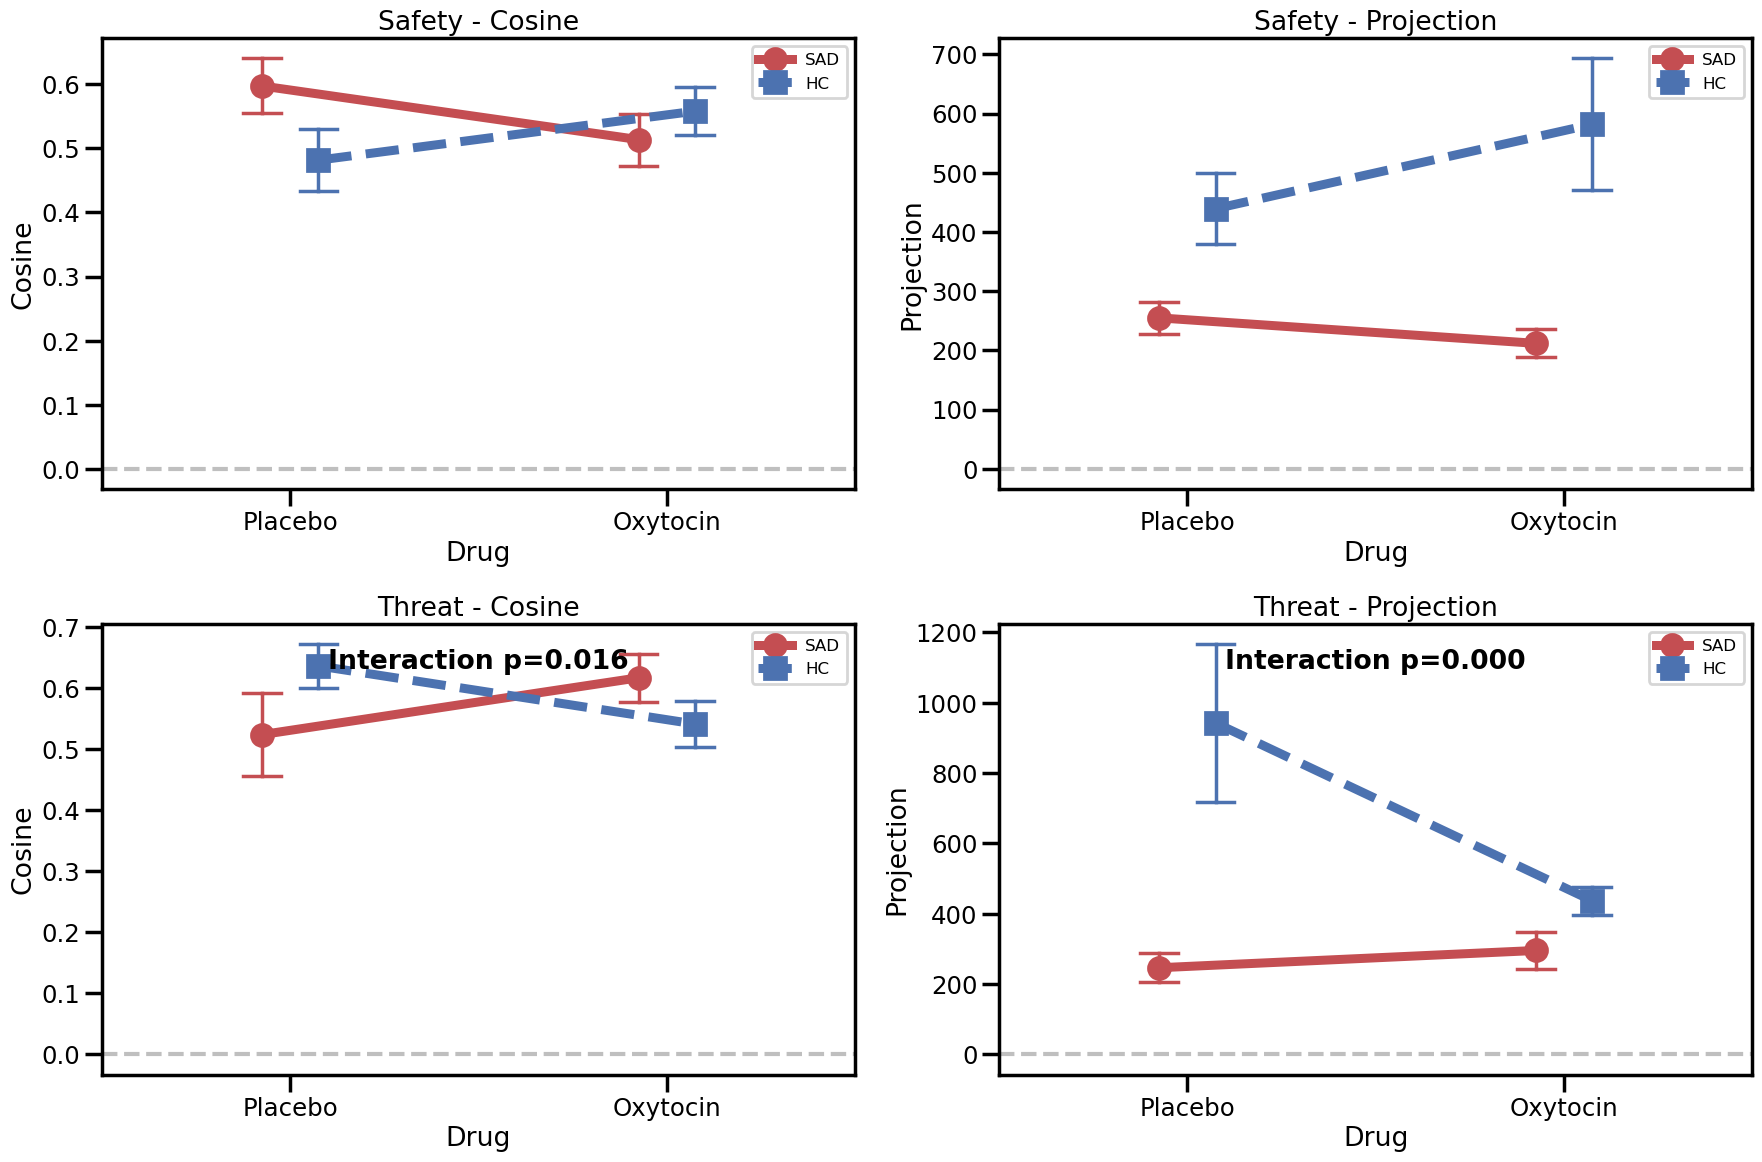

Note: Error bars represent Standard Error of the Mean (SEM).


In [ ]:
# Cell 13: Analysis 2.2 - Drift Efficiency (Safety & Threat Maintenance)
# Objective: Test OXT effect on neural drift efficiency in the Core Top 5% Network.
# Domains:
#   1. Safety Learning:    CSS(Ext) -> CS-(Ext)
#   2. Threat Maintenance: CSR(Ext) -> CSR(Reinst)
# Stats: Linear Mixed Effects (LME)
# Visualization: Line plots (Means ± SEM)

print("--- Running Analysis 2.2: Drift Efficiency (Means ± SEM) ---")

# Constants
COND_SAFE_TGT = "CS-"
COND_SAFE_LRN = "CSS"
COND_THREAT_LRN = "CSR"
PERCENTILE_THRESH = 95  # Top 5%

# =============================================================================
# 0. Setup: Masks & Data Loading
# =============================================================================
print(f"\n[Step 0] Setup & Data Loading...")

if 'importance_scores' not in locals(): 
    raise ValueError("Importance scores not found! Please run Cell 8 first.")

def get_top_percentile_mask(scores, percentile):
    thresh = np.percentile(scores, percentile)
    return (scores >= thresh) & (scores > 0)

mask_sad_core = get_top_percentile_mask(importance_scores['SAD'], PERCENTILE_THRESH)
mask_hc_core = get_top_percentile_mask(importance_scores['HC'], PERCENTILE_THRESH)
print(f"  > Core Masks: SAD={np.sum(mask_sad_core)}, HC={np.sum(mask_hc_core)}")

# Load Reinstatement Data
X_rst_all, y_rst_all, sub_rst_all = None, None, None
if 'X_reinst' in locals():
    X_rst_all, y_rst_all, sub_rst_all = X_reinst, y_reinst, sub_reinst
else:
    try:
        xs, ys, ss = [], [], []
        for grp in ["SAD_Placebo", "SAD_Oxytocin", "HC_Placebo", "HC_Oxytocin"]:
            if grp in data_subsets and data_subsets[grp]['rst'] is not None:
                d = data_subsets[grp]['rst']
                xs.append(d['X']); ys.append(d['y']); ss.append(d['sub'])
        if xs:
            X_rst_all = np.vstack(xs)
            y_rst_all = np.concatenate(ys)
            sub_rst_all = np.concatenate(ss)
    except:
        print("  ! Threat analysis skipped (Reinstatement data missing).")

# =============================================================================
# 1. Vector Calculation
# =============================================================================
subgroups_22 = {"SAD_Placebo": [], "SAD_Oxytocin": [], "HC_Placebo": [], "HC_Oxytocin": []}

if 'sub_to_meta' not in locals():
    if 'meta' in locals():
        sub_to_meta = meta.set_index("subject_id")[["Group", "Drug"]].to_dict('index')
    else: raise ValueError("Metadata not found.")

for sub in np.unique(sub_ext):
    s_str = str(sub).strip()
    if s_str in sub_to_meta: info = sub_to_meta[s_str]
    elif f"sub-{s_str}" in sub_to_meta: info = sub_to_meta[f"sub-{s_str}"]
    else: continue
    key = f"{info['Group']}_{info['Drug']}"
    if key in subgroups_22: subgroups_22[key].append(sub)

data_rows = []
print("\n[Step 1] Calculating Drift Vectors...")

def calc_drift_metrics(X_start_phase, y_start_phase, X_tgt_phase, y_tgt_phase, 
                       cond_start, cond_target, mask, sub_id):
    # Mask & Center (Phase-wise centering)
    X_s = X_start_phase[:, mask]
    X_s = X_s - np.mean(X_s, axis=0)
    
    X_t = X_tgt_phase[:, mask]
    X_t = X_t - np.mean(X_t, axis=0)
    
    # Target Centroid
    mask_tgt = (y_tgt_phase == cond_target)
    if np.sum(mask_tgt) < 2: return None
    P_target = np.mean(X_t[mask_tgt], axis=0)
    
    # Trajectory
    mask_lrn = (y_start_phase == cond_start)
    idx_lrn = np.where(mask_lrn)[0]
    if len(idx_lrn) < 4: return None
    
    cutoff = len(idx_lrn) // 2
    P_start = np.mean(X_s[idx_lrn[:cutoff]], axis=0)
    P_end = np.mean(X_s[idx_lrn[cutoff:]], axis=0)
    
    # Vectors
    V_axis = P_target - P_start
    V_drift = P_end - P_start
    
    nA, nD = norm(V_axis), norm(V_drift)
    if nA == 0 or nD == 0: return None
    
    dot = np.dot(V_drift, V_axis)
    return {'Cosine': dot / (nA * nD), 'Projection': dot / nA}

for key, subject_list in subgroups_22.items():
    group, drug = key.split('_')
    curr_mask = mask_sad_core if group == "SAD" else mask_hc_core
    
    for sub in subject_list:
        m_ext = (sub_ext == sub)
        X_e, y_e = X_ext[m_ext], y_ext[m_ext]
        
        # 1. Safety
        res_safe = calc_drift_metrics(X_e, y_e, X_e, y_e, COND_SAFE_LRN, COND_SAFE_TGT, curr_mask, sub)
        if res_safe:
            data_rows.append({"Subject": sub, "Group": group, "Drug": drug, "Domain": "Safety", **res_safe})
            
        # 2. Threat
        if X_rst_all is not None:
            m_rst = (sub_rst_all == sub)
            if np.sum(m_rst) > 0:
                X_r, y_r = X_rst_all[m_rst], y_rst_all[m_rst]
                res_threat = calc_drift_metrics(X_e, y_e, X_r, y_r, COND_THREAT_LRN, COND_THREAT_LRN, curr_mask, sub)
                if res_threat:
                    data_rows.append({"Subject": sub, "Group": group, "Drug": drug, "Domain": "Threat", **res_threat})

df_drift = pd.DataFrame(data_rows)
print(f"  > Computed vectors for {len(df_drift['Subject'].unique())} subjects.")

# =============================================================================
# 2. Statistics (LME)
# =============================================================================
print("\n[Step 2] Statistical Testing (LME)...")
lme_results = {}

for domain in ["Safety", "Threat"]:
    if domain not in df_drift['Domain'].values: continue
    df_sub = df_drift[df_drift["Domain"] == domain].copy()
    form_base = "~ C(Group, Treatment(reference='HC')) * C(Drug, Treatment(reference='Placebo'))"
    
    print(f"\n--- Domain: {domain} ---")
    for metric in ["Cosine", "Projection"]:
        try:
            md = smf.mixedlm(f"{metric} {form_base}", df_sub, groups=df_sub["Subject"])
            mdf = md.fit()
            term = "C(Group, Treatment(reference='HC'))[T.SAD]:C(Drug, Treatment(reference='Placebo'))[T.Oxytocin]"
            p_val = mdf.pvalues.get(term, 1.0)
            print(f"  > {metric}: Interaction p={p_val:.4f} {'*' if p_val<0.05 else ''}")
            lme_results[f"{domain}_{metric}"] = p_val
        except:
            lme_results[f"{domain}_{metric}"] = 1.0

# =============================================================================
# 3. Visualization (Lines Only, Error=SE)
# =============================================================================
sns.set_context("poster", font_scale=0.8)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
pal_group = {'SAD': '#c44e52', 'HC': '#4c72b0'}

def plot_interaction(ax, df, domain, metric, p_val):
    data = df[df["Domain"] == domain]
    if data.empty: return
    
    # Error bars = Standard Error (se)
    # This approximates within-subject error visualization for group means
    sns.pointplot(data=data, x='Drug', y=metric, hue='Group', 
                  palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
                  dodge=0.15, markers=['o', 's'], linestyles=['-', '--'], 
                  capsize=0.1, err_kws={'linewidth': 2.5}, scale=1.2, 
                  errorbar='se', ax=ax)
    
    ax.set_title(f"{domain} - {metric}")
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.legend(loc='upper right', fontsize=12)
    
    if p_val < 0.05:
        ax.text(0.5, 0.9, f"Interaction p={p_val:.3f}", transform=ax.transAxes, 
                ha='center', fontweight='bold', color='black')

# Plot Grid
plot_interaction(axes[0,0], df_drift, "Safety", "Cosine", lme_results.get("Safety_Cosine", 1.0))
plot_interaction(axes[0,1], df_drift, "Safety", "Projection", lme_results.get("Safety_Projection", 1.0))
plot_interaction(axes[1,0], df_drift, "Threat", "Cosine", lme_results.get("Threat_Cosine", 1.0))
plot_interaction(axes[1,1], df_drift, "Threat", "Projection", lme_results.get("Threat_Projection", 1.0))

plt.tight_layout()
plt.show()

print("Note: Error bars represent Standard Error of the Mean (SEM).")
results_22 = {'df': df_drift, 'stats': lme_results}

--- Running Analysis 2.3: Probabilistic Opening (Entropy, Kurtosis, Variance) ---
  > SAD Native Network: 31 voxels
  > HC Native Network:  1394 voxels

[Step 1] Calculating Decision Metrics...
  > Computed metrics for 102 subjects.

[Step 2] Statistical Testing (LME for each metric)...

--- Metric: Entropy ---
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Entropy
No. Observations:                             102                                 Method:                                         REML   
No. Groups:                                   102                                 Scale:                                          0.0056 
Min. group size:                              1                                   Log-Likelihood:                                 74.2953
Max. group size:                              1

/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/statsmodels/regress

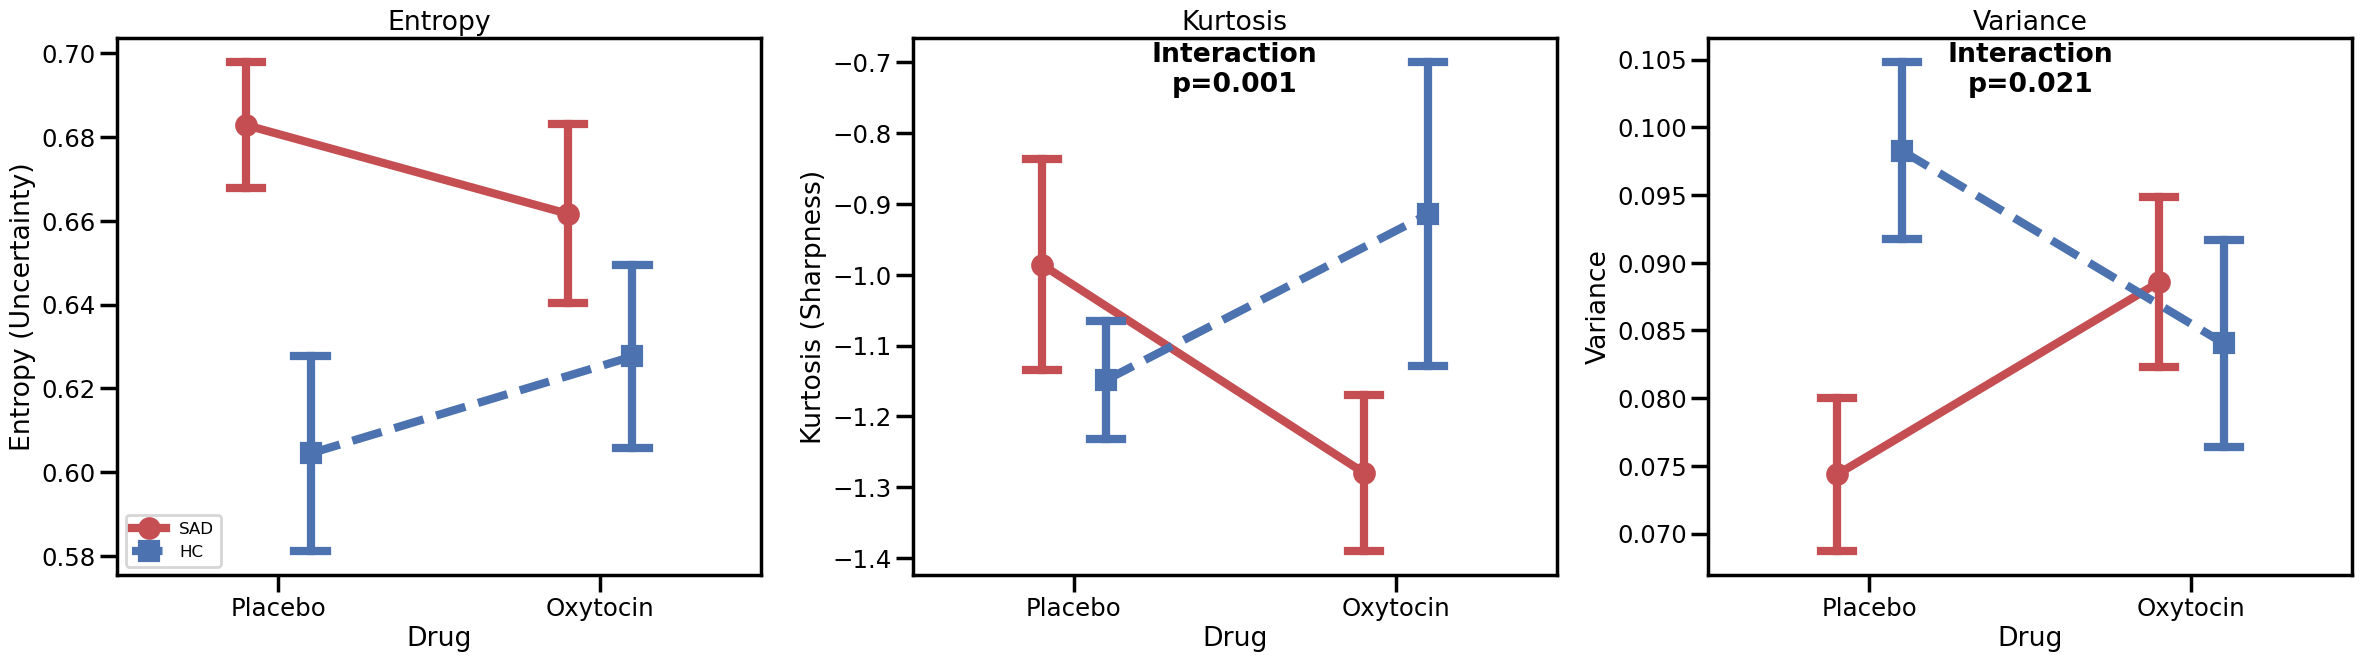

In [ ]:
# Cell 14: Analysis 2.3 - The "Probabilistic Opening" Test (Entropy, Kurtosis, Variance)
# Objective: Test if Oxytocin increases "Cognitive Uncertainty" in SAD.
# Hypothesis: SAD-OXT will show HIGHER Entropy, LOWER Kurtosis, HIGHER Variance than SAD-PLC.
# Method: Cross-Validated Probability Extraction -> Metrics.
# Stats: Linear Mixed Effects (Metric ~ Group * Drug).

print("--- Running Analysis 2.3: Probabilistic Opening (Entropy, Kurtosis, Variance) ---")

# Constants
COND_CLASS_THREAT = "CSR"
COND_CLASS_SAFE = "CSS"
RANDOM_STATE = 42

# =============================================================================
# 0. Setup: Masks & Data
# =============================================================================
if 'importance_scores' not in locals(): 
    raise ValueError("Importance scores missing. Run Cell 8.")

# Define Native Networks
def get_significant_mask(scores): return scores > 0

mask_sad_native = get_significant_mask(importance_scores['SAD'])
mask_hc_native = get_significant_mask(importance_scores['HC'])
print(f"  > SAD Native Network: {np.sum(mask_sad_native)} voxels")
print(f"  > HC Native Network:  {np.sum(mask_hc_native)} voxels")

# Load Subject-Group-Drug Mapping
if 'sub_to_meta' not in locals():
    if 'meta' in locals():
        sub_to_meta = meta.set_index("subject_id")[["Group", "Drug"]].to_dict('index')
    else: raise ValueError("Metadata not found.")

subgroups_23 = {"SAD_Placebo": [], "SAD_Oxytocin": [], "HC_Placebo": [], "HC_Oxytocin": []}
for sub in np.unique(sub_ext):
    s_str = str(sub).strip()
    if s_str in sub_to_meta: info = sub_to_meta[s_str]
    elif f"sub-{s_str}" in sub_to_meta: info = sub_to_meta[f"sub-{s_str}"]
    else: continue
    
    key = f"{info['Group']}_{info['Drug']}"
    if key in subgroups_23: subgroups_23[key].append(sub)

# =============================================================================
# 1. Calculation Helper (All 3 Metrics)
# =============================================================================
def calc_metrics_for_subject(X, y, sub_id, feature_mask, C_param=1.0):
    # 1. Mask & Center
    X_m = X[:, feature_mask]
    X_m = X_m - np.mean(X_m, axis=0)
    
    # 2. Filter Binary Classes
    mask_bin = np.isin(y, [COND_CLASS_THREAT, COND_CLASS_SAFE])
    X_bin, y_bin = X_m[mask_bin], y[mask_bin]
    
    if len(y_bin) < 10: return None
    
    try:
        # 3. CV Probabilities
        model = build_binary_pipeline()
        model.set_params(classification__C=C_param)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        probs_all = cross_val_predict(model, X_bin, y_bin, cv=cv, method='predict_proba', n_jobs=1)
        
        # 4. Extract Safety Cue Probabilities
        classes = sorted(np.unique(y_bin))
        if COND_CLASS_THREAT not in classes: return None
        idx_threat = classes.index(COND_CLASS_THREAT)
        
        mask_css = (y_bin == COND_CLASS_SAFE)
        if np.sum(mask_css) == 0: return None
        
        # Prob(Threat | Safety Cue)
        probs_css = probs_all[mask_css, idx_threat]
        
        # --- Metrics ---
        # A. Entropy (Uncertainty)
        p_clean = np.clip(probs_css, 1e-9, 1-1e-9)
        ents = [entropy([p, 1-p], base=2) for p in p_clean]
        val_ent = np.mean(ents)
        
        # B. Kurtosis (Sharpness) - Fisher's (Normal=0)
        val_kurt = kurtosis(probs_css, fisher=True)
        
        # C. Variance (Spread)
        val_var = np.var(probs_css)
        
        return {'Entropy': val_ent, 'Kurtosis': val_kurt, 'Variance': val_var}
        
    except Exception:
        return None

# =============================================================================
# 2. Execution Loop
# =============================================================================
data_rows = []
print("\n[Step 1] Calculating Decision Metrics...")

if 'subject_best_params' not in locals(): subject_best_params = {}

for key, sub_list in subgroups_23.items():
    group, drug = key.split('_')
    curr_mask = mask_sad_native if group == "SAD" else mask_hc_native
    
    for sub in sub_list:
        mask_s = (sub_ext == sub)
        X_s, y_s = X_ext[mask_s], y_ext[mask_s]
        
        c_val = subject_best_params.get(sub, 1.0)
        
        res = calc_metrics_for_subject(X_s, y_s, sub, curr_mask, c_val)
        
        if res is not None:
            data_rows.append({
                "Subject": sub, "Group": group, "Drug": drug, 
                "Entropy": res['Entropy'], 
                "Kurtosis": res['Kurtosis'], 
                "Variance": res['Variance']
            })

df_metrics = pd.DataFrame(data_rows)
print(f"  > Computed metrics for {len(df_metrics)} subjects.")

# =============================================================================
# 3. Statistical Testing (LME Loop)
# =============================================================================
print("\n[Step 2] Statistical Testing (LME for each metric)...")

stats_results = {}
metrics_list = ["Entropy", "Kurtosis", "Variance"]

for met in metrics_list:
    print(f"\n--- Metric: {met} ---")
    try:
        # LME: Metric ~ Group * Drug + (1|Subject)
        md = smf.mixedlm(f"{met} ~ C(Group, Treatment(reference='HC')) * C(Drug, Treatment(reference='Placebo'))", 
                         df_metrics, groups=df_metrics["Subject"])
        mdf = md.fit()
        print(mdf.summary())
        
        # Interaction P-Value
        term_int = "C(Group, Treatment(reference='HC'))[T.SAD]:C(Drug, Treatment(reference='Placebo'))[T.Oxytocin]"
        p_val = mdf.pvalues.get(term_int, 1.0)
        stats_results[met] = p_val
        print(f"  >>> Interaction p={p_val:.4f} {'*' if p_val < 0.05 else ''}")
        
    except Exception as e:
        print(f"  ! Model Failed: {e}")
        stats_results[met] = 1.0

# =============================================================================
# 4. Visualization (Side-by-Side)
# =============================================================================
sns.set_context("poster", font_scale=0.8)
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
pal_group = {'SAD': '#c44e52', 'HC': '#4c72b0'}

def plot_metric(ax, metric, p_val):
    sns.pointplot(data=df_metrics, x='Drug', y=metric, hue='Group', 
                  palette=pal_group, order=['Placebo', 'Oxytocin'], hue_order=['SAD', 'HC'],
                  dodge=0.2, markers=['o', 's'], linestyles=['-', '--'], 
                  capsize=0.1, errorbar='se', scale=1.1, ax=ax)
    
    ax.set_title(f"{metric}")
    ax.set_ylabel(metric)
    if metric == "Entropy": ax.set_ylabel("Entropy (Uncertainty)")
    if metric == "Kurtosis": ax.set_ylabel("Kurtosis (Sharpness)")
    
    # Annotate Significance
    if p_val < 0.05:
        ax.text(0.5, 0.9, f"Interaction\np={p_val:.3f}", transform=ax.transAxes, 
                ha='center', fontweight='bold', color='black')

# Plot all 3
plot_metric(axes[0], "Entropy", stats_results["Entropy"])
plot_metric(axes[1], "Kurtosis", stats_results["Kurtosis"])
plot_metric(axes[2], "Variance", stats_results["Variance"])

axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[0].legend(loc='lower left', fontsize=12)

plt.tight_layout()
plt.show()

results_23 = {'df': df_metrics, 'stats': stats_results}

# Use best C from Analysis 1.1 when phase/labels/group match
best_c_sad = locals().get("best_c_sad", None)
best_c_hc = locals().get("best_c_hc", None)

def get_group_for_sub(sub_id):
    if 'sub_to_meta' not in locals():
        return None
    s_str = str(sub_id).strip()
    conds = None
    if s_str in sub_to_meta:
        conds = sub_to_meta[s_str]
    elif f"sub-{s_str}" in sub_to_meta:
        conds = sub_to_meta[f"sub-{s_str}"]
    elif s_str.replace("sub-", "") in sub_to_meta:
        conds = sub_to_meta[s_str.replace("sub-", "")]
    if conds:
        return conds.get("Group")
    return None

def get_default_c_for_sub(sub_id):
    group = get_group_for_sub(sub_id)
    if group == "SAD" and best_c_sad is not None:
        return float(best_c_sad)
    if group == "HC" and best_c_hc is not None:
        return float(best_c_hc)
    return 1.0


--- Running Analysis 2.4: Spatial Re-Alignment (Using Analysis 1.1 Output) ---
  > Retrieved Analysis 1.1 Model for: CSR vs CSS
  > Model Classes: ['CSR' 'CSS']

[Step 1] Cross-Decoding on SAD Subgroups (Forced Choice)...
  > SAD-Placebo Acc (decoded by HC Model):  78.3% (n=23)
  > SAD-Oxytocin Acc (decoded by HC Model): 66.7% (n=27)

[Step 2] Statistical Test...
  > Hypothesis (OXT > PLC): t=-0.899, p=0.8135 (ns)


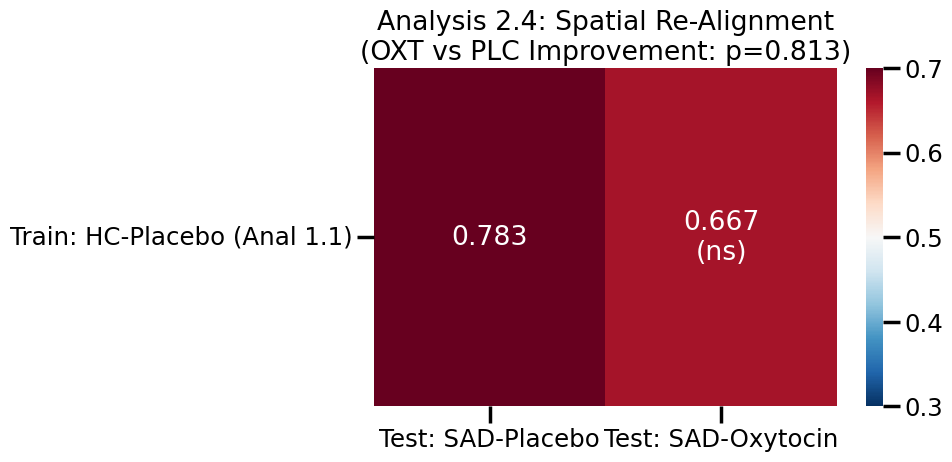


Interpretation:
 - SAD-Placebo Accuracy (78.3%): How well the SAD brain fits the Healthy template naturally.
 - SAD-Oxytocin Accuracy (66.7%): How well it fits AFTER treatment.
 - A significant increase indicates OXT 'normalizes' the neural code for Threat vs Safety.


In [ ]:
# Cell 15: Analysis 2.4 - Spatial Re-Alignment (The "Normalizing" Effect)
# Objective: Test if OXT shifts SAD representations to align with the "Healthy" template.
# Protocol: 
#   1. Retrieve the 'CSS vs CSR' model specifically from Analysis 1.1 (Cell 6).
#   2. Cross-Decode on SAD-Placebo vs. SAD-Oxytocin (using full feature set).
#   3. Metric: Pairwise Forced Choice Accuracy (CSR Score > CSS Score).
# Visualization: Accuracy Heatmap (Train HC -> Test SAD groups).

print("--- Running Analysis 2.4: Spatial Re-Alignment (Using Analysis 1.1 Output) ---")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Constants
COND_SAFE = "CSS"
COND_THREAT = "CSR"
LABELS = [COND_SAFE, COND_THREAT]

# =============================================================================
# 0. Setup: Retrieve Correct Model from Cell 6 Results
# =============================================================================
# We need the specific model trained on Safety (CSS) vs Threat (CSR).
target_contrast = "CSS vs CSR"
alt_contrast = "CSR vs CSS"

if 'res_hc_dict' in locals():
    # Check which key exists in the dictionary
    if target_contrast in res_hc_dict:
        gold_model = res_hc_dict[target_contrast]['model']
        print(f"  > Retrieved Analysis 1.1 Model for: {target_contrast}")
    elif alt_contrast in res_hc_dict:
        gold_model = res_hc_dict[alt_contrast]['model']
        print(f"  > Retrieved Analysis 1.1 Model for: {alt_contrast}")
    else:
        raise ValueError(f"Analysis 1.1 results found, but '{target_contrast}' is missing.\n"
                         f"    Available keys: {list(res_hc_dict.keys())}")
else:
    raise ValueError("Analysis 1.1 results ('res_hc_dict') not found. Please run Cell 6 first.")

# Verify Classes (Must be Safety/Threat)
print(f"  > Model Classes: {gold_model.classes_}")
if COND_THREAT not in gold_model.classes_ or COND_SAFE not in gold_model.classes_:
    raise ValueError(f"CRITICAL: The retrieved model was trained on {gold_model.classes_}, "
                     f"but this analysis requires {LABELS}.")

# Data Loading Helper
def get_ext_data(group_key):
    if group_key not in data_subsets: raise ValueError(f"{group_key} missing.")
    d = data_subsets[group_key]['ext']
    return d["X"], d["y"], d["sub"]

X_sad_plc, y_sad_plc, sub_sad_plc = get_ext_data("SAD_Placebo")
X_sad_oxt, y_sad_oxt, sub_sad_oxt = get_ext_data("SAD_Oxytocin")

# =============================================================================
# 1. Functional Specificity (Forced Choice Calculation)
# =============================================================================
print("\n[Step 1] Cross-Decoding on SAD Subgroups (Forced Choice)...")

def calc_forced_choice_acc(model, X, y, subs):
    """
    Computes accuracy by comparing decision values for CSS vs CSR within each subject.
    Matches the logic used in Analysis 1.1 'Functional Specificity'.
    """
    # 1. Filter Data for CSS/CSR
    mask_c = np.isin(y, LABELS)
    X_f = X[mask_c] 
    y_f = y[mask_c]
    s_f = subs[mask_c]
    
    if len(y_f) == 0: return []

    # 2. Subject-wise Centering
    #    CRITICAL: Projects test data into the same mean-centered space as training data
    #    We assume 'subject_wise_centering' function exists (from Cell 6)
    X_f = subject_wise_centering(X_f, s_f)
    
    # 3. Get Decision Values (Distance from hyperplane)
    try:
        scores = model.decision_function(X_f)
    except ValueError as e:
        print(f"    ! Prediction Error (Shape Mismatch?): {e}")
        return []
    
    # 4. Aggregate Scores per Subject
    df_scores = pd.DataFrame({'sub': s_f, 'cond': y_f, 'score': scores})
    means = df_scores.groupby(['sub', 'cond'])['score'].mean().unstack()
    
    # Filter for subjects who have both conditions
    valid_subs = means.dropna().index
    means = means.loc[valid_subs]
    
    if COND_THREAT not in means.columns or COND_SAFE not in means.columns:
        return []

    # 5. Calculate Accuracy (Does the model rank Threat > Safety?)
    #    First, identify which class index corresponds to Threat
    #    (If classes=['CSS', 'CSR'], then CSR is index 1 -> Positive Score)
    pos_idx = np.where(model.classes_ == COND_THREAT)[0][0]
    
    accs = []
    for sub in means.index:
        s_threat = means.loc[sub, COND_THREAT]
        s_safe = means.loc[sub, COND_SAFE]
        
        # If Threat is the positive class (1), score should be higher
        # If Threat is the negative class (0), score should be lower
        if pos_idx == 1:
            correct = s_threat > s_safe
        else:
            correct = s_threat < s_safe
            
        accs.append(1.0 if correct else 0.0)
        
    return accs

# Run Cross-Decoding
acc_sad_plc = calc_forced_choice_acc(gold_model, X_sad_plc, y_sad_plc, sub_sad_plc)
acc_sad_oxt = calc_forced_choice_acc(gold_model, X_sad_oxt, y_sad_oxt, sub_sad_oxt)

m_plc = np.mean(acc_sad_plc) if len(acc_sad_plc) > 0 else 0
m_oxt = np.mean(acc_sad_oxt) if len(acc_sad_oxt) > 0 else 0

print(f"  > SAD-Placebo Acc (decoded by HC Model):  {m_plc:.1%} (n={len(acc_sad_plc)})")
print(f"  > SAD-Oxytocin Acc (decoded by HC Model): {m_oxt:.1%} (n={len(acc_sad_oxt)})")

# =============================================================================
# 2. Statistical Comparison
# =============================================================================
print("\n[Step 2] Statistical Test...")
if len(acc_sad_oxt) > 1 and len(acc_sad_plc) > 1:
    # One-tailed t-test: OXT > Placebo
    t_stat, p_val = ttest_ind(acc_sad_oxt, acc_sad_plc, alternative='greater')
    sig_label = "*" if p_val < 0.05 else "ns"
    print(f"  > Hypothesis (OXT > PLC): t={t_stat:.3f}, p={p_val:.4f} ({sig_label})")
else:
    print("  ! Insufficient data for statistics.")
    p_val = 1.0; sig_label="nA"

# =============================================================================
# 3. Visualization (Heatmap)
# =============================================================================
sns.set_context("poster", font_scale=0.8)
fig, ax = plt.subplots(figsize=(10, 5))

# Prepare Matrix: 1 Row (Train HC) x 2 Cols (Test PLC, Test OXT)
matrix_data = np.array([[m_plc, m_oxt]])

# Annotation String
annot_data = np.array([
    [f"{m_plc:.3f}", f"{m_oxt:.3f}\n({sig_label})"]
])

# Draw Heatmap
sns.heatmap(matrix_data, annot=annot_data, fmt="", cmap="RdBu_r", 
            vmin=0.3, vmax=0.7, center=0.5, cbar=True,
            xticklabels=['Test: SAD-Placebo', 'Test: SAD-Oxytocin'], 
            yticklabels=['Train: HC-Placebo (Anal 1.1)'], ax=ax)

ax.set_title(f"Analysis 2.4: Spatial Re-Alignment\n(OXT vs PLC Improvement: p={p_val:.3f})")
plt.yticks(rotation=0) 

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print(f" - SAD-Placebo Accuracy ({m_plc:.1%}): How well the SAD brain fits the Healthy template naturally.")
print(f" - SAD-Oxytocin Accuracy ({m_oxt:.1%}): How well it fits AFTER treatment.")
print(" - A significant increase indicates OXT 'normalizes' the neural code for Threat vs Safety.")

results_24 = {'acc_plc': acc_sad_plc, 'acc_oxt': acc_sad_oxt, 'p_val': p_val, 'model': gold_model}

--- Running Analysis 2.5: Reverse Cross-Decoding (SAD -> HC) ---
  > Feature Space: SAD Top 5% (31 voxels)

[Step 1] Training SAD-Placebo Model...
  > Model Trained on 23 SAD subjects.
  > Classes: ['CSR' 'CSS']

[Step 2] Testing on HC Subgroups...
  > HC-Placebo Acc (decoded by SAD):  46.4% (n=28)
  > HC-Oxytocin Acc (decoded by SAD): 70.8% (n=24)

[Step 3] Statistical Test (Vs Chance 50%)...
  > SAD->HC Generalization (vs 50%): t=-0.372, p=0.7127 (ns)
    (Note: 'ns' is GOOD here -> implies disordered code is specific to SAD)
  > Drug Effect in HC (OXT vs PLC): p=0.0784


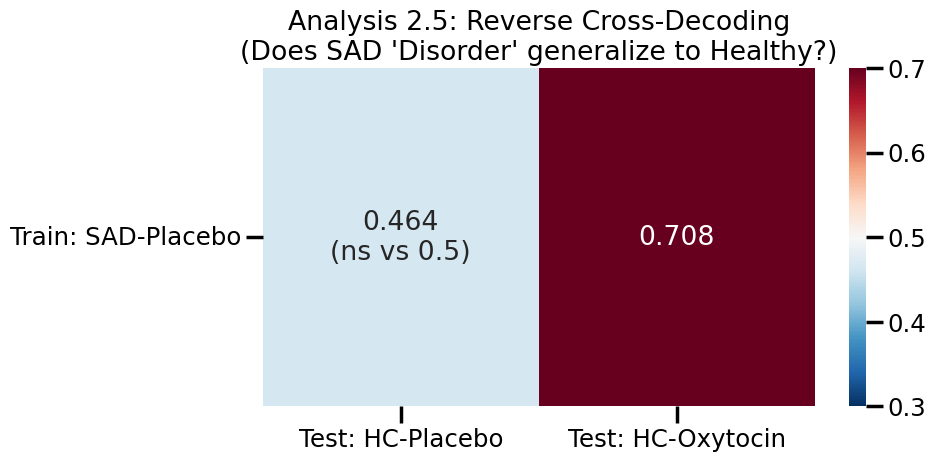

In [ ]:
# Cell 16: Analysis 2.5 - Reverse Cross-Decoding (SAD Template -> HC)
# Objective: Test if the "Disordered" SAD representation generalizes to Healthy brains.
# Protocol:
#   1. Train Model on SAD-Placebo (CSS vs CSR).
#   2. Feature Selection: SAD Top 5% (Native SAD Network).
#   3. Test on HC-Placebo and HC-Oxytocin.
#   4. Metric: Pairwise Forced Choice Accuracy.
# Hypothesis: Accuracy should be LOW (near chance), confirming "Functional Specificity".

print("--- Running Analysis 2.5: Reverse Cross-Decoding (SAD -> HC) ---")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_ind

# Constants
COND_SAFE = "CSS"
COND_THREAT = "CSR"
LABELS = [COND_SAFE, COND_THREAT]

# =============================================================================
# 0. Setup: Define SAD Feature Space (The "Disordered Template")
# =============================================================================
if 'importance_scores' not in locals(): 
    raise ValueError("Importance scores missing. Run Cell 8.")

# Use SAD Top 5% as the Feature Mask
scores_sad = importance_scores['SAD']
thresh_sad = np.percentile(scores_sad, 95)
mask_sad_native = (scores_sad >= thresh_sad) & (scores_sad > 0)
print(f"  > Feature Space: SAD Top 5% ({np.sum(mask_sad_native)} voxels)")

# Data Loading Helper
def get_ext_data(group_key):
    if group_key not in data_subsets: raise ValueError(f"{group_key} missing.")
    d = data_subsets[group_key]['ext']
    return d["X"], d["y"], d["sub"]

# Load Groups
X_sad_plc, y_sad_plc, sub_sad_plc = get_ext_data("SAD_Placebo")
X_hc_plc, y_hc_plc, sub_hc_plc = get_ext_data("HC_Placebo")
X_hc_oxt, y_hc_oxt, sub_hc_oxt = get_ext_data("HC_Oxytocin")

# =============================================================================
# 1. Train SAD-Placebo Model (The "Disordered" Classifier)
# =============================================================================
print("\n[Step 1] Training SAD-Placebo Model...")

# Filter for CSS vs CSR
mask_train = np.isin(y_sad_plc, LABELS)
X_train = X_sad_plc[mask_train][:, mask_sad_native] # Apply SAD Mask
y_train = y_sad_plc[mask_train]
s_train = sub_sad_plc[mask_train]

# Center (Subject-wise)
X_train = subject_wise_centering(X_train, s_train)

# Train Classifier
sad_model = build_binary_pipeline()
sad_model.fit(X_train, y_train)

print(f"  > Model Trained on {len(np.unique(s_train))} SAD subjects.")
print(f"  > Classes: {sad_model.classes_}")

# =============================================================================
# 2. Cross-Decode on HC Groups (Forced Choice)
# =============================================================================
print("\n[Step 2] Testing on HC Subgroups...")

def calc_forced_choice_acc(model, X, y, subs, feature_mask):
    # 1. Filter Data
    mask_c = np.isin(y, LABELS)
    X_f = X[mask_c][:, feature_mask] # Apply SAD Mask
    y_f = y[mask_c]
    s_f = subs[mask_c]
    
    if len(y_f) == 0: return []

    # 2. Center (Subject-wise)
    X_f = subject_wise_centering(X_f, s_f)
    
    # 3. Get Decision Values
    scores = model.decision_function(X_f)
    
    # 4. Aggregate Scores per Subject
    df_scores = pd.DataFrame({'sub': s_f, 'cond': y_f, 'score': scores})
    means = df_scores.groupby(['sub', 'cond'])['score'].mean().unstack()
    
    valid_subs = means.dropna().index
    means = means.loc[valid_subs]
    
    # 5. Calculate Accuracy
    pos_idx = np.where(model.classes_ == COND_THREAT)[0][0]
    accs = []
    
    for sub in means.index:
        s_threat = means.loc[sub, COND_THREAT]
        s_safe = means.loc[sub, COND_SAFE]
        
        if pos_idx == 1: correct = s_threat > s_safe
        else: correct = s_threat < s_safe
        accs.append(1.0 if correct else 0.0)
        
    return accs

# Run Cross-Decoding
acc_hc_plc = calc_forced_choice_acc(sad_model, X_hc_plc, y_hc_plc, sub_hc_plc, mask_sad_native)
acc_hc_oxt = calc_forced_choice_acc(sad_model, X_hc_oxt, y_hc_oxt, sub_hc_oxt, mask_sad_native)

m_hc_plc = np.mean(acc_hc_plc) if len(acc_hc_plc) > 0 else 0
m_hc_oxt = np.mean(acc_hc_oxt) if len(acc_hc_oxt) > 0 else 0

print(f"  > HC-Placebo Acc (decoded by SAD):  {m_hc_plc:.1%} (n={len(acc_hc_plc)})")
print(f"  > HC-Oxytocin Acc (decoded by SAD): {m_hc_oxt:.1%} (n={len(acc_hc_oxt)})")

# =============================================================================
# 3. Statistical Comparison
# =============================================================================
print("\n[Step 3] Statistical Test (Vs Chance 50%)...")

# Test if HC-Placebo decoding is significantly above chance
# If p > 0.05, it confirms SAD representations do NOT generalize to HC (High Specificity)
t_chance, p_chance = ttest_1samp(acc_hc_plc, 0.5)
sig_chance = "*" if p_chance < 0.05 else "ns"

print(f"  > SAD->HC Generalization (vs 50%): t={t_chance:.3f}, p={p_chance:.4f} ({sig_chance})")
print("    (Note: 'ns' is GOOD here -> implies disordered code is specific to SAD)")

# Compare HC-PLC vs HC-OXT (Exploratory)
t_drug, p_drug = ttest_ind(acc_hc_oxt, acc_hc_plc)
print(f"  > Drug Effect in HC (OXT vs PLC): p={p_drug:.4f}")

# =============================================================================
# 4. Visualization (Heatmap)
# =============================================================================
sns.set_context("poster", font_scale=0.8)
fig, ax = plt.subplots(figsize=(10, 5))

matrix_data = np.array([[m_hc_plc, m_hc_oxt]])
annot_data = np.array([
    [f"{m_hc_plc:.3f}\n({sig_chance} vs 0.5)", f"{m_hc_oxt:.3f}"]
])

sns.heatmap(matrix_data, annot=annot_data, fmt="", cmap="RdBu_r", 
            vmin=0.3, vmax=0.7, center=0.5, cbar=True,
            xticklabels=['Test: HC-Placebo', 'Test: HC-Oxytocin'], 
            yticklabels=['Train: SAD-Placebo'], ax=ax)

ax.set_title("Analysis 2.5: Reverse Cross-Decoding\n(Does SAD 'Disorder' generalize to Healthy?)")
plt.yticks(rotation=0) 

plt.tight_layout()
plt.show()

results_25 = {'acc_hc_plc': acc_hc_plc, 'acc_hc_oxt': acc_hc_oxt, 'model': sad_model}